do not save model for default, if train new model, set parameter "save_model = True"

Threshold value is 0.8
0    32
1    18
dtype: int64
0     0.25
1     0.20
2     0.20
3     0.22
4     2.50
5     0.45
6     0.70
7     0.30
8     0.35
9     0.26
10    1.60
11    0.50
12    1.20
13    0.25
14    0.15
15    0.20
16    2.00
17    0.28
18    0.50
19    0.40
20    2.00
21    2.50
22    0.50
23    1.10
24    0.40
25    4.00
26    1.60
27    0.50
28    0.38
29    0.60
30    0.70
31    0.25
32    0.55
33    0.65
34    1.60
35    0.20
36    1.80
37    0.25
38    2.70
39    0.30
40    1.80
41    0.35
42    0.45
43    1.50
44    1.40
45    0.33
46    0.35
47    0.90
48    3.00
49    1.20
Name: GWD, dtype: float64
<class 'pandas.core.frame.DataFrame'>
-------------Fold 0 cross-validation-----------
Training for the 0th time
Fold 0, Training for the 0th time, f1_score mean 0.8333333333333334
Training for the 1th time
Training for the 2th time
Training for the 3th time
Training for the 4th time
Training for the 5th time
Training for the 6th time
Training for the 7th time
Fold 0, Tr

FileNotFoundError: [Errno 2] No such file or directory: 'GWD_classification_predict/predict.xlsx'

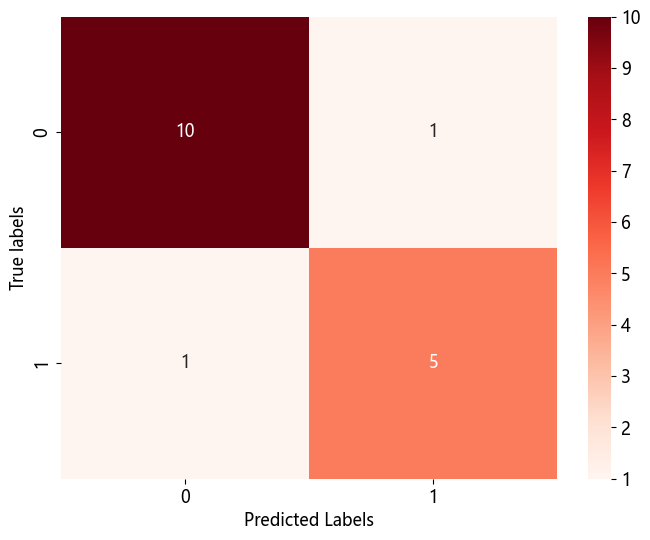

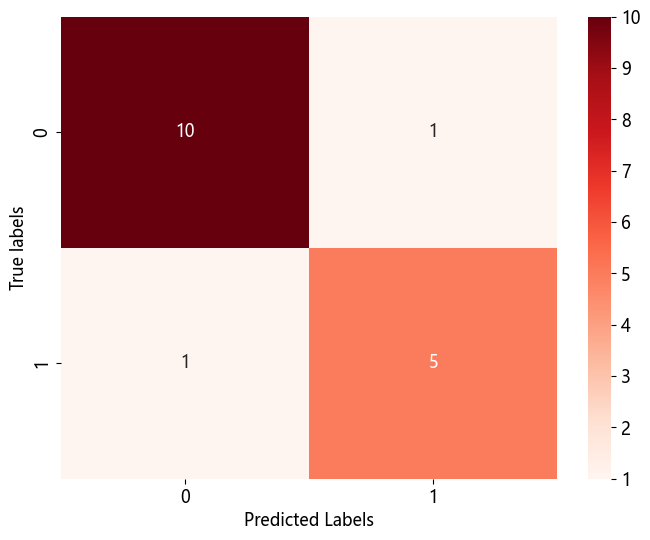

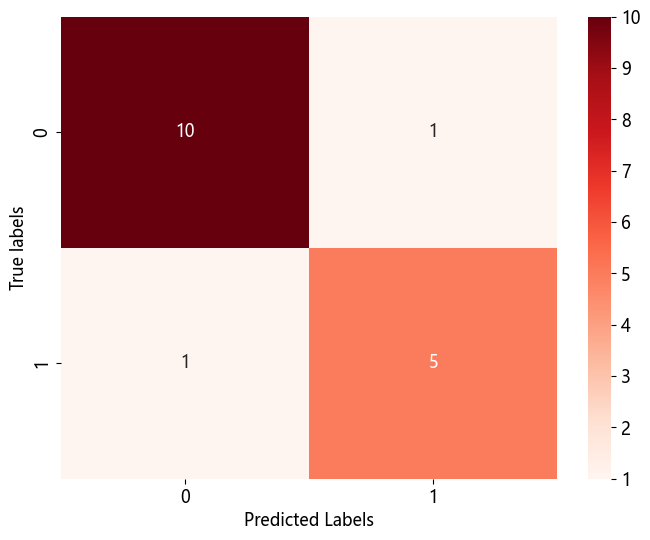

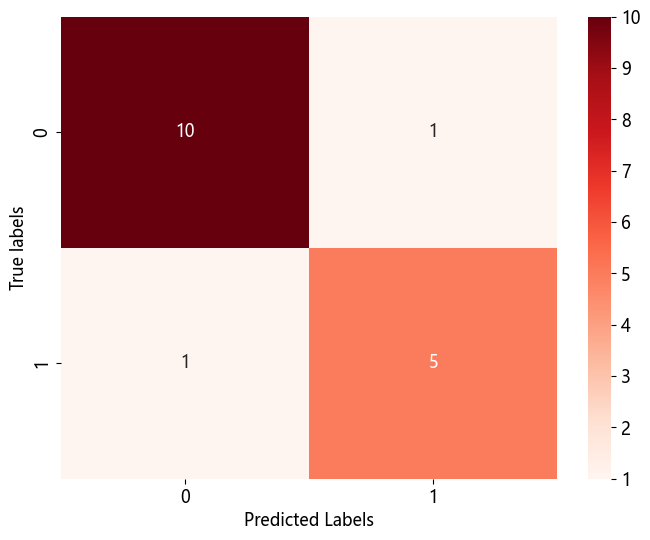

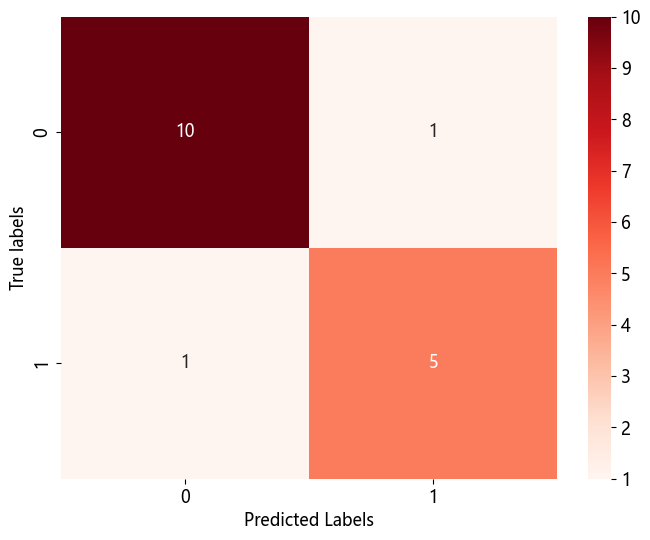

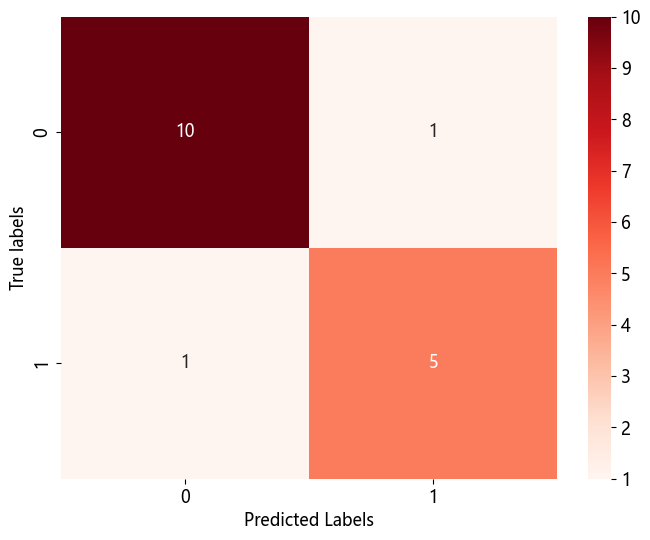

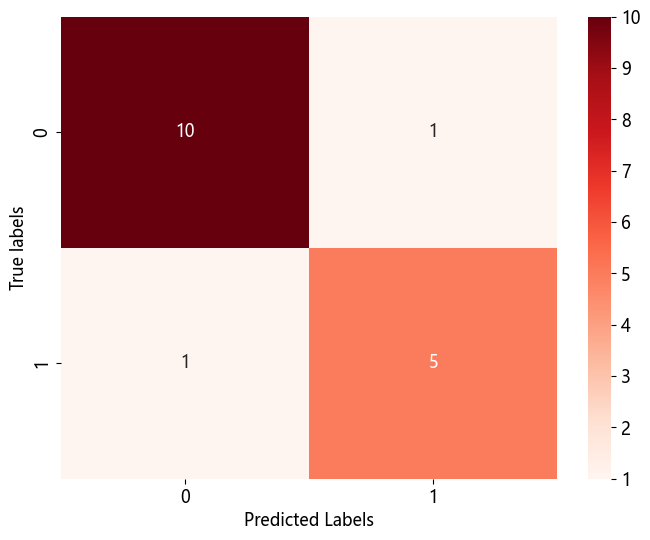

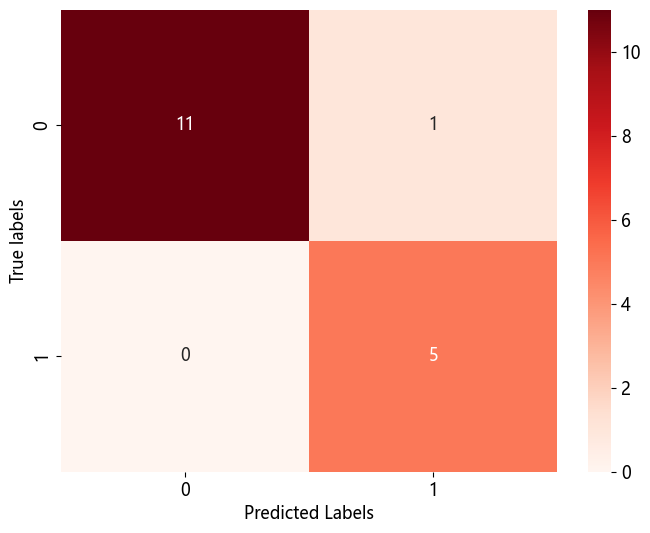

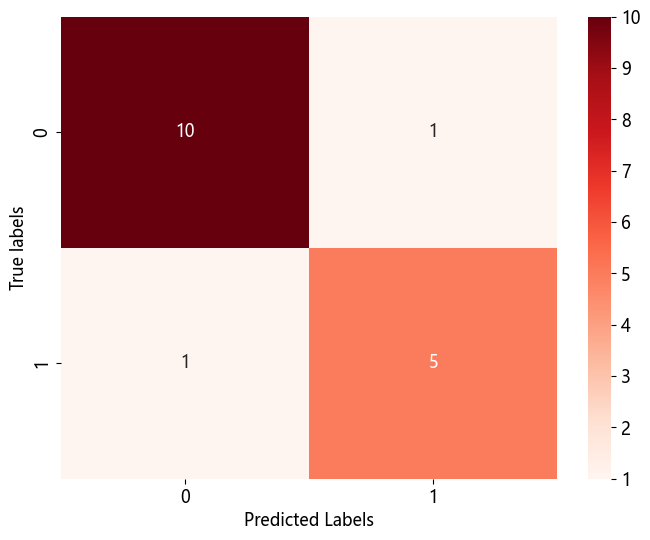

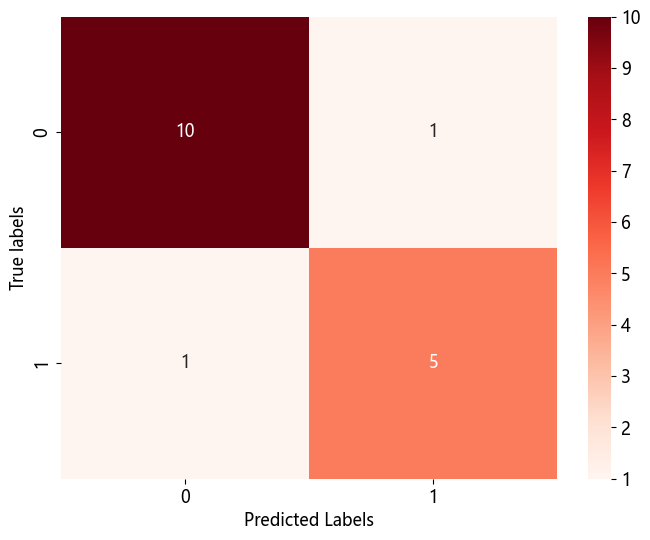

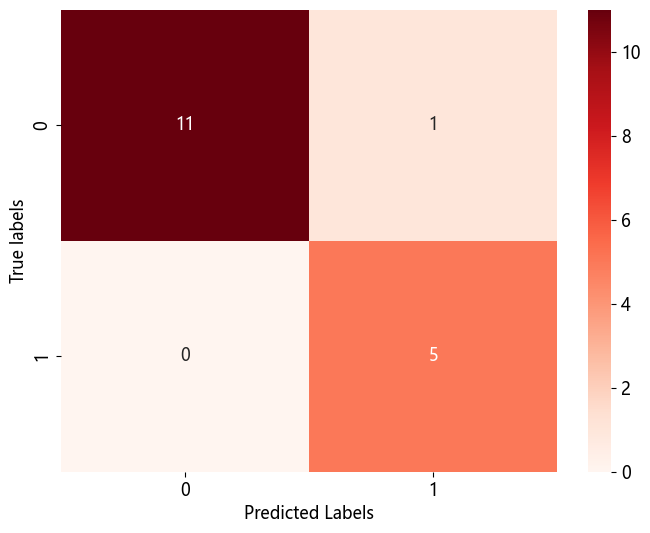

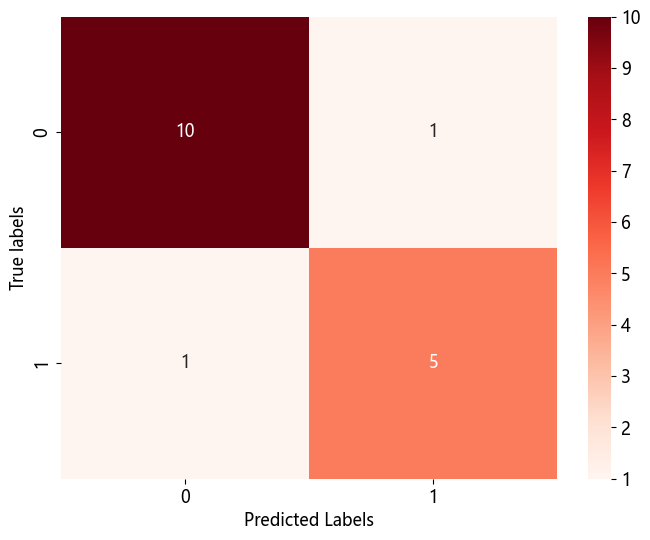

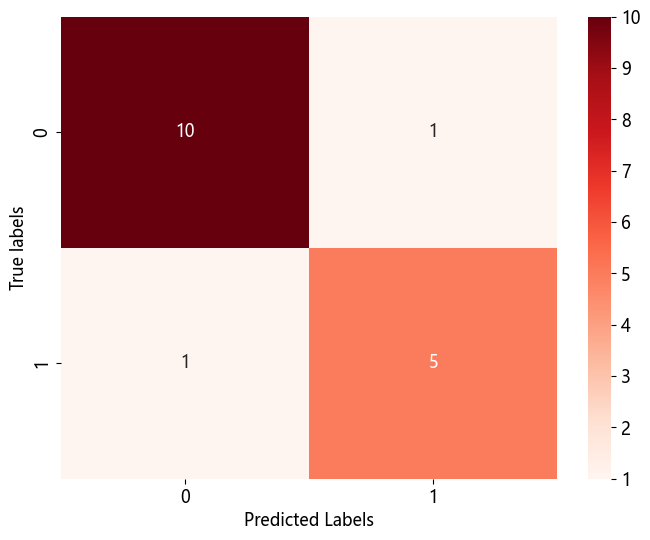

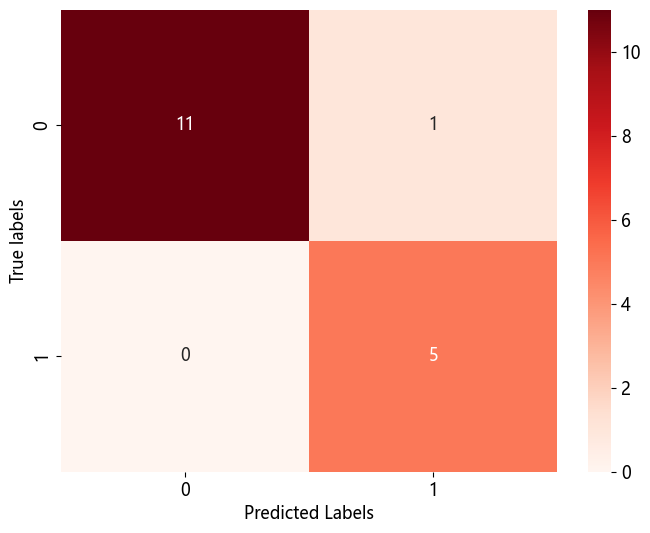

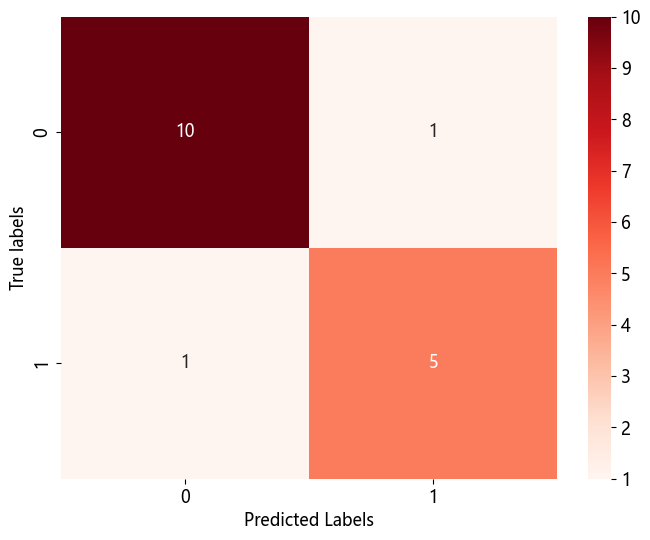

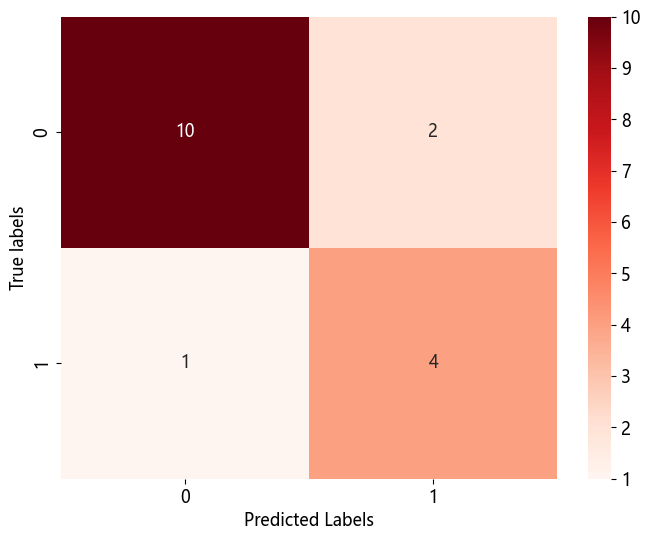

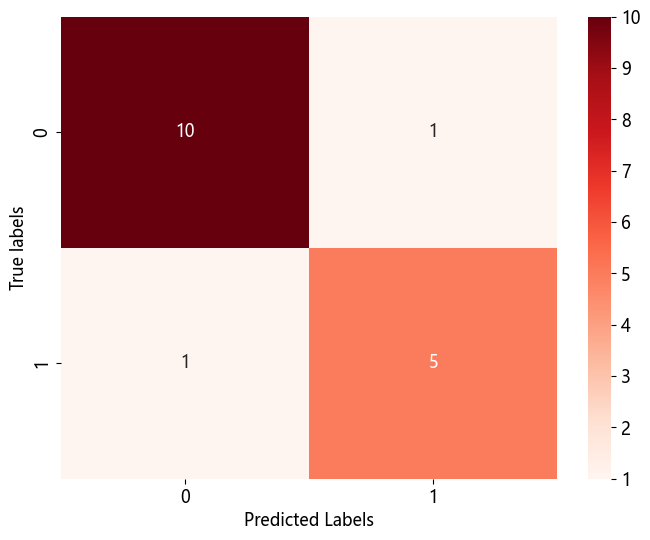

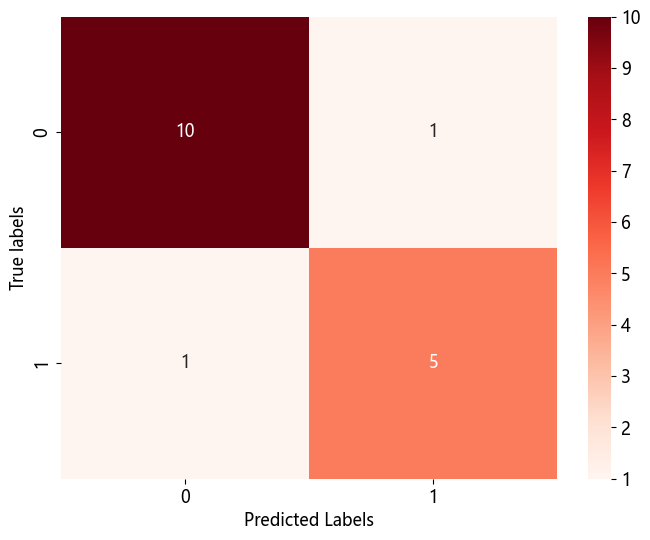

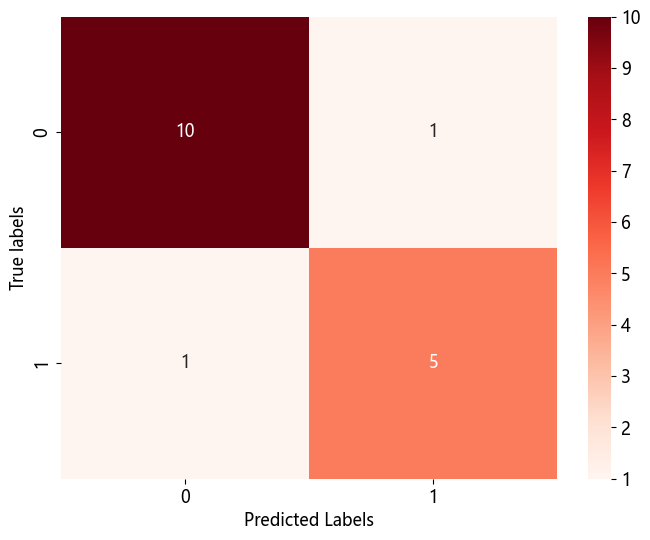

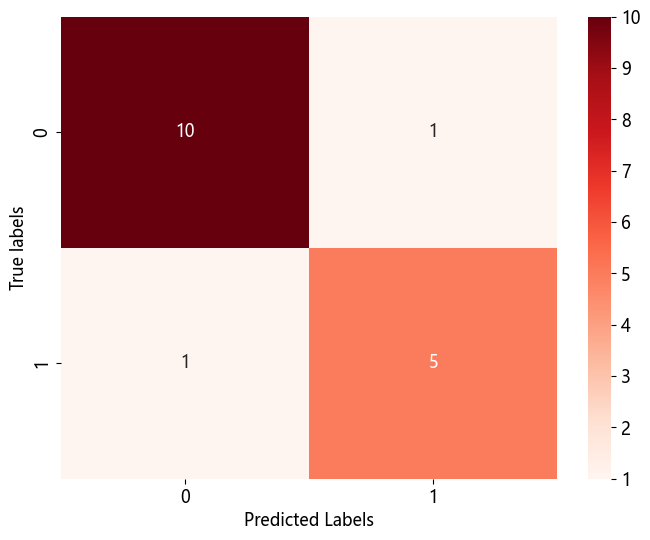

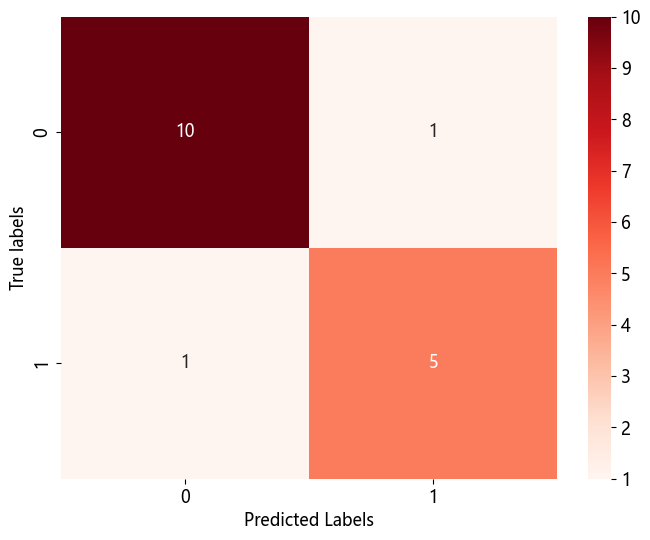

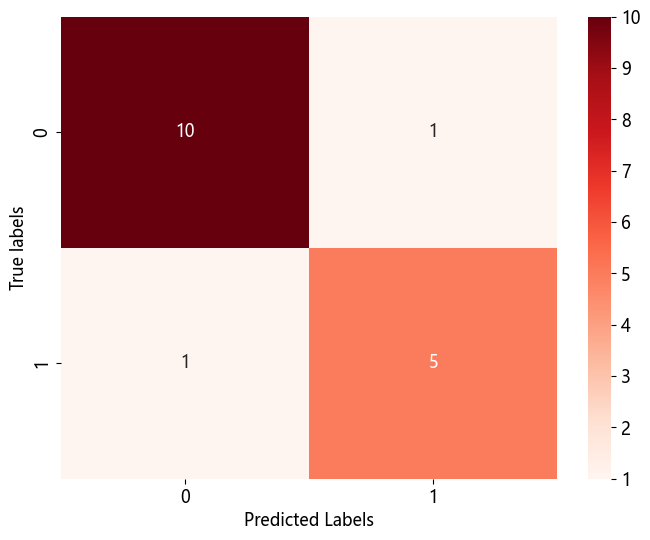

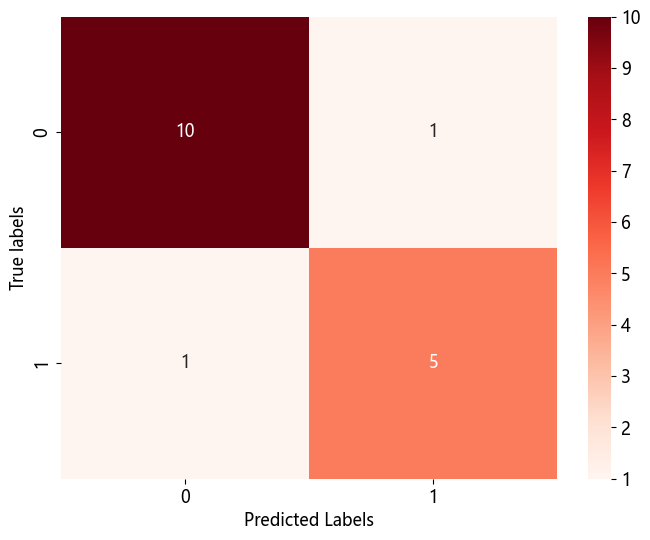

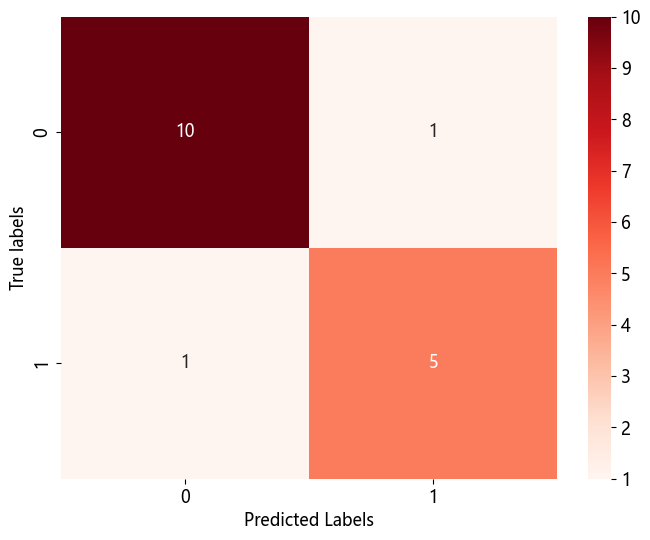

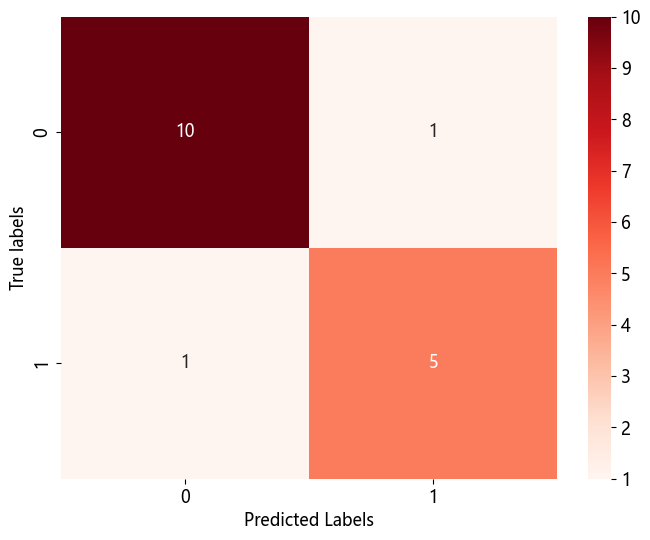

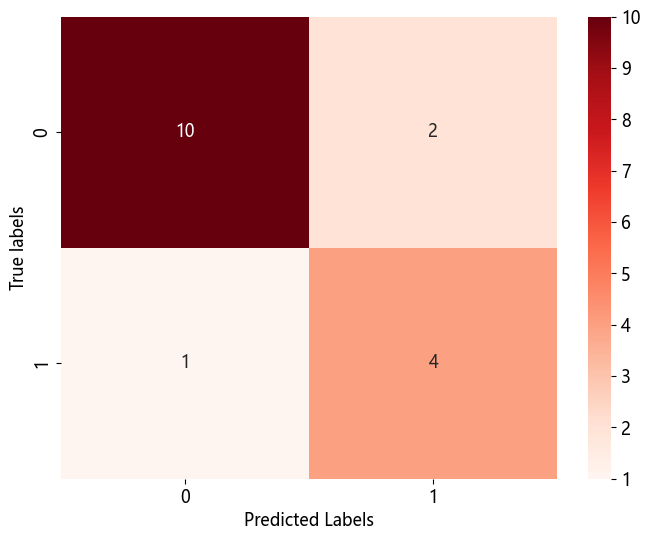

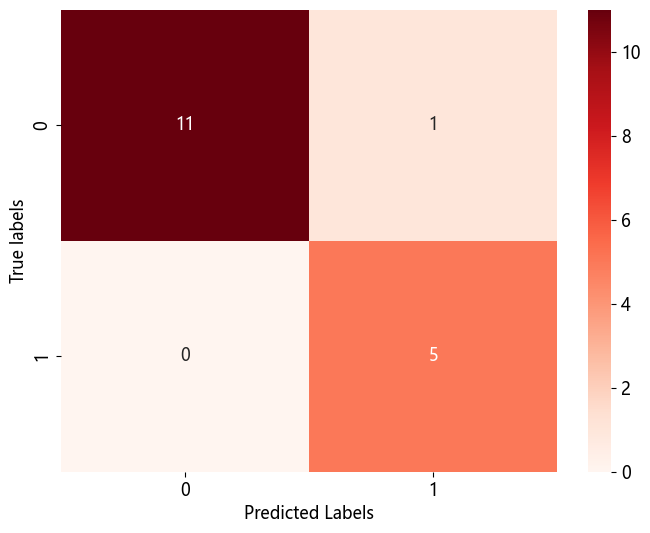

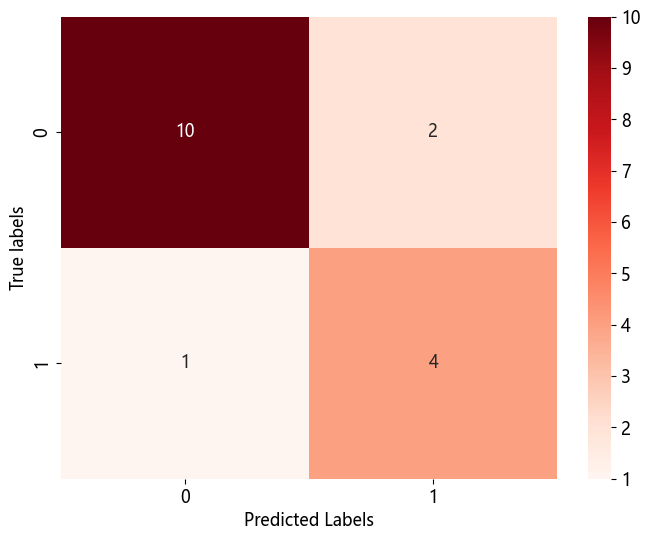

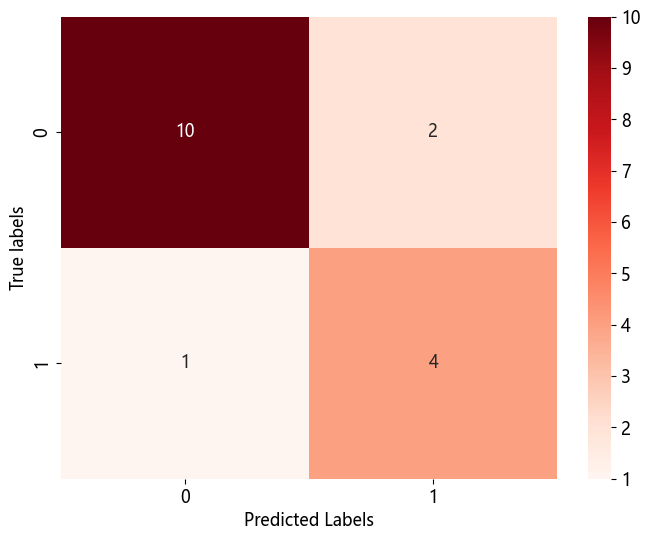

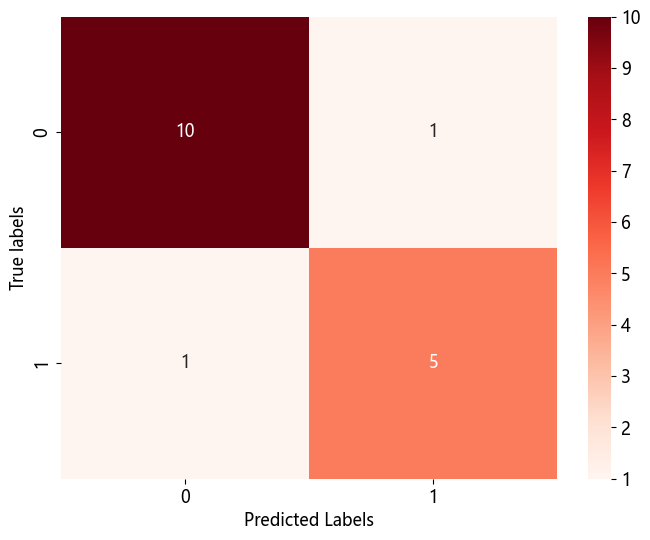

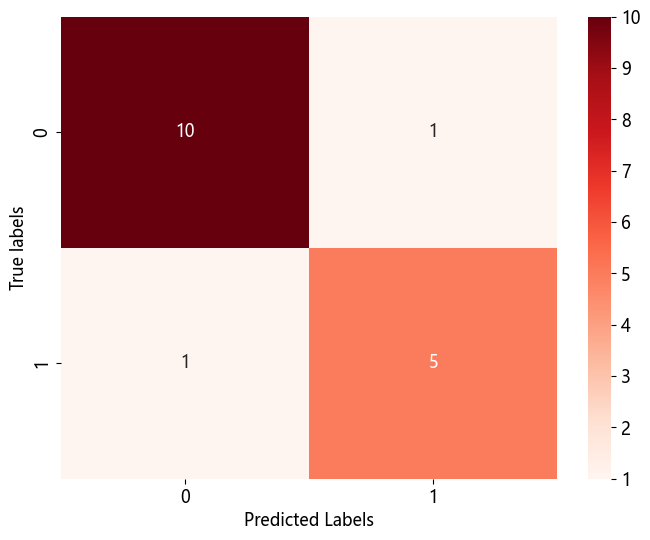

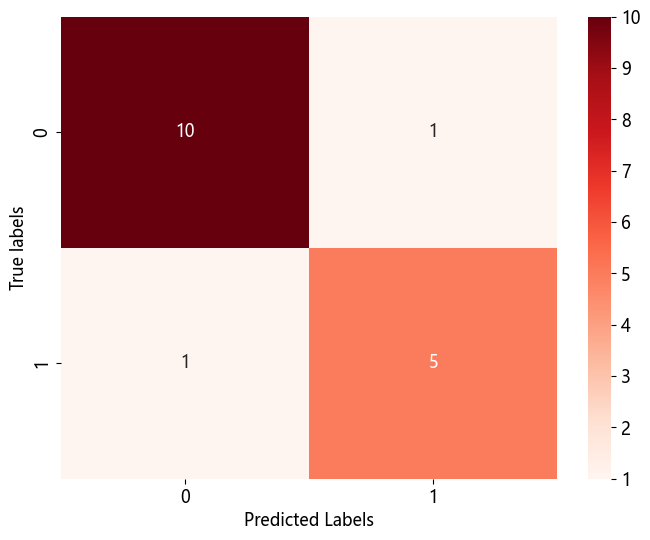

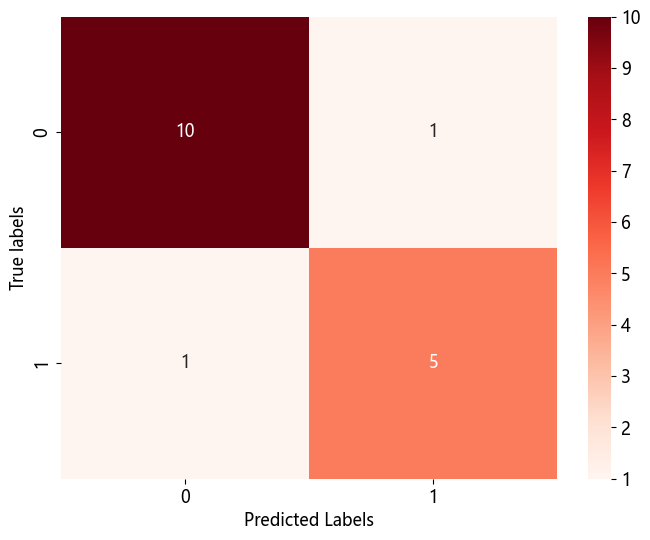

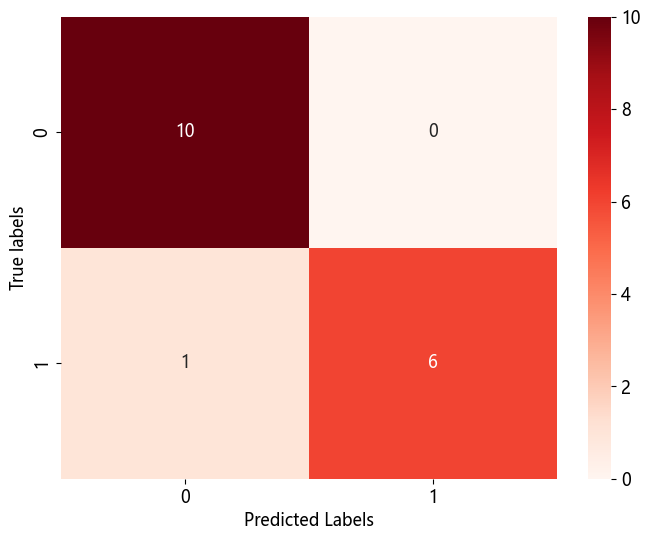

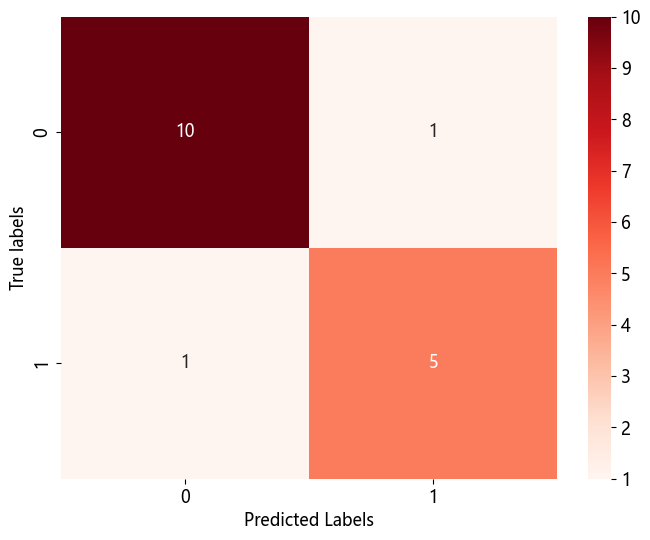

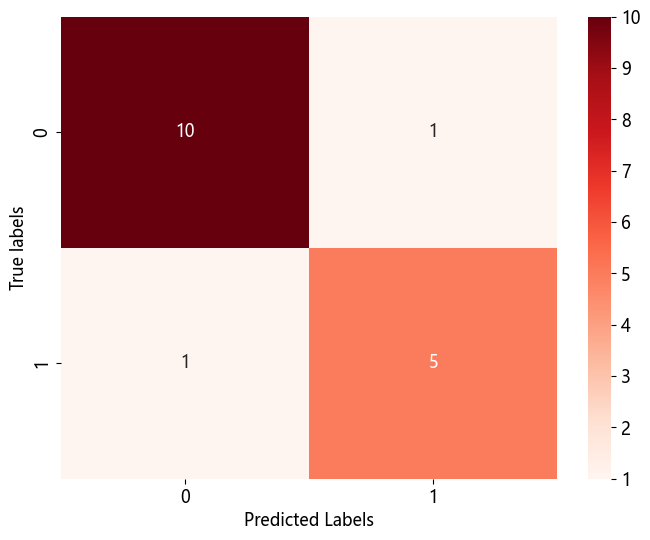

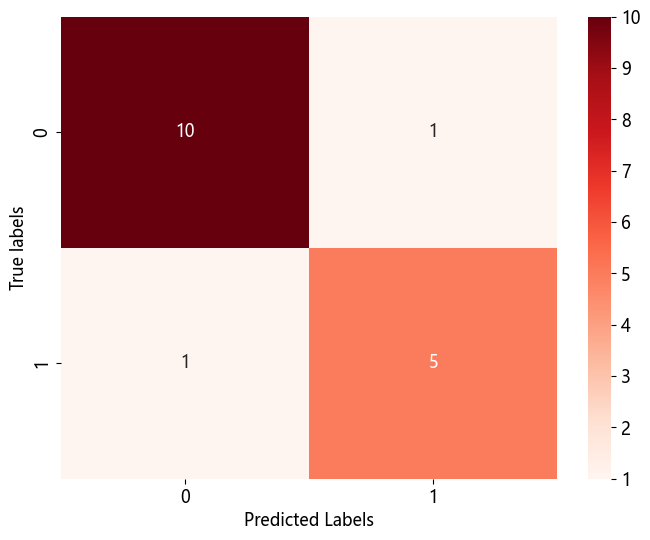

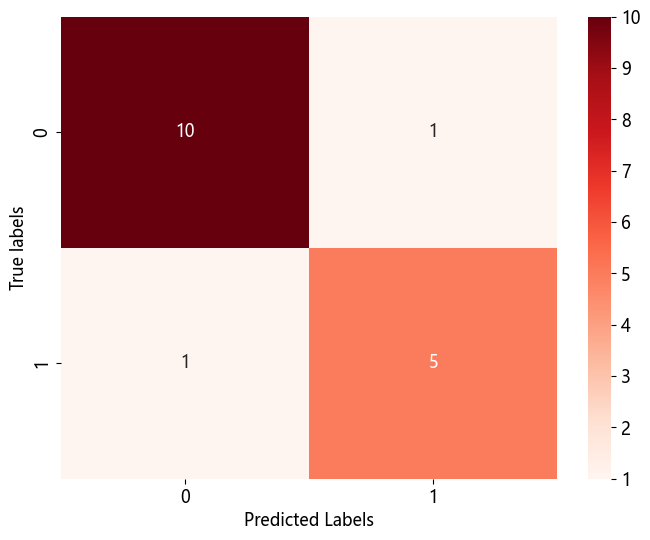

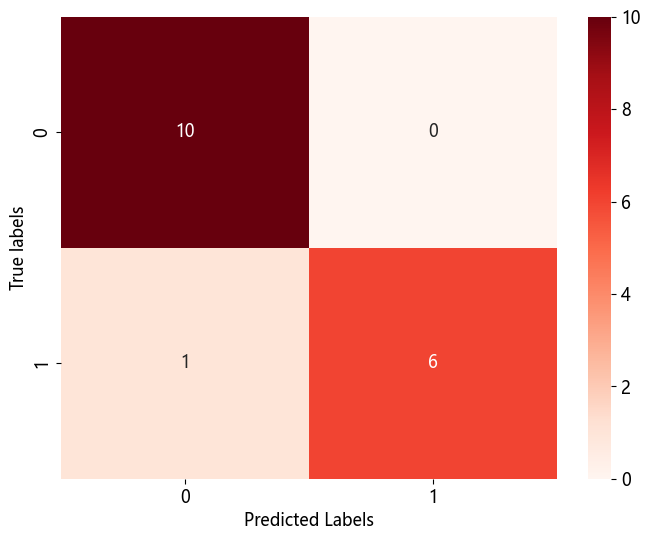

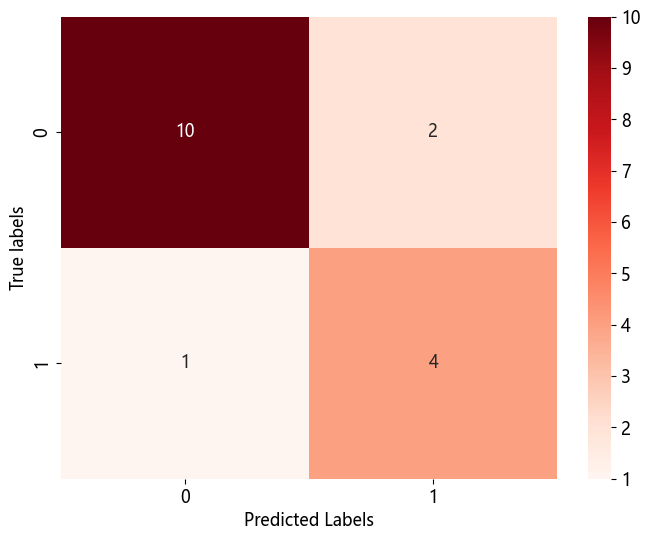

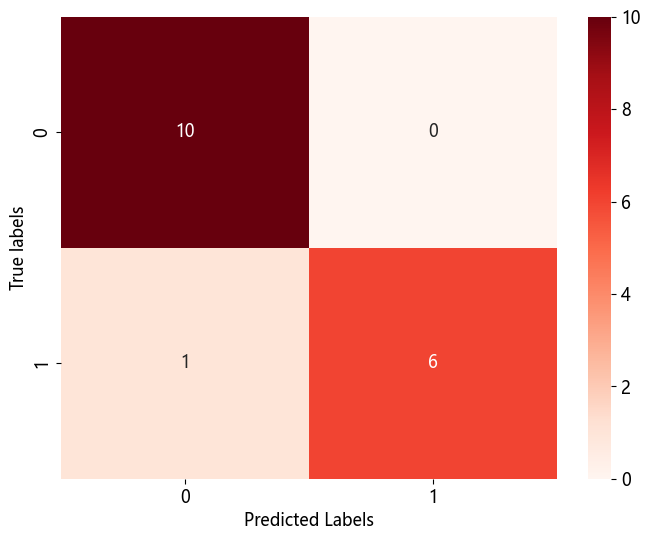

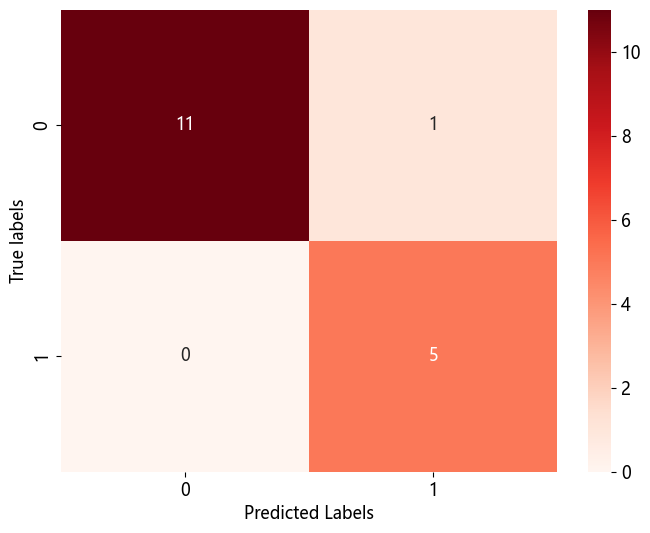

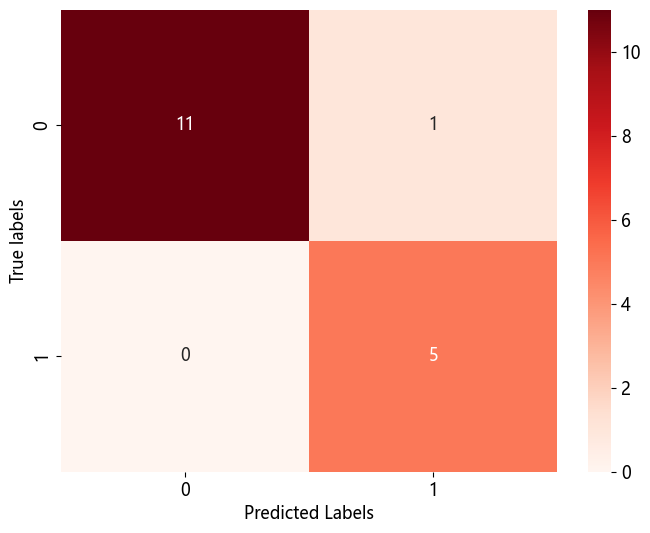

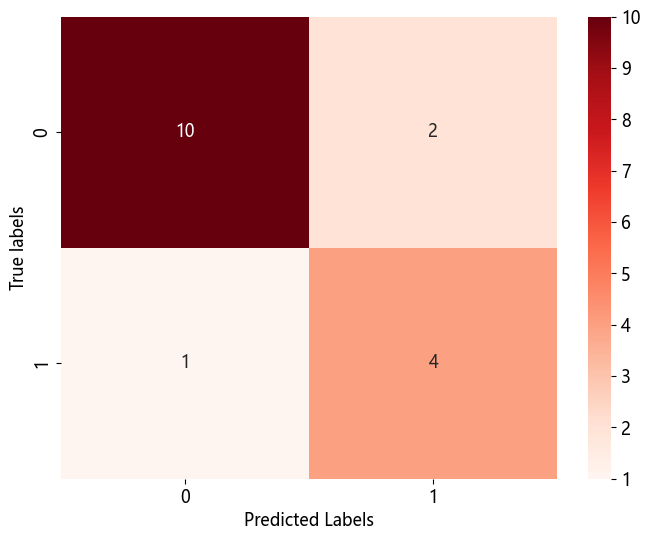

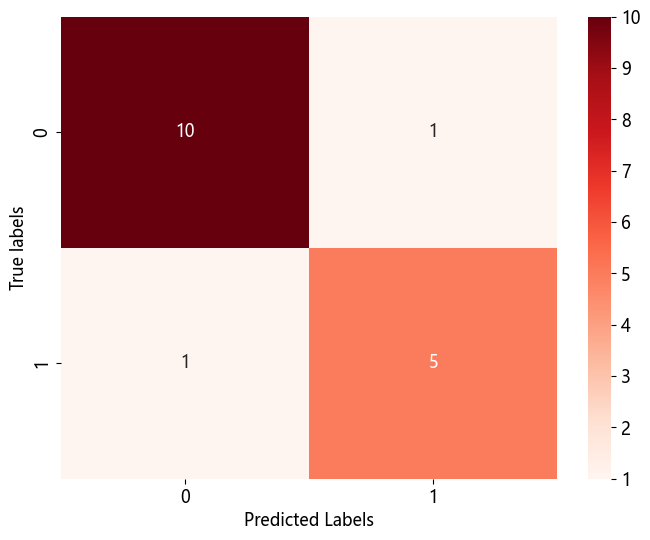

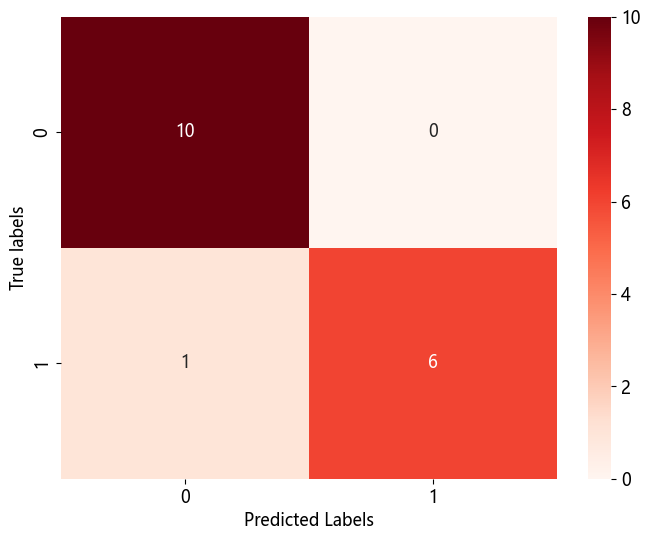

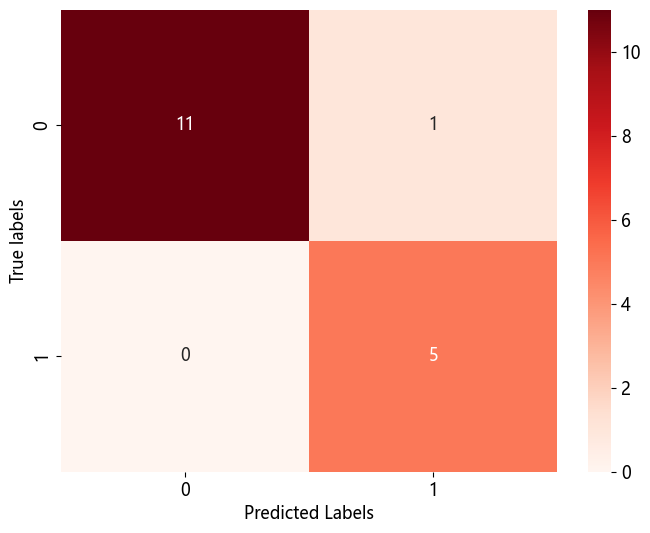

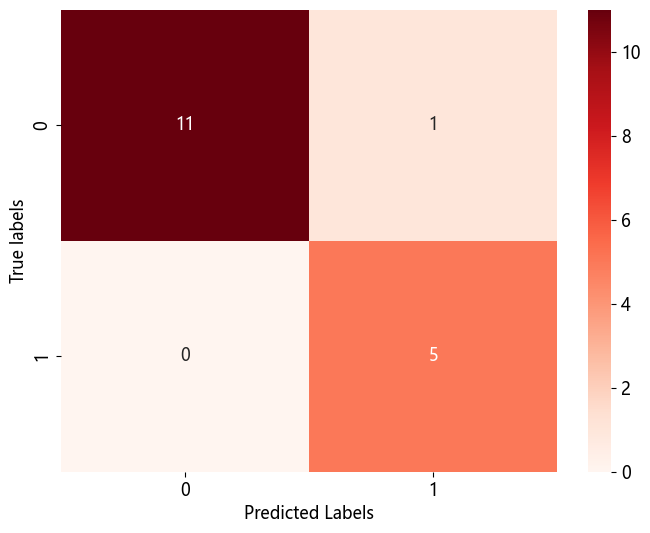

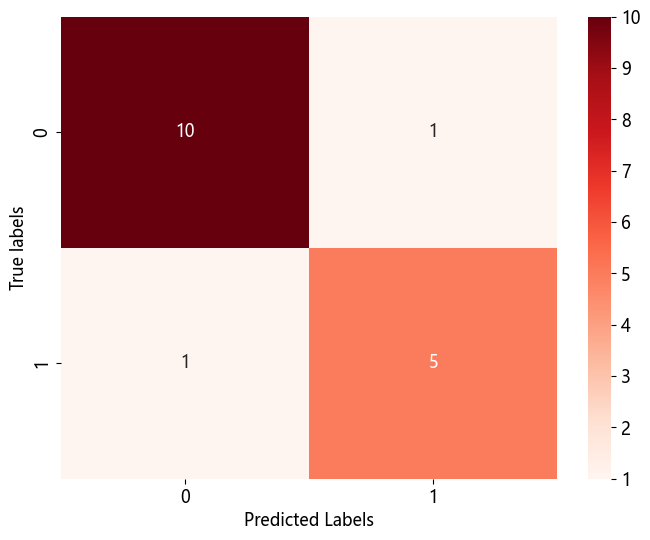

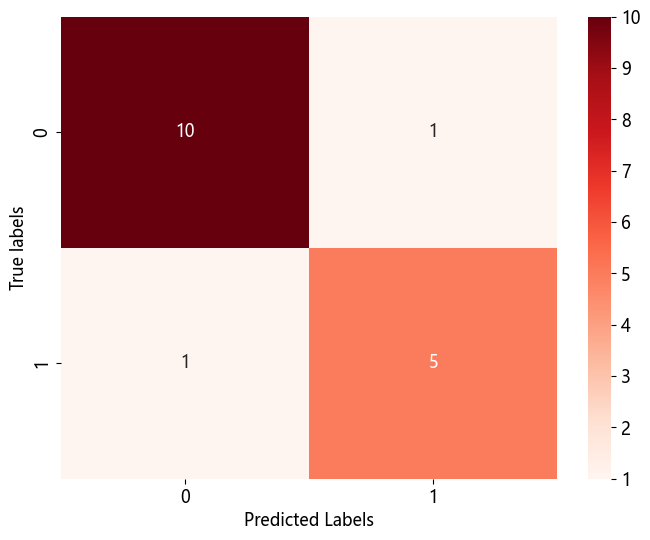

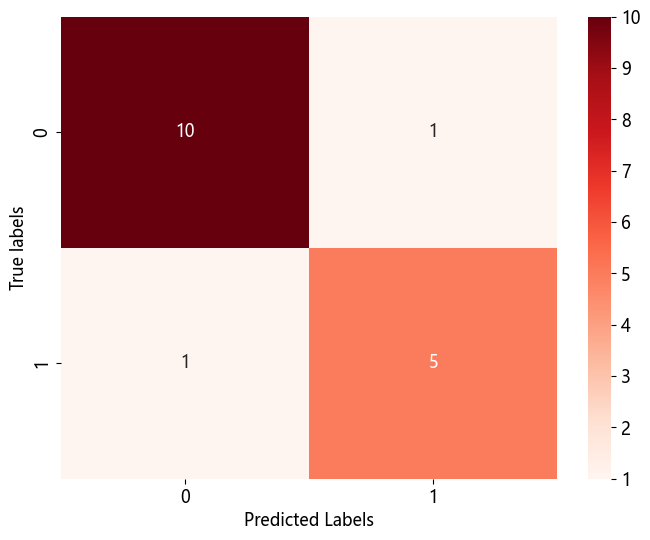

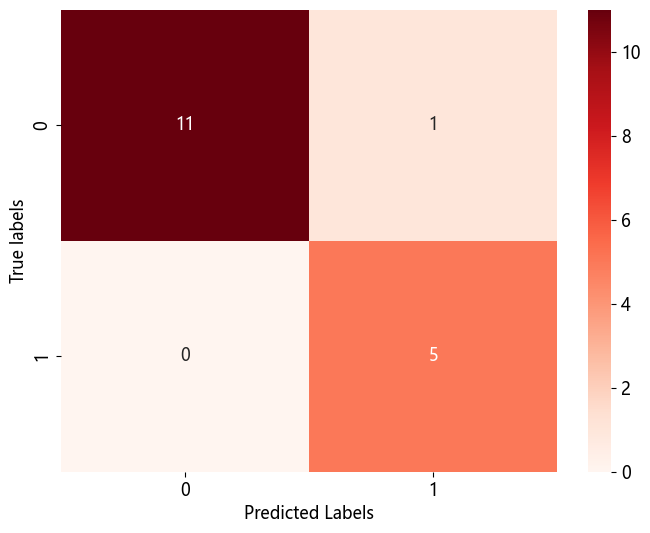

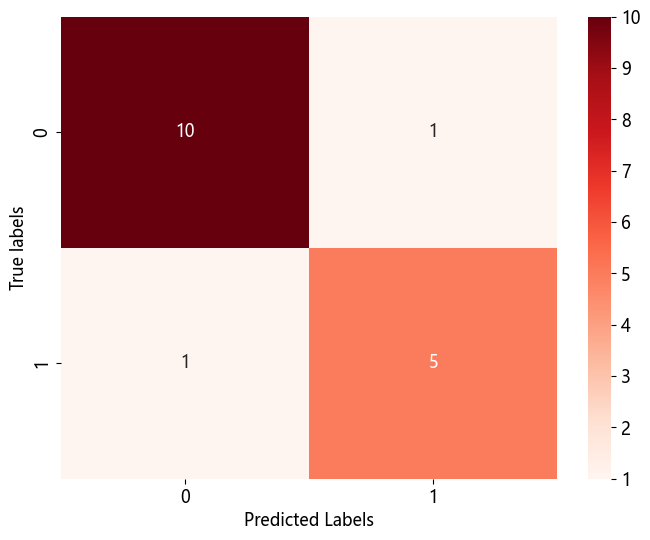

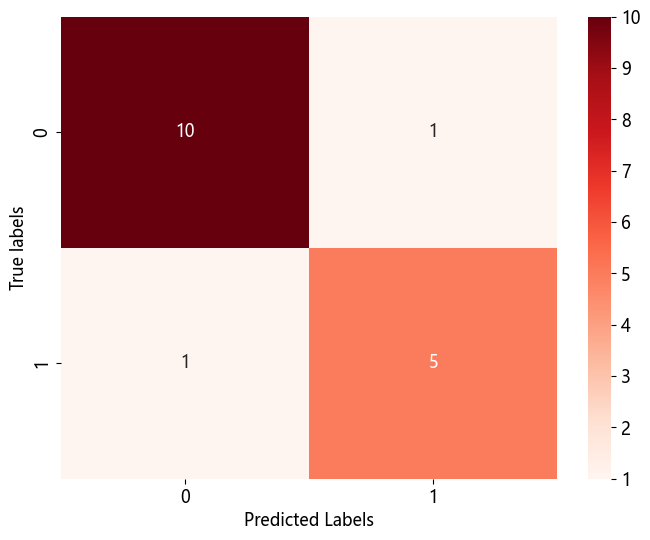

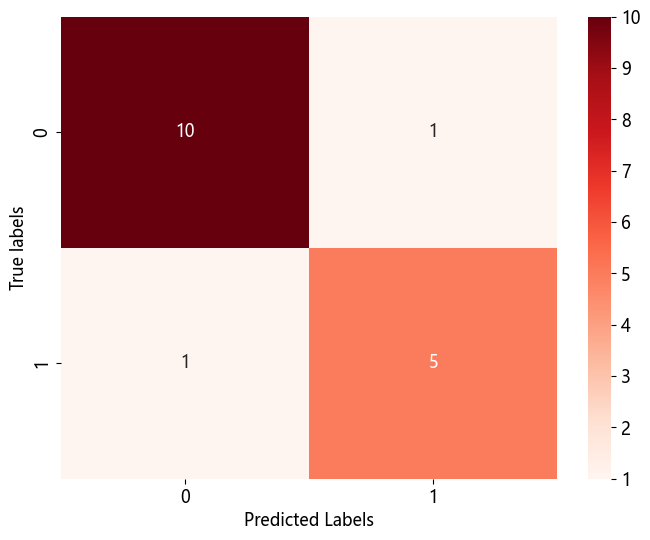

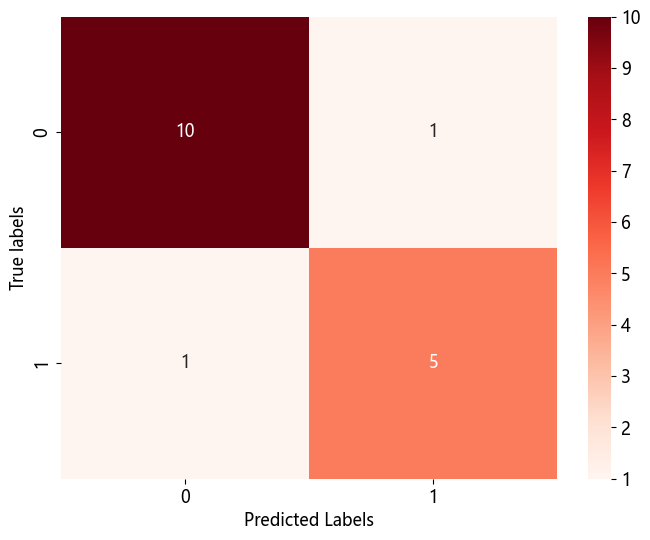

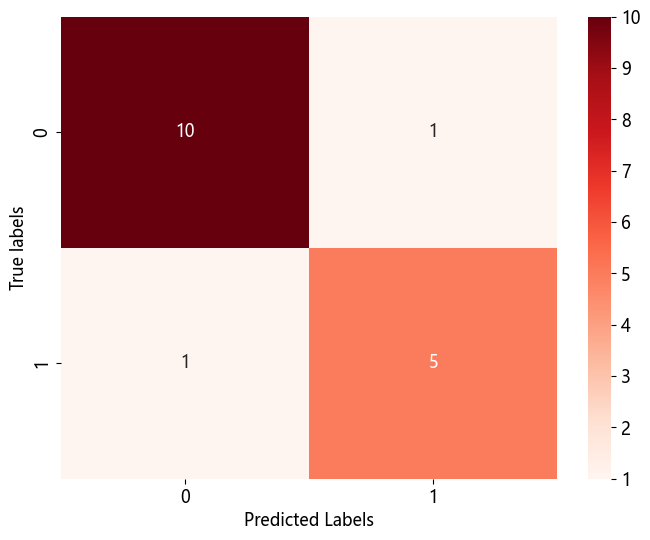

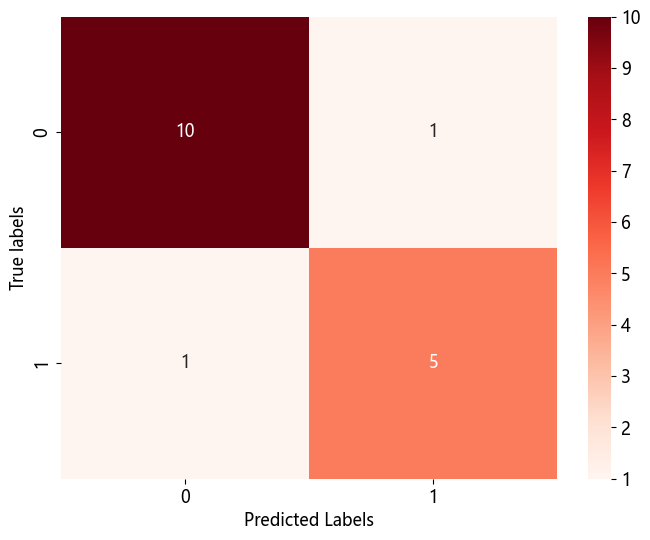

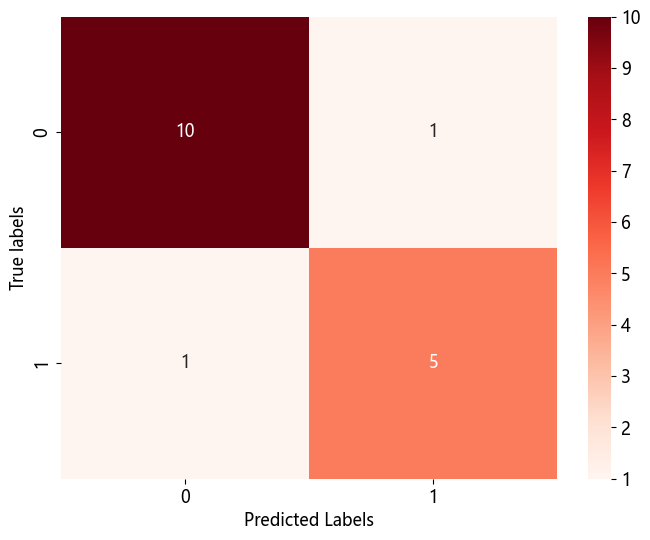

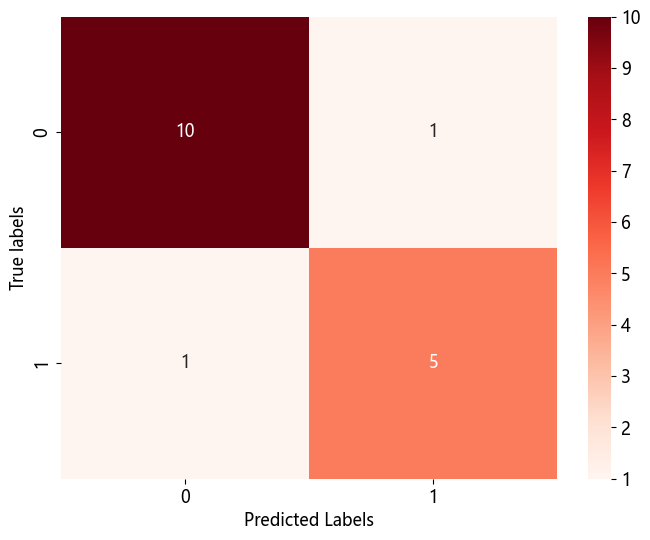

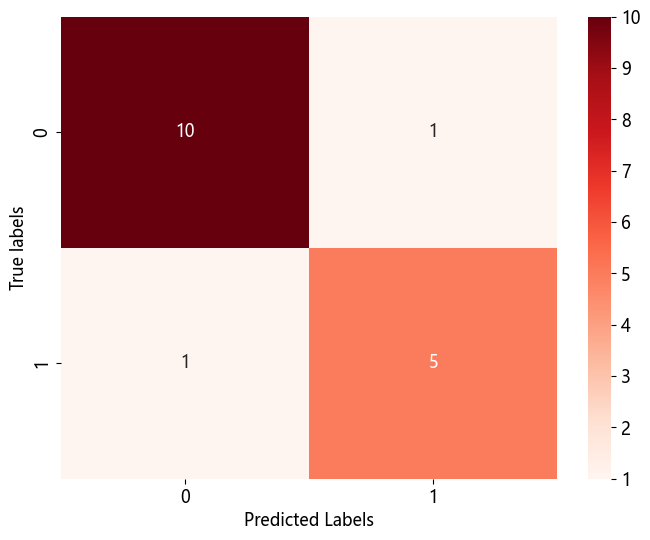

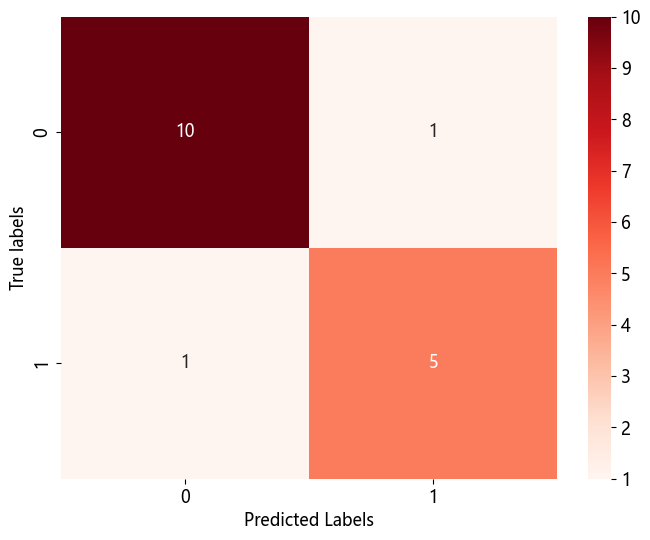

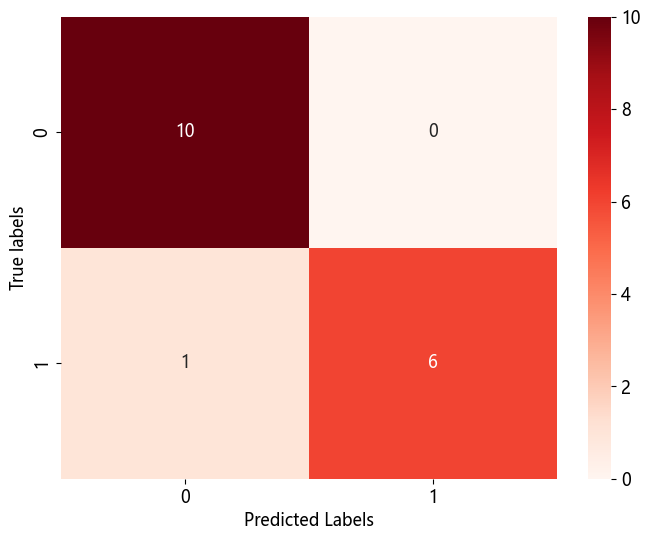

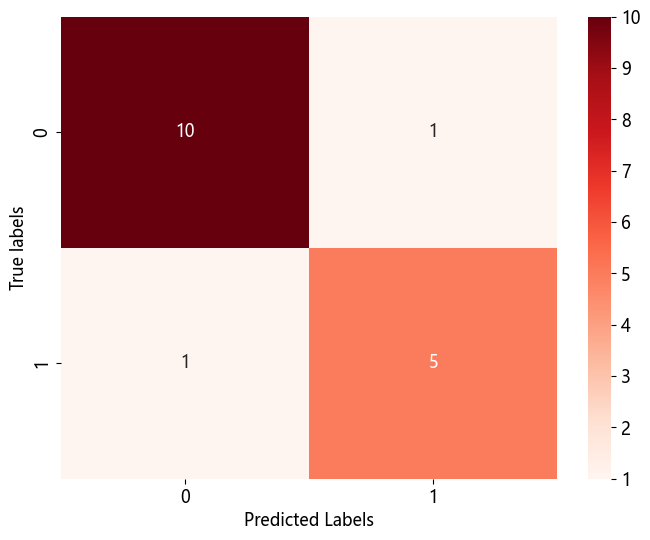

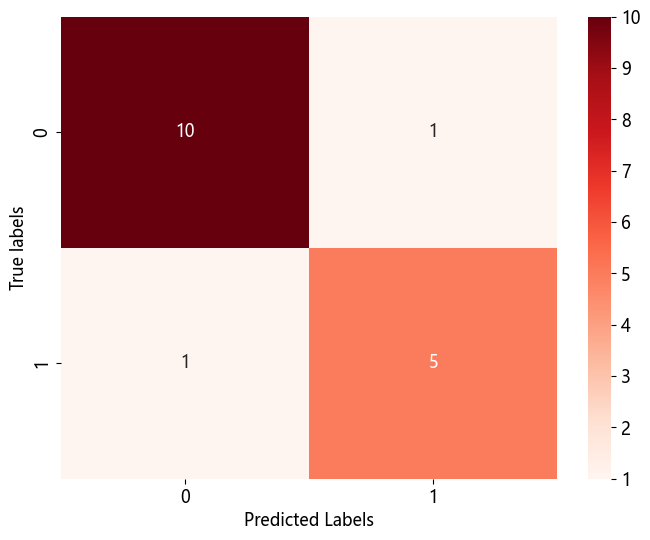

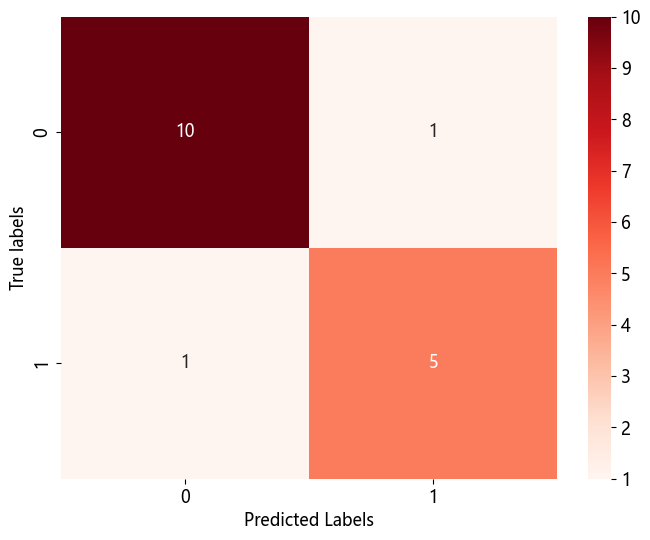

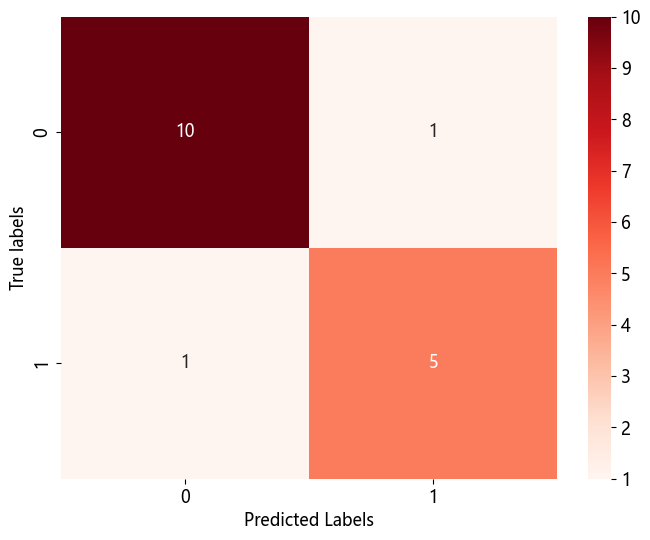

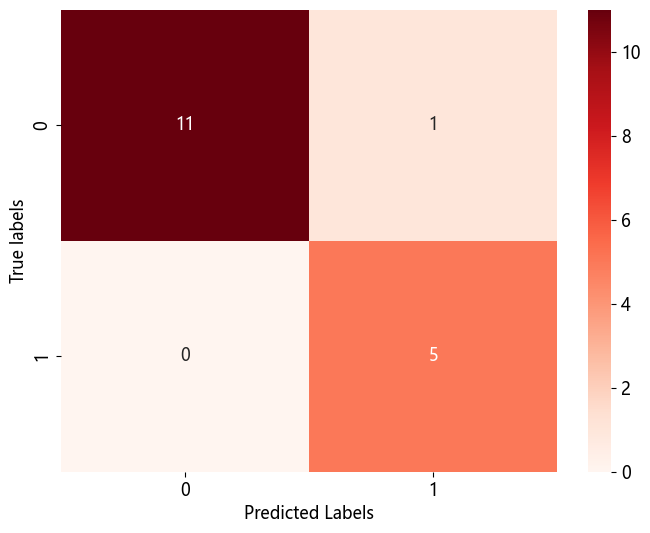

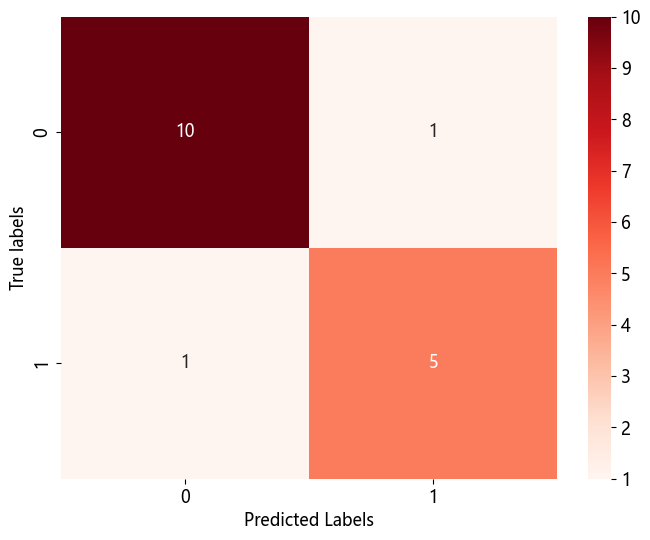

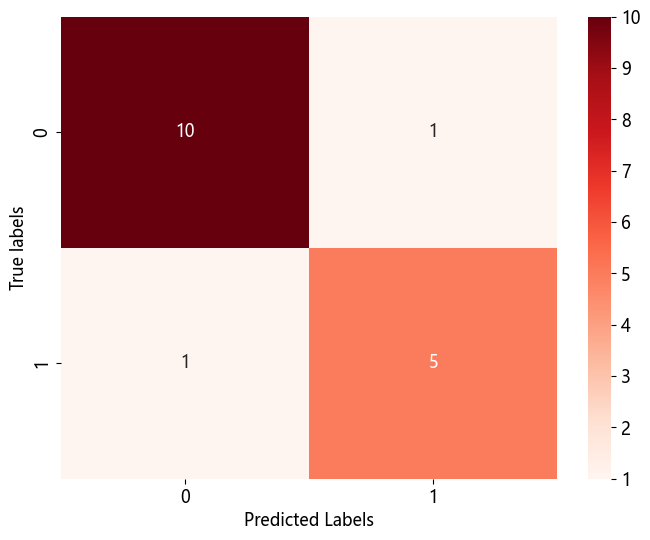

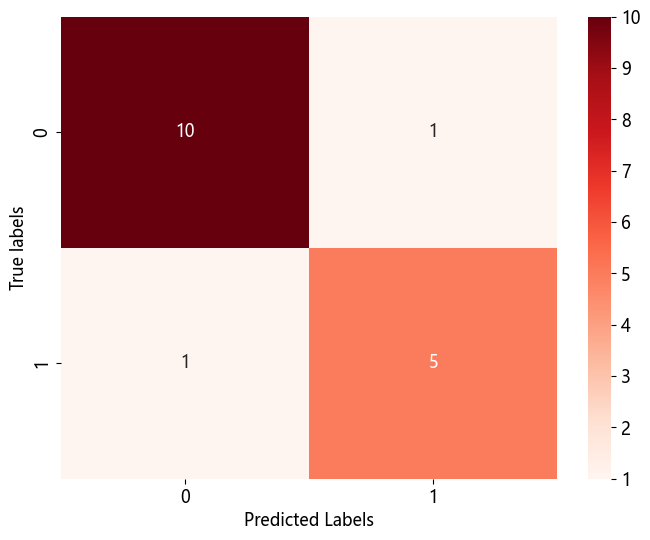

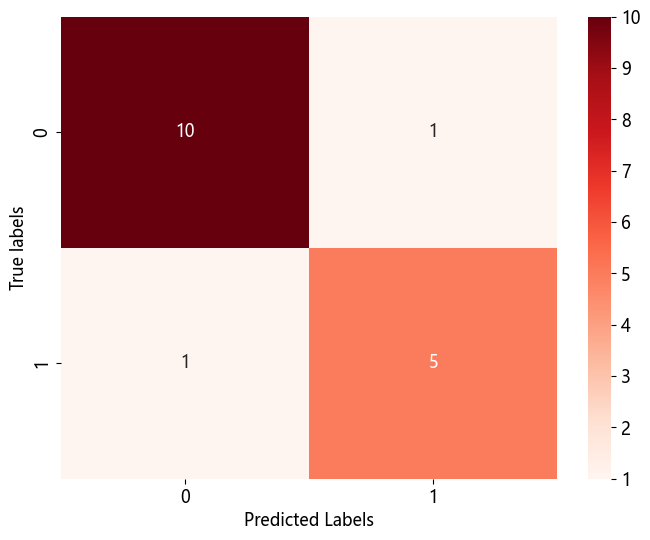

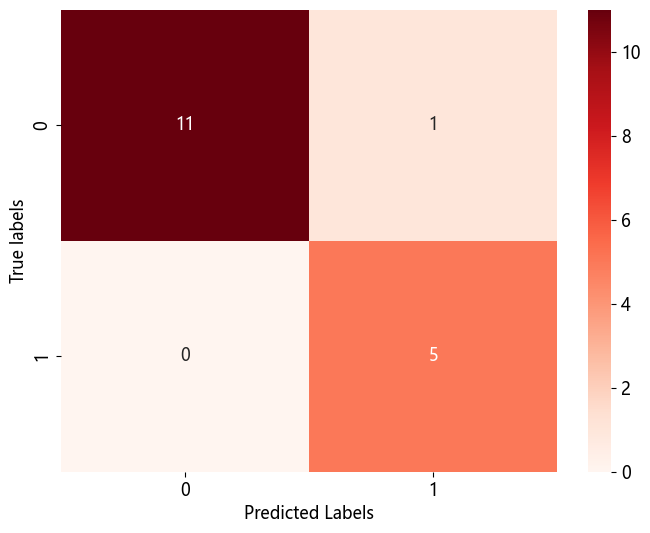

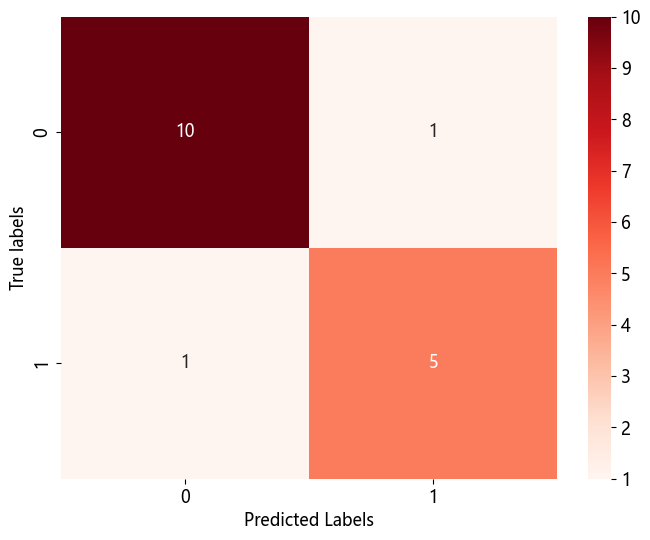

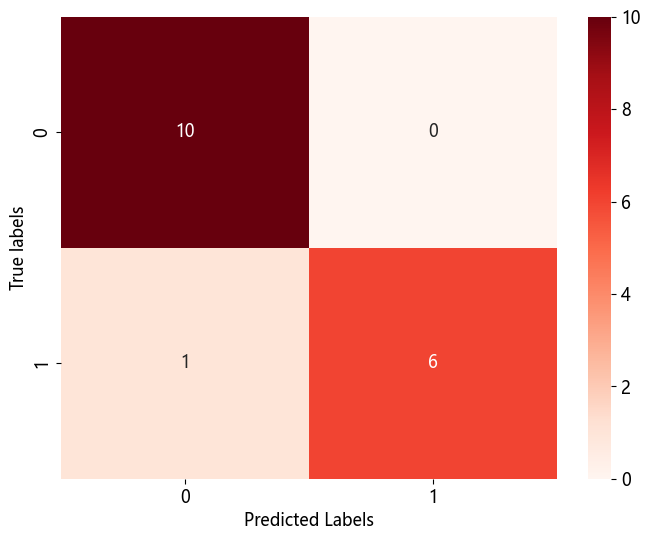

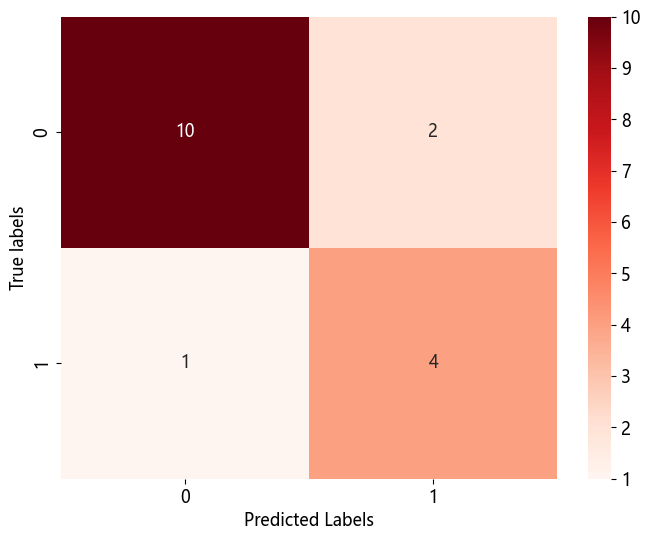

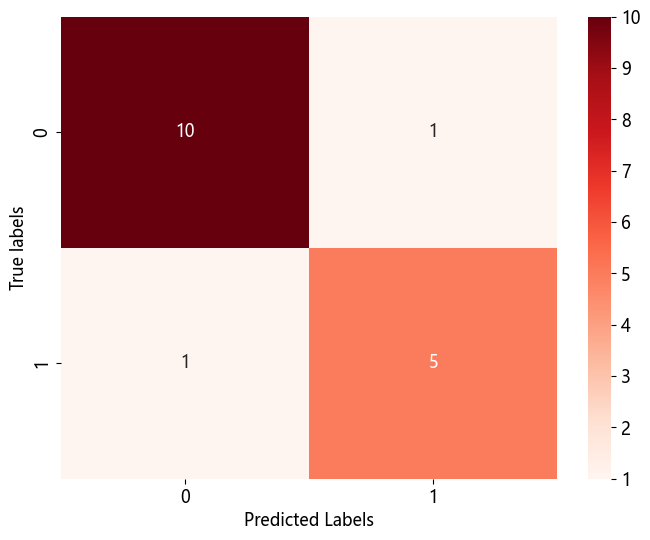

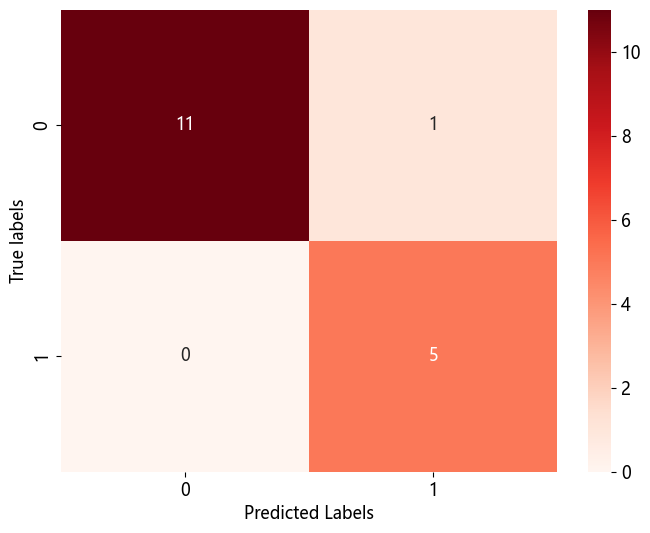

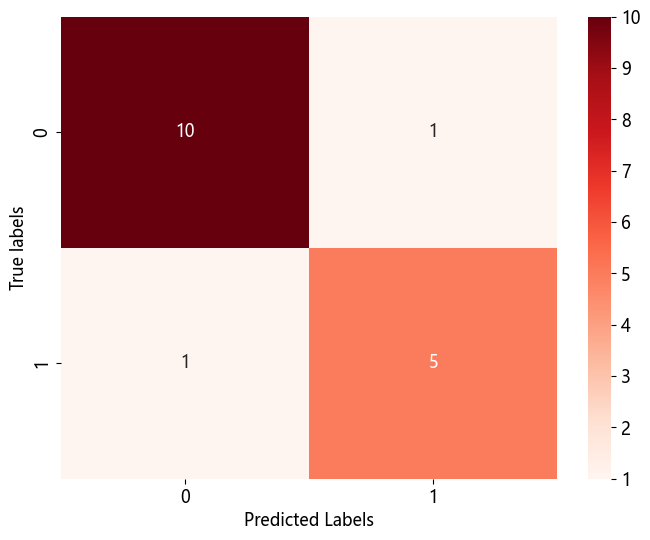

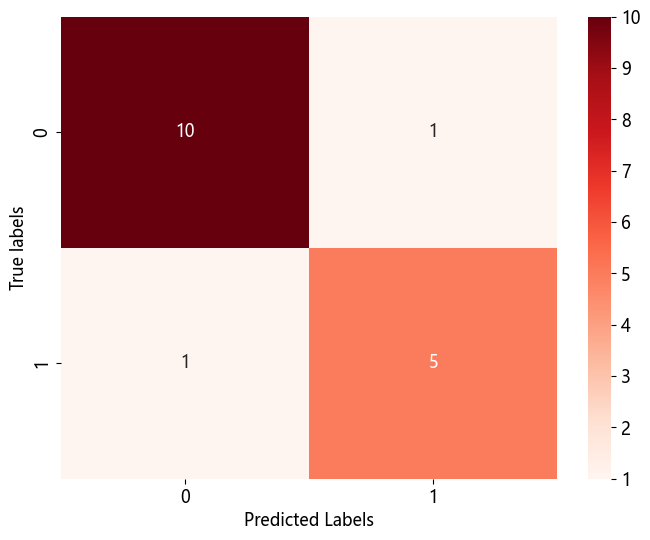

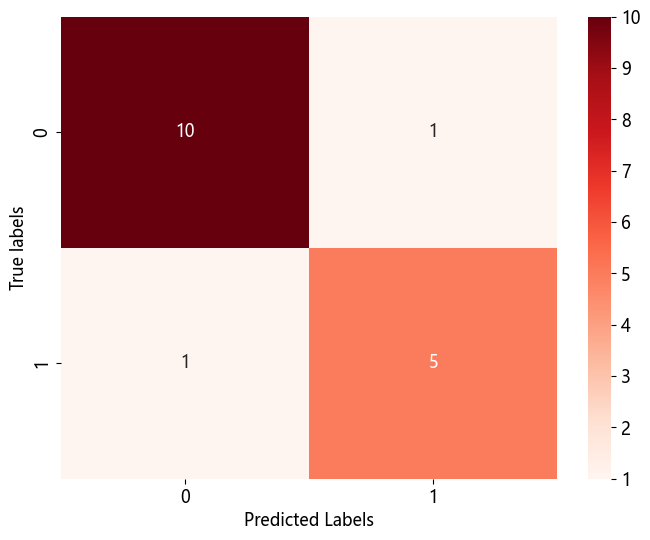

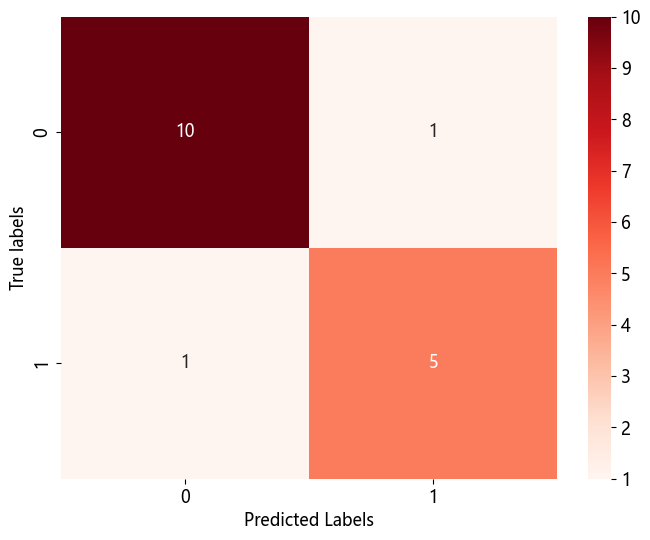

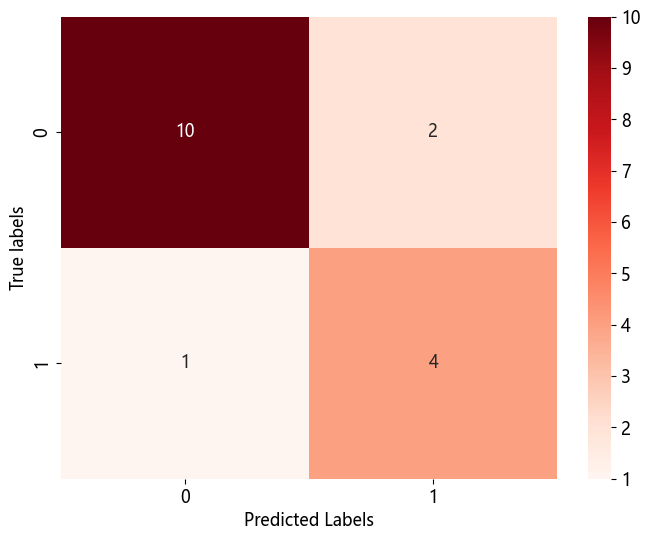

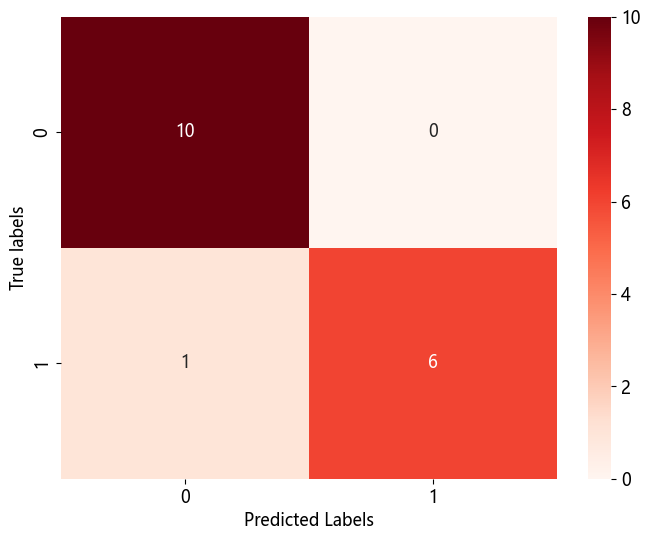

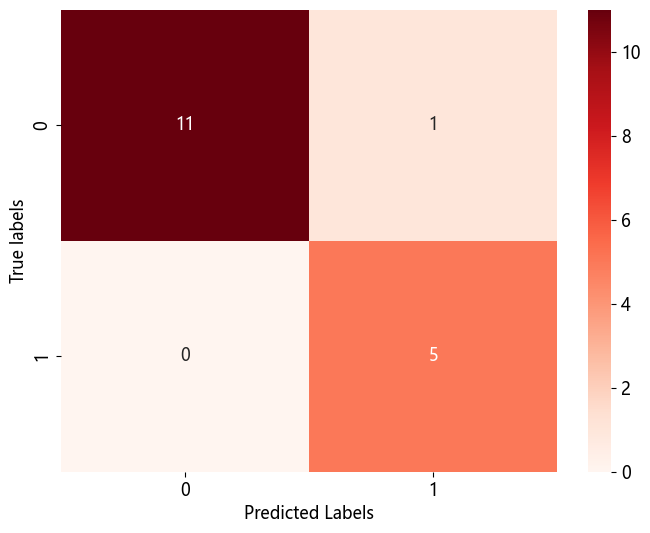

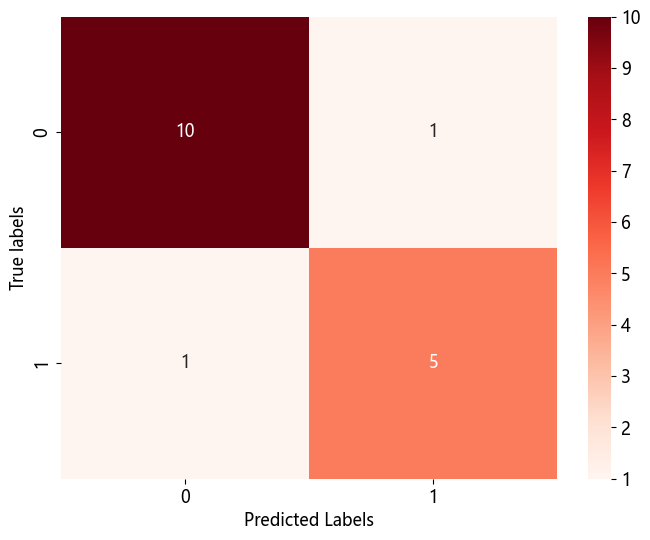

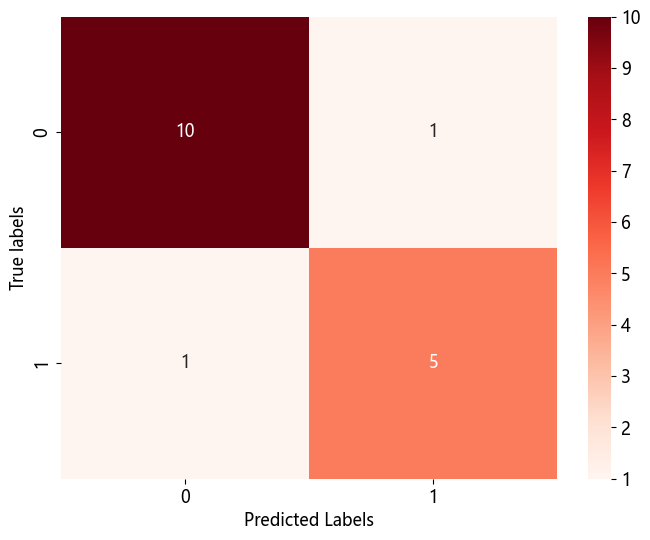

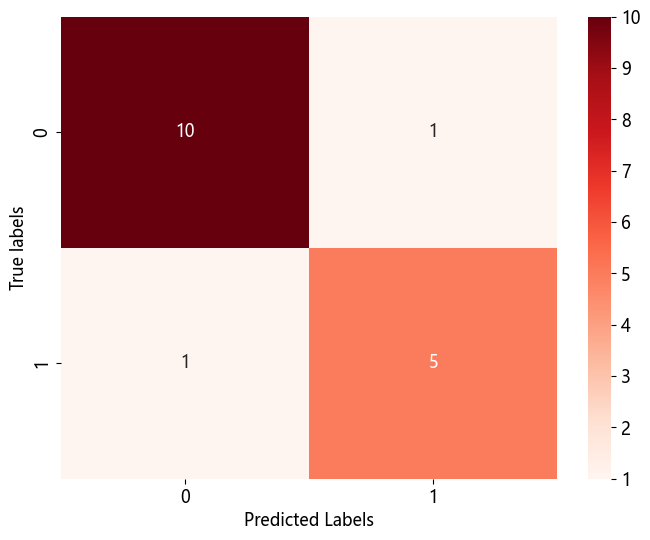

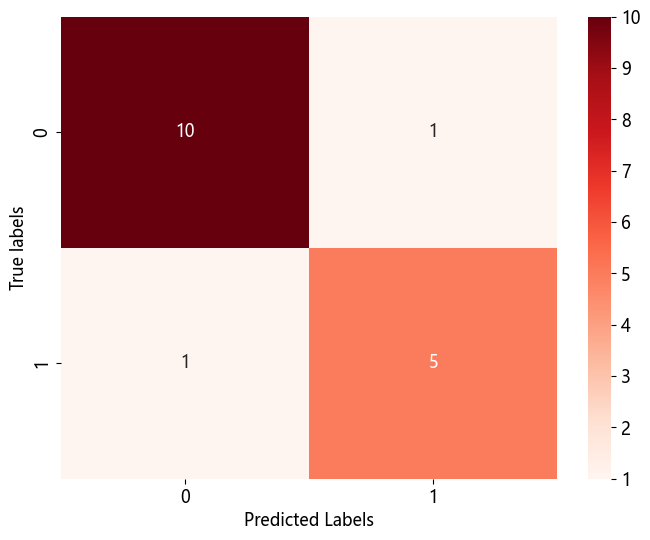

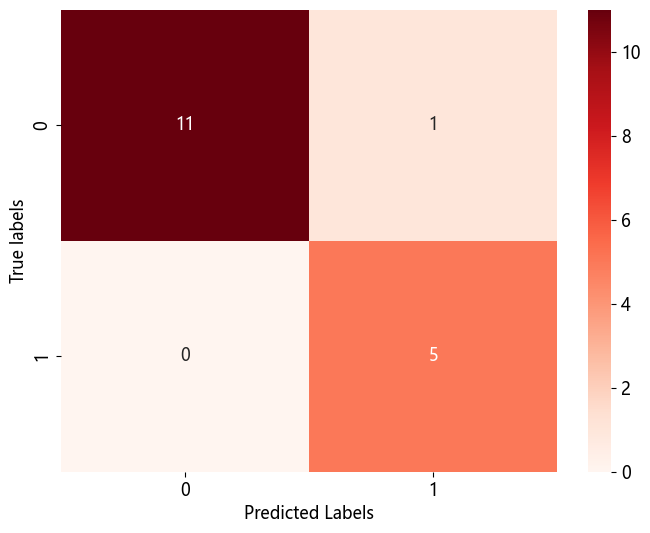

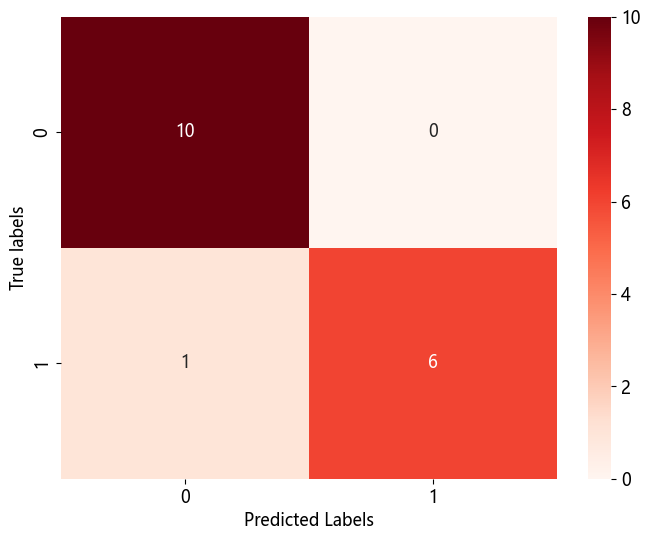

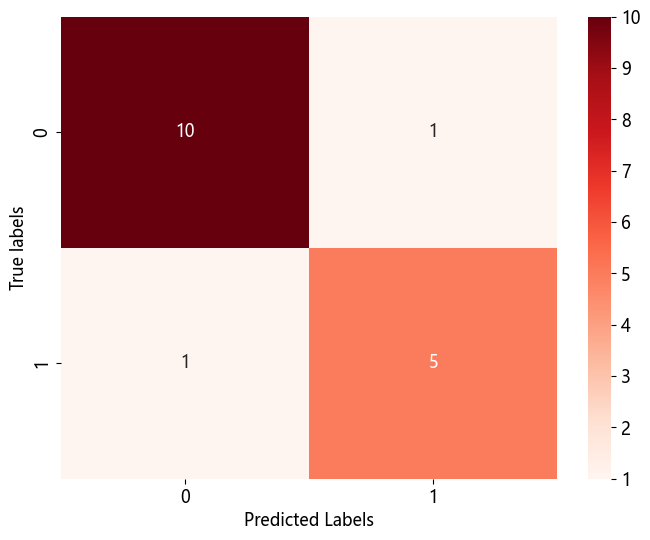

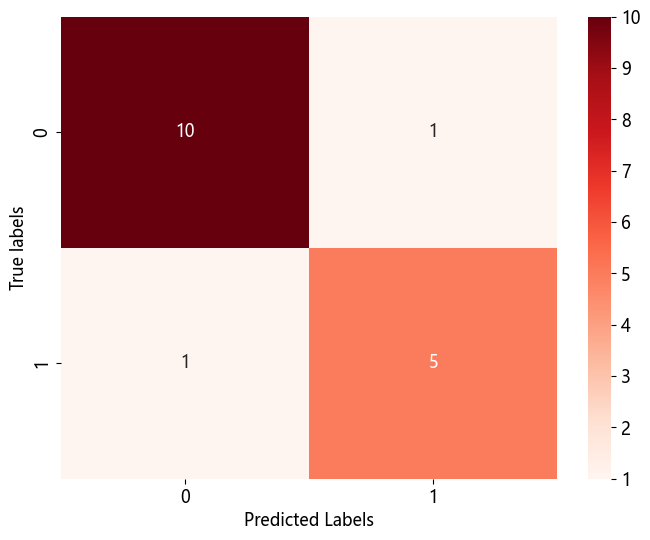

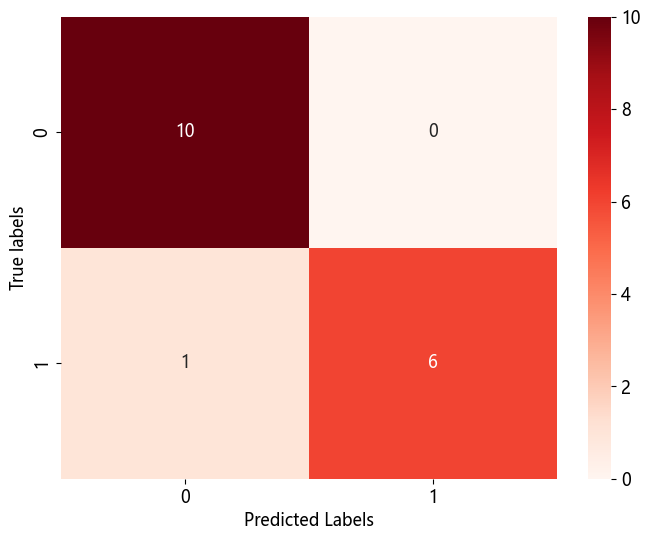

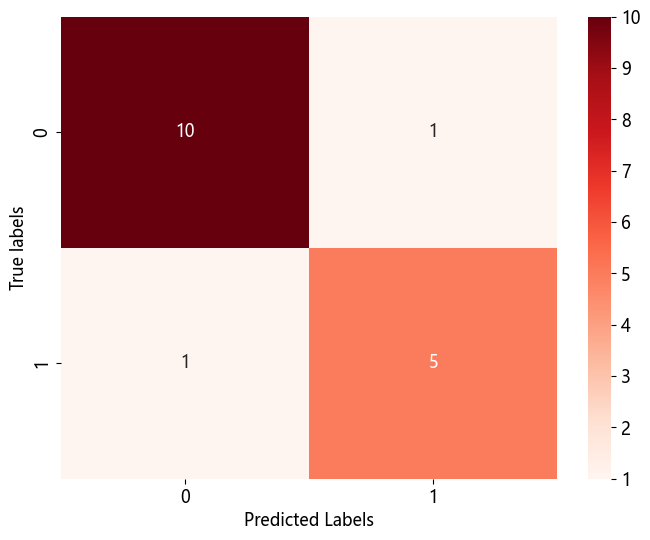

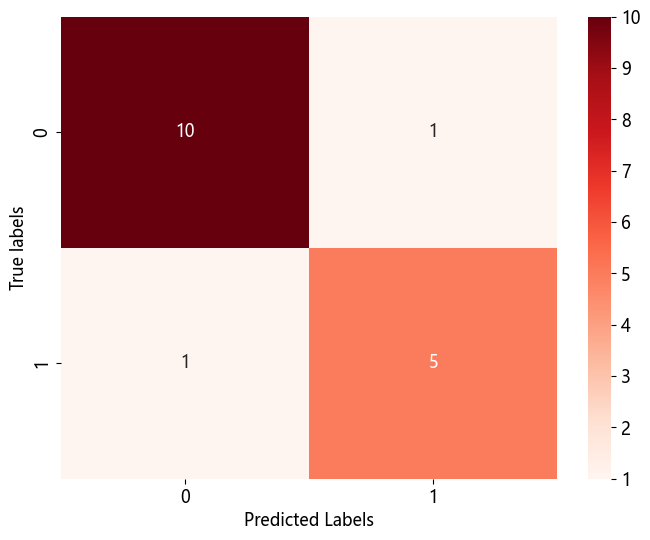

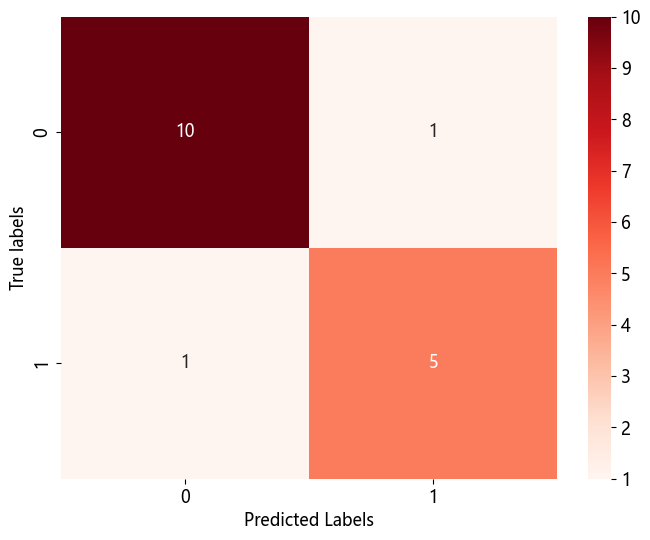

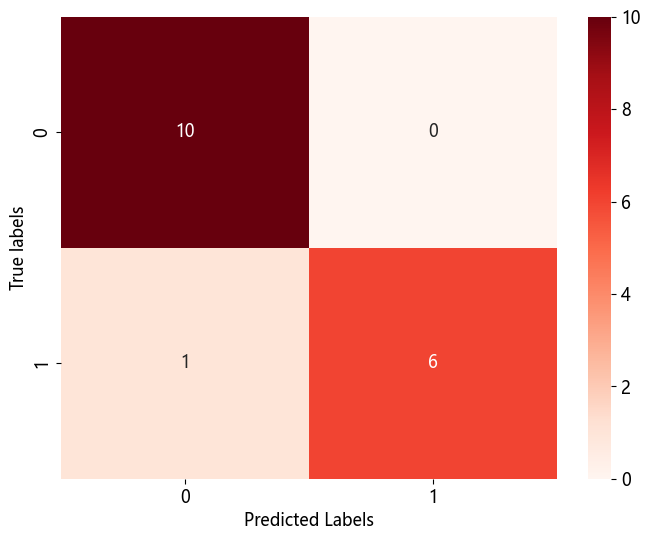

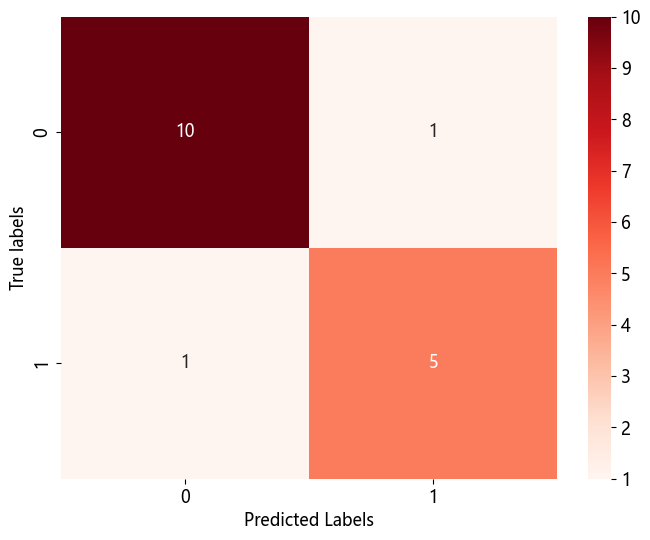

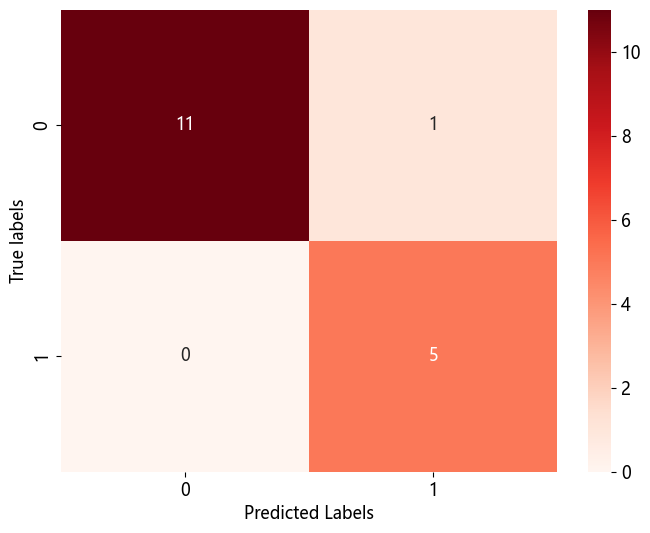

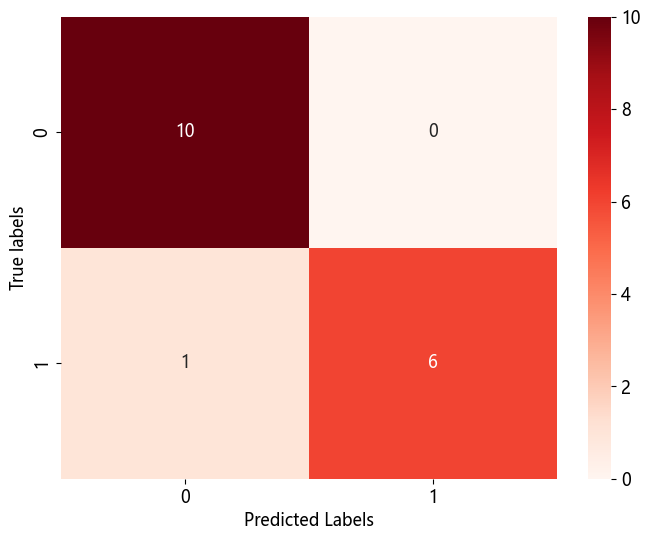

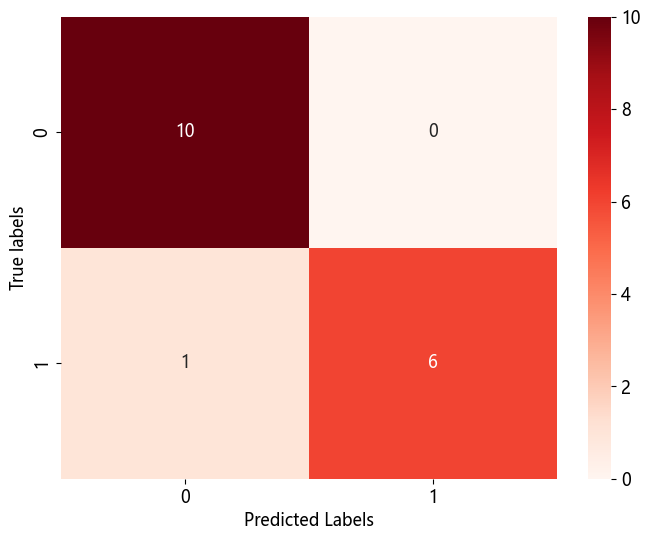

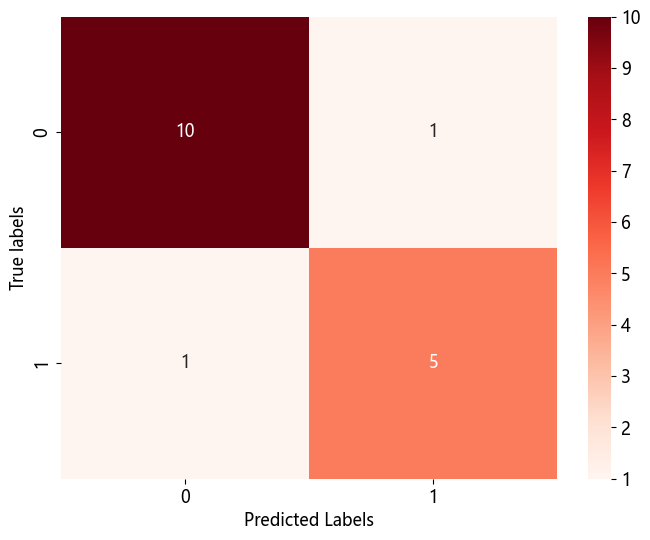

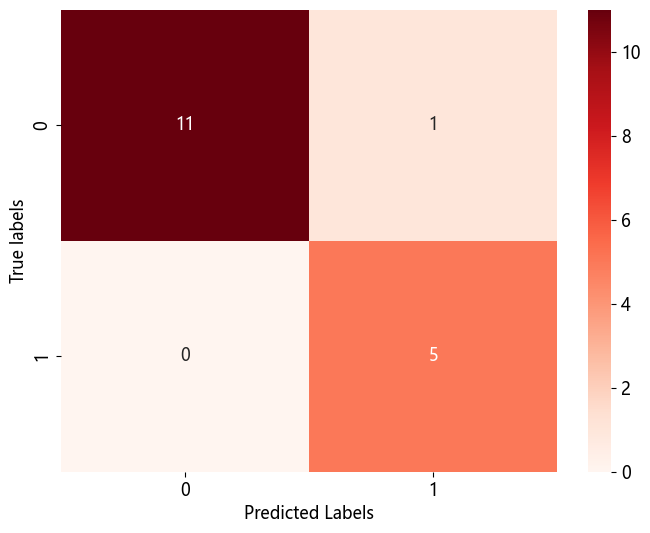

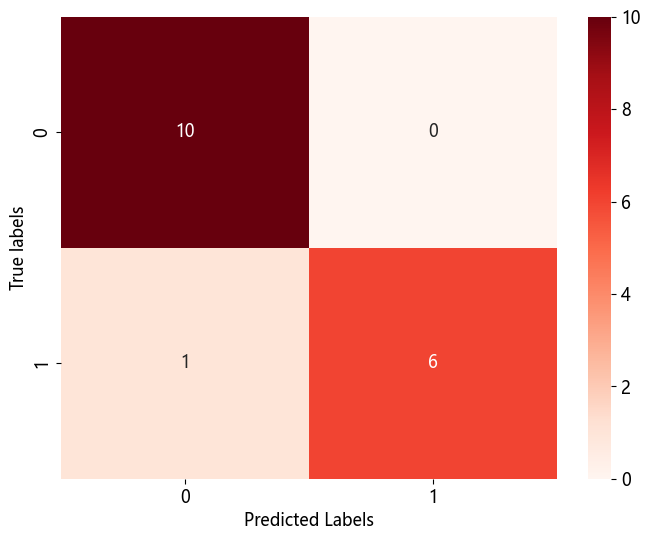

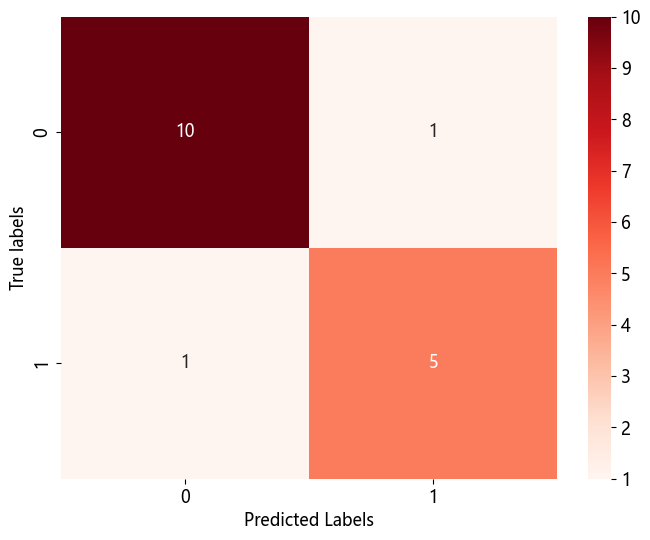

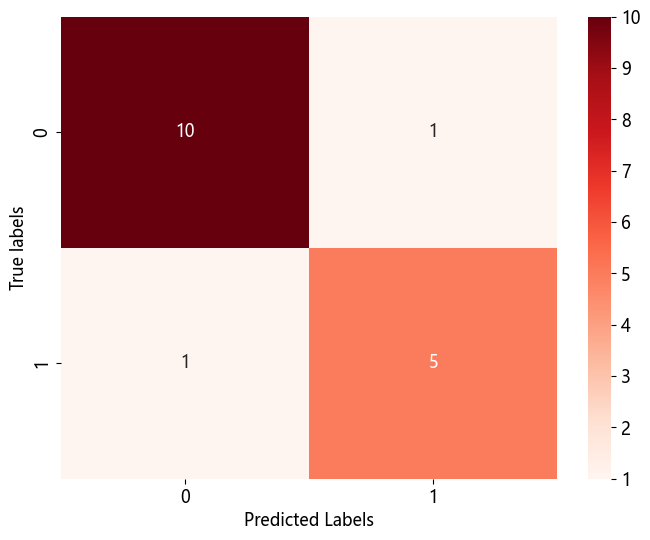

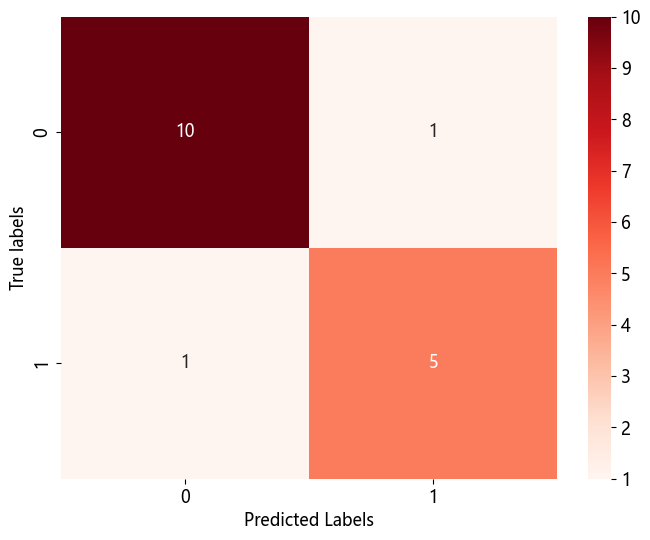

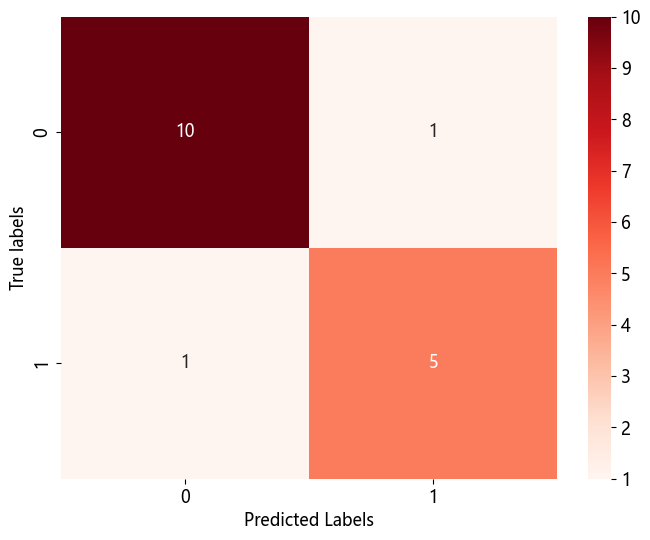

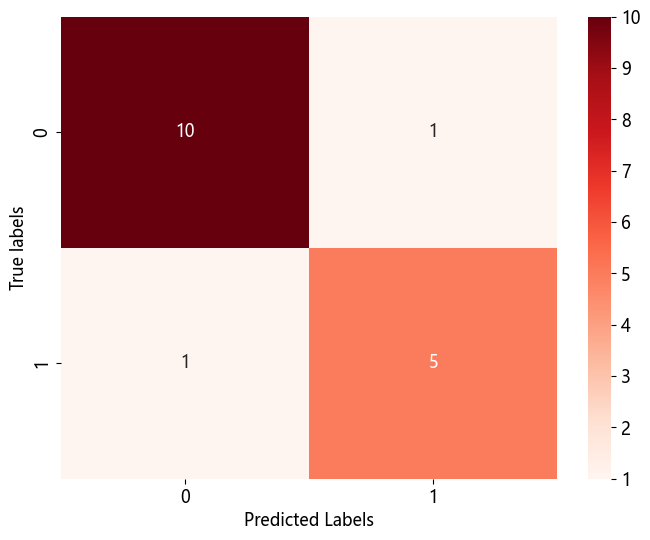

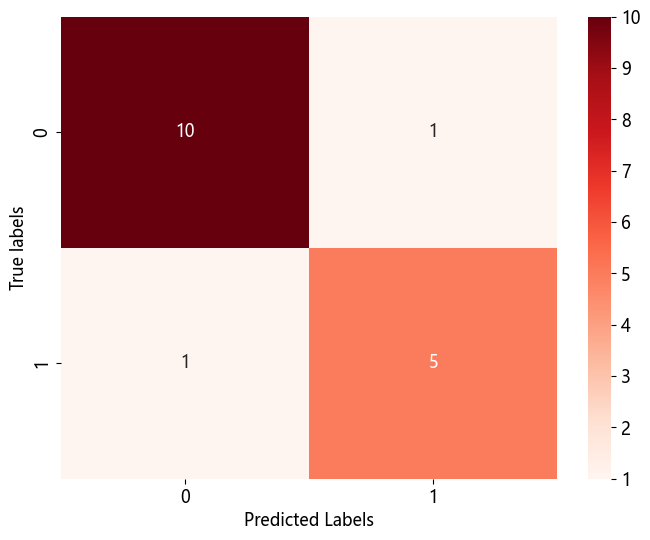

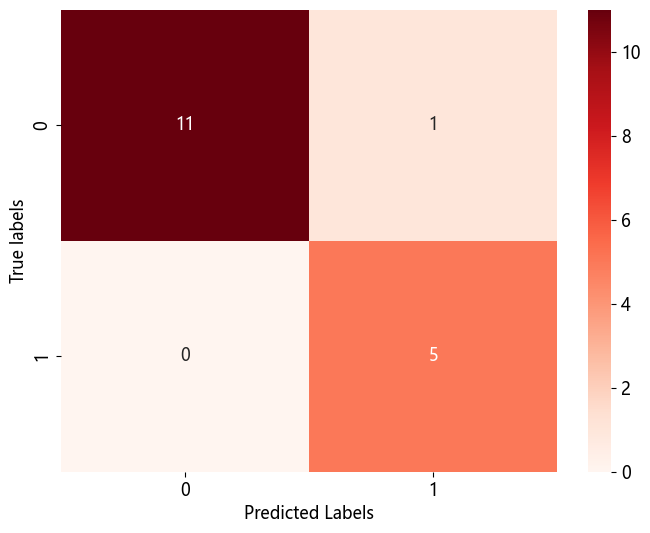

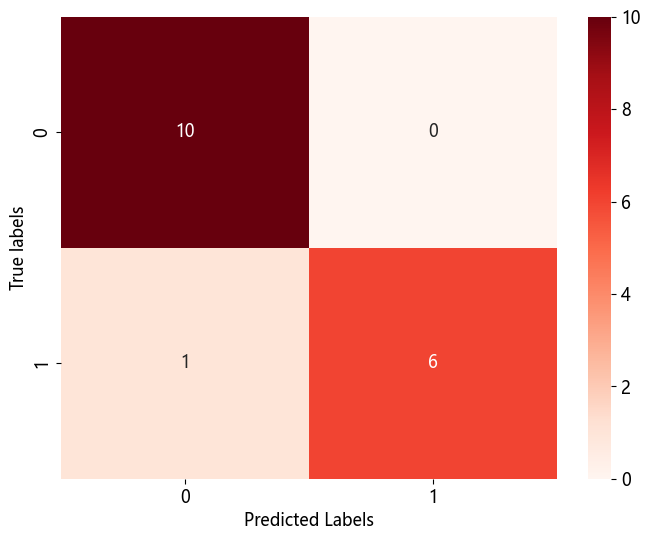

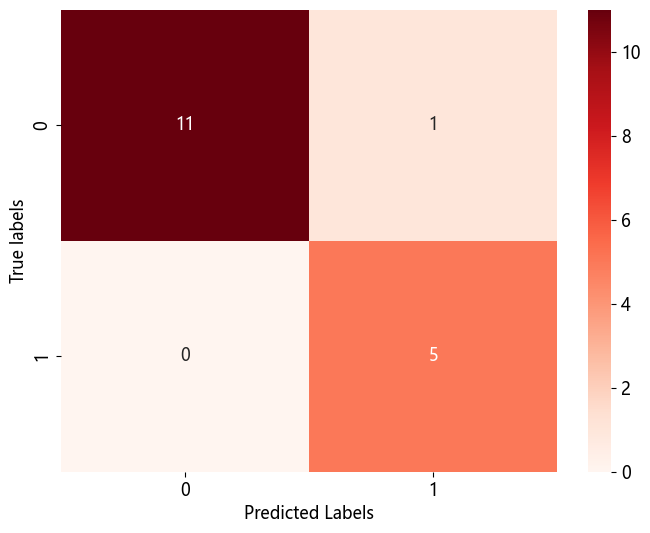

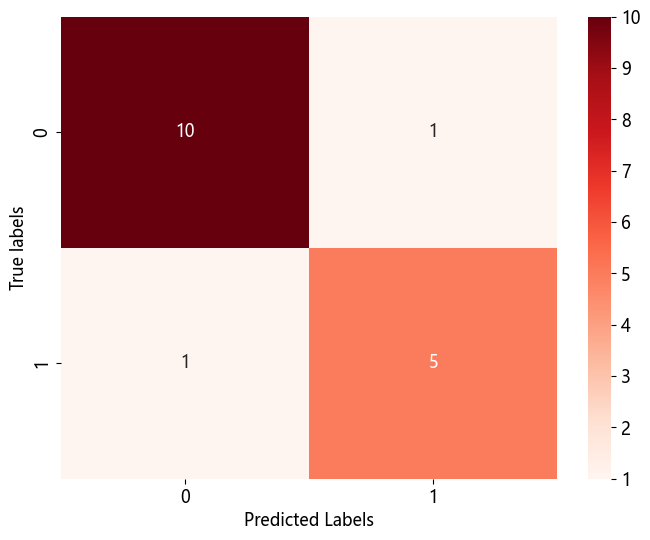

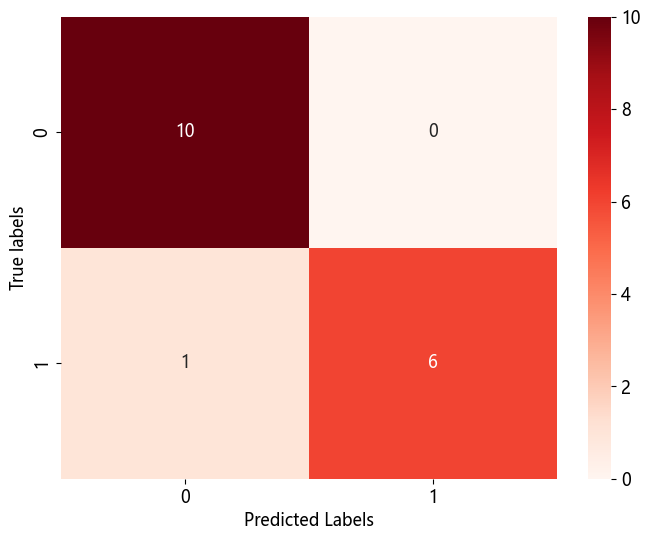

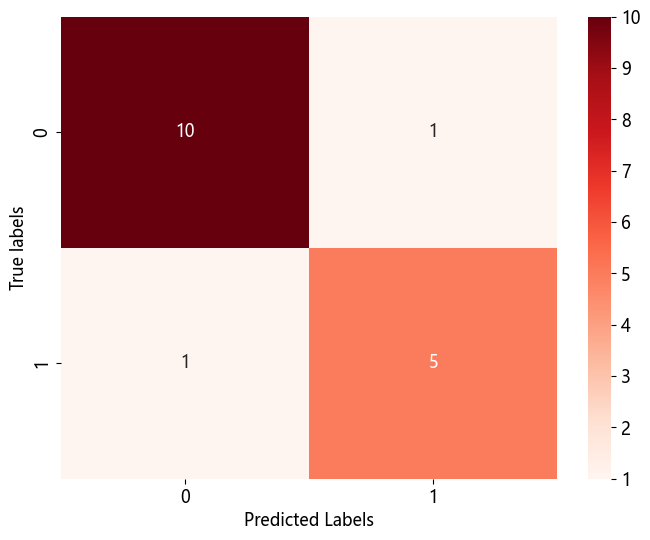

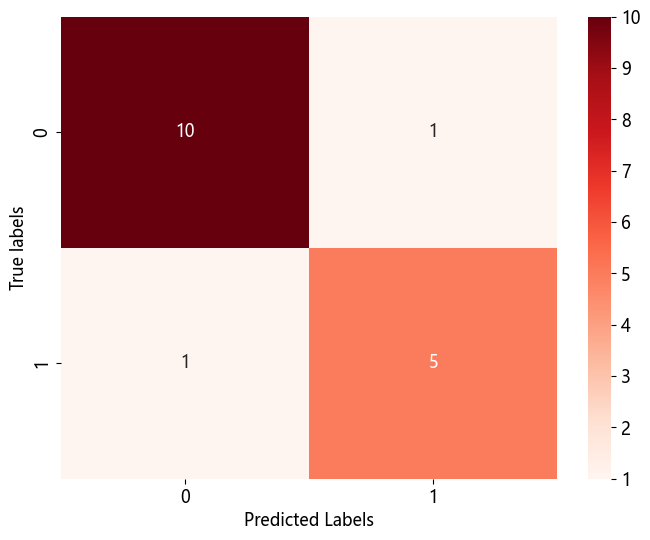

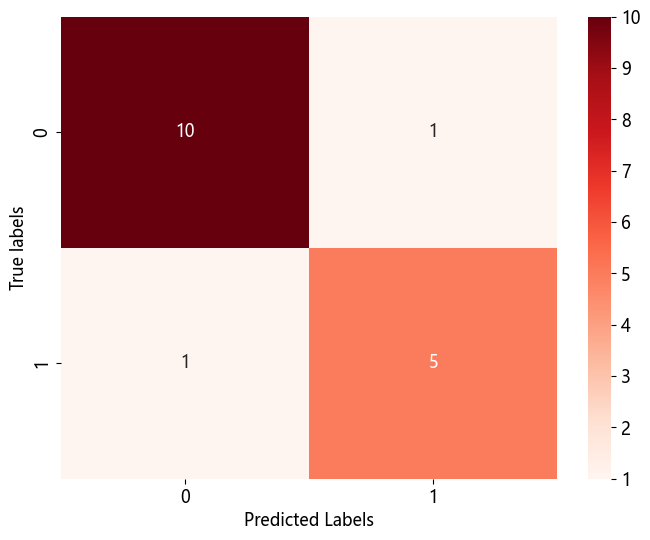

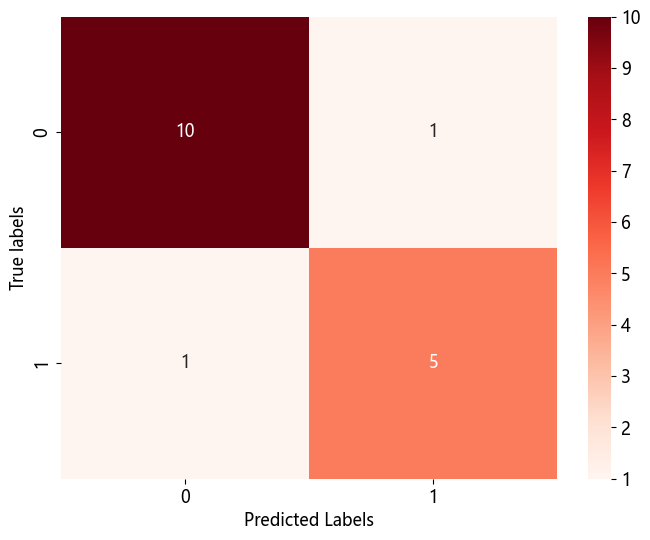

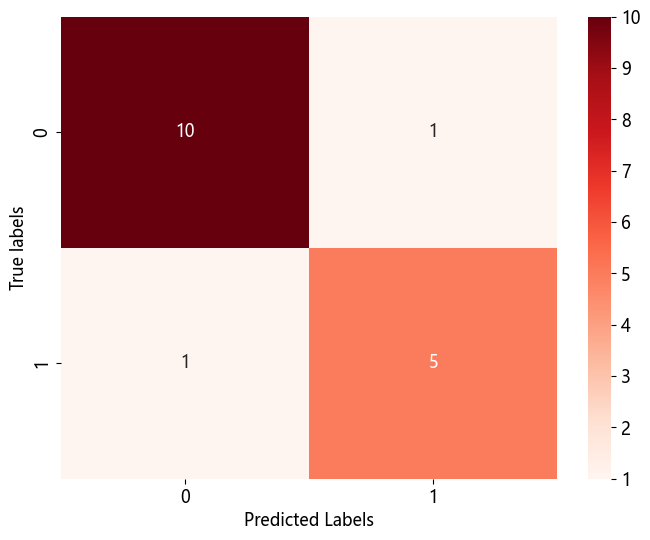

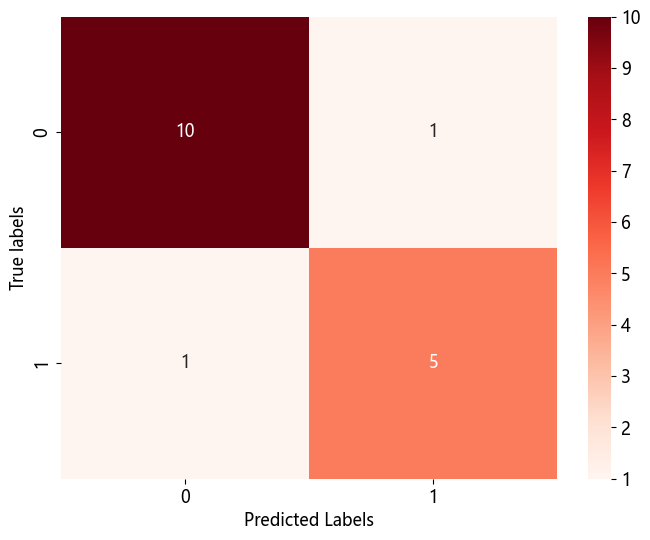

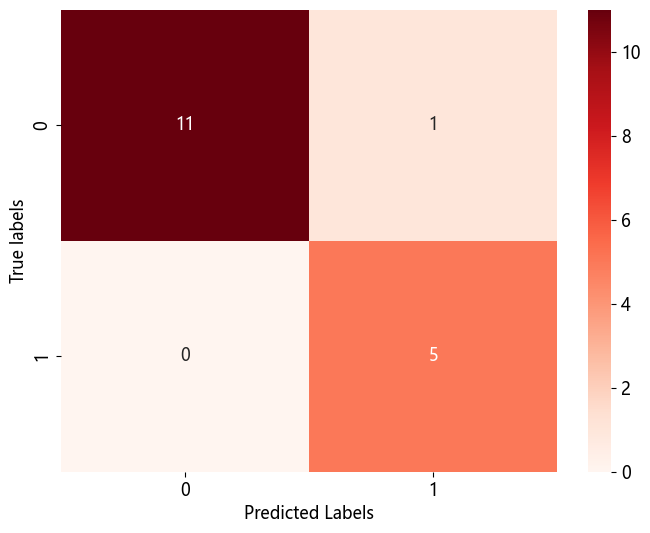

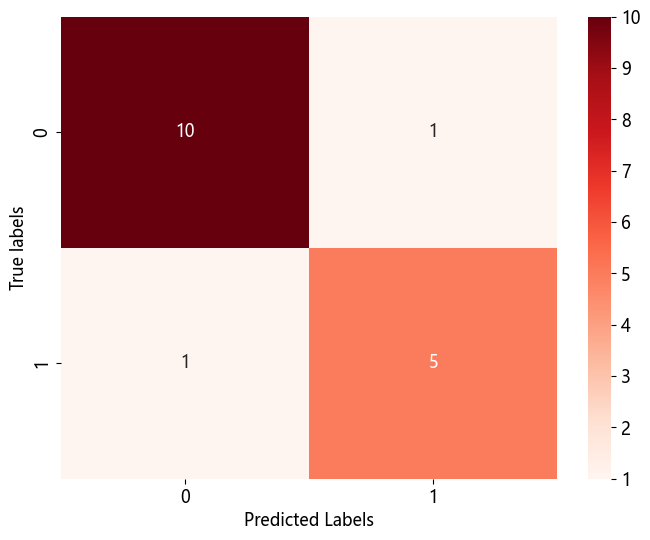

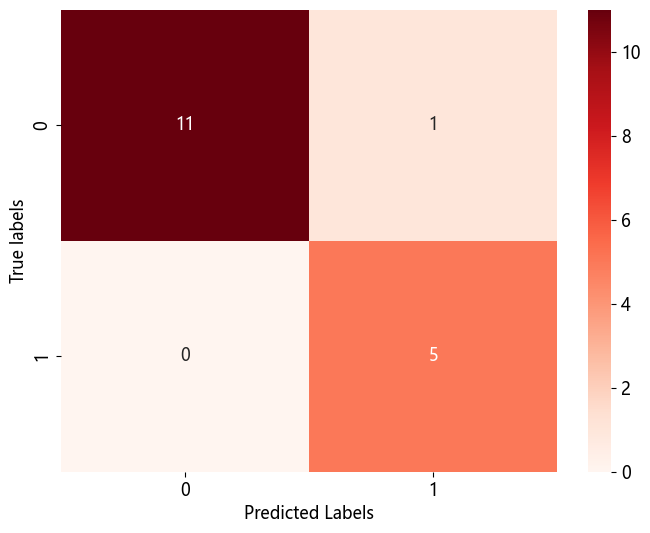

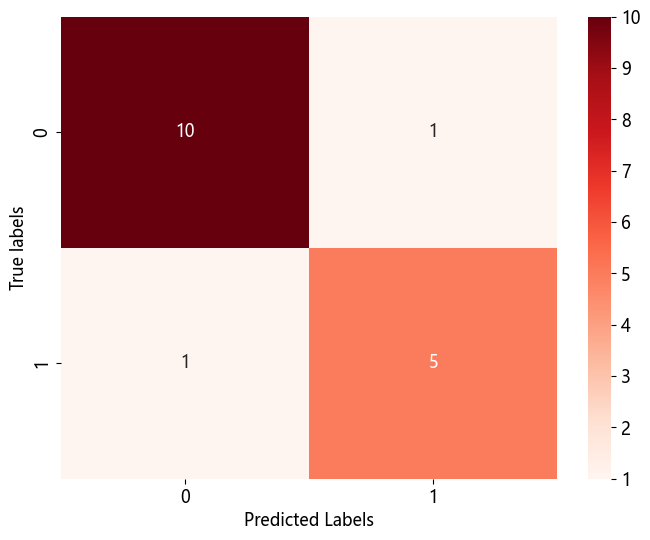

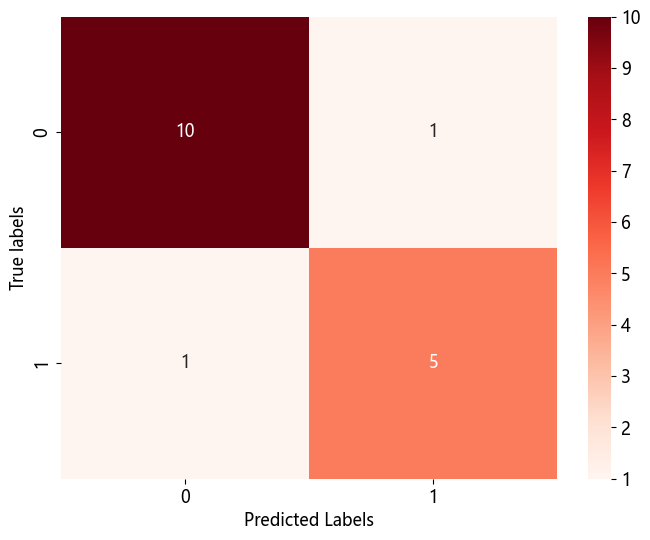

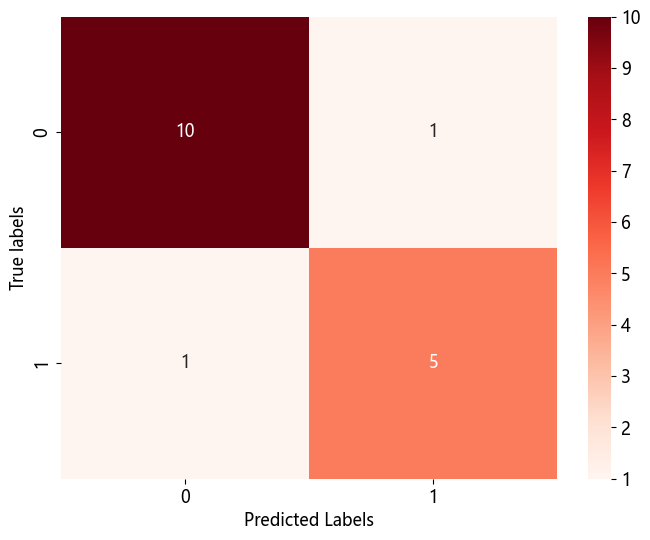

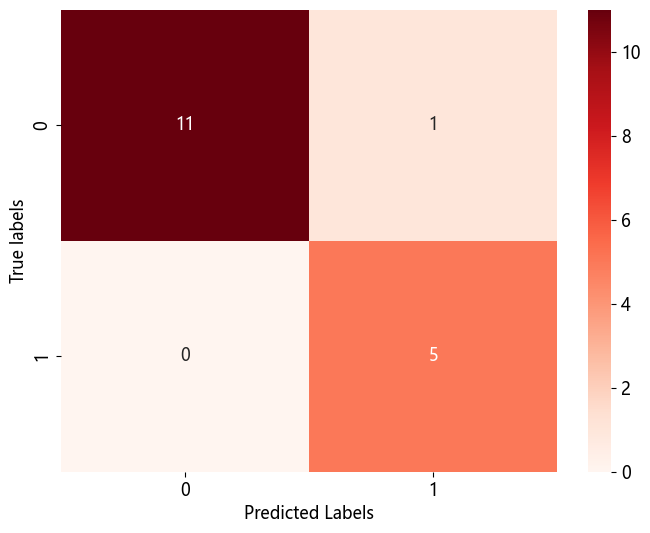

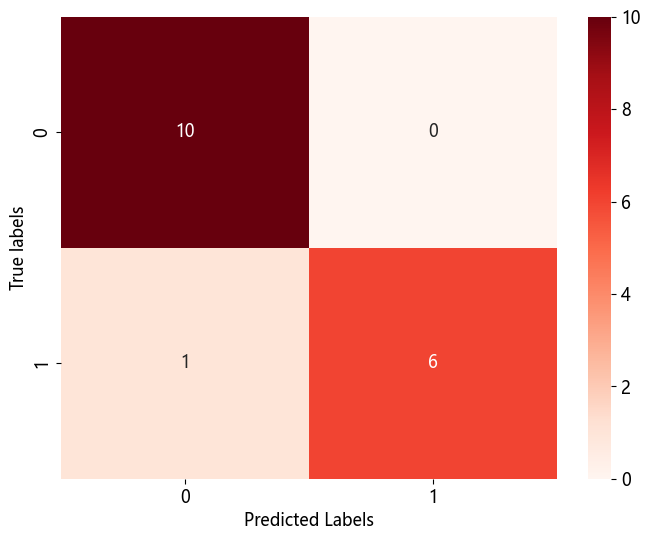

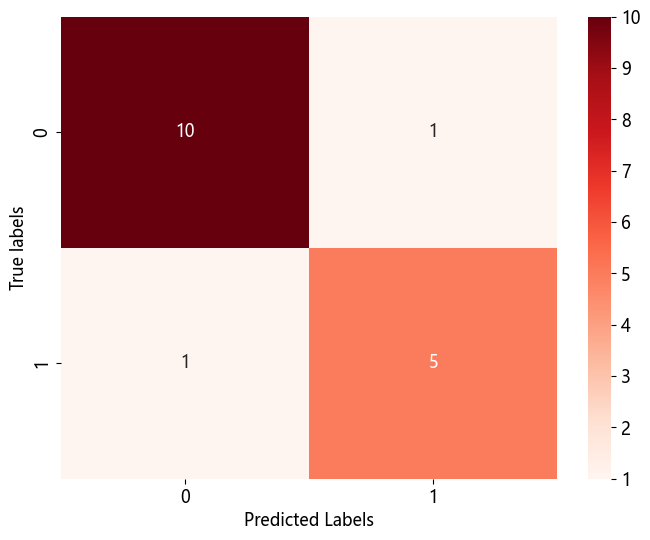

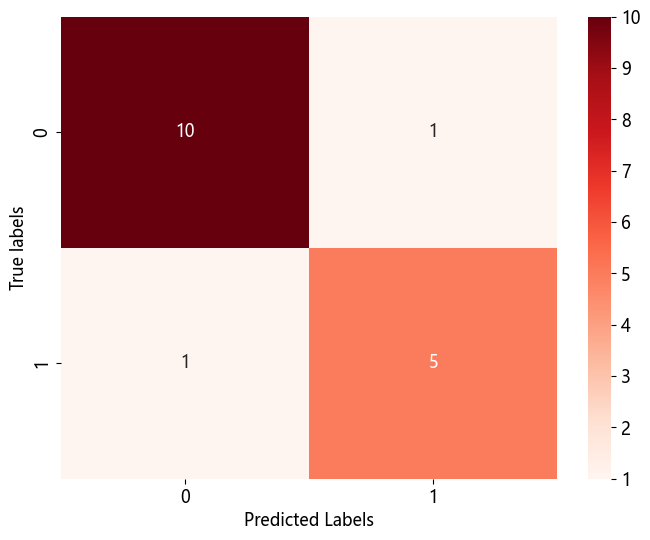

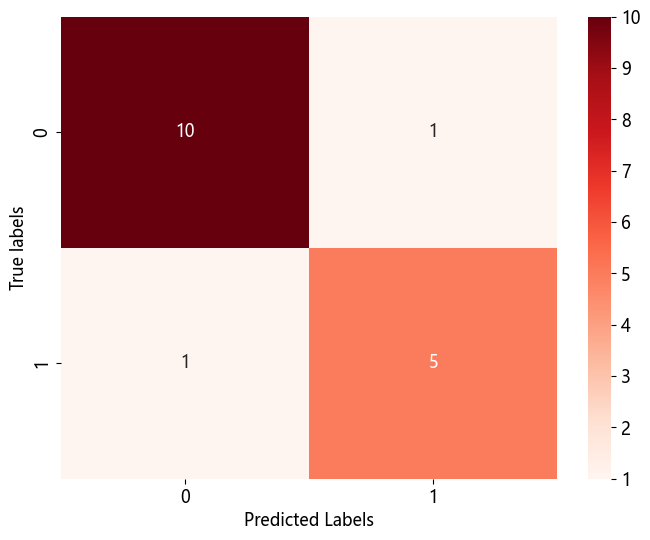

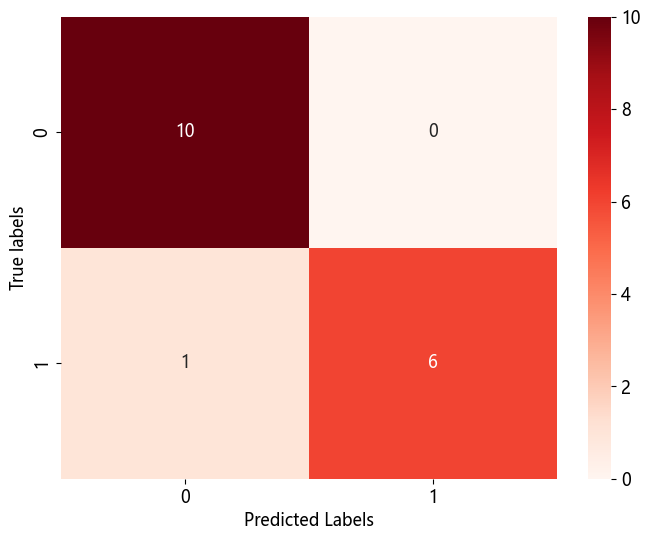

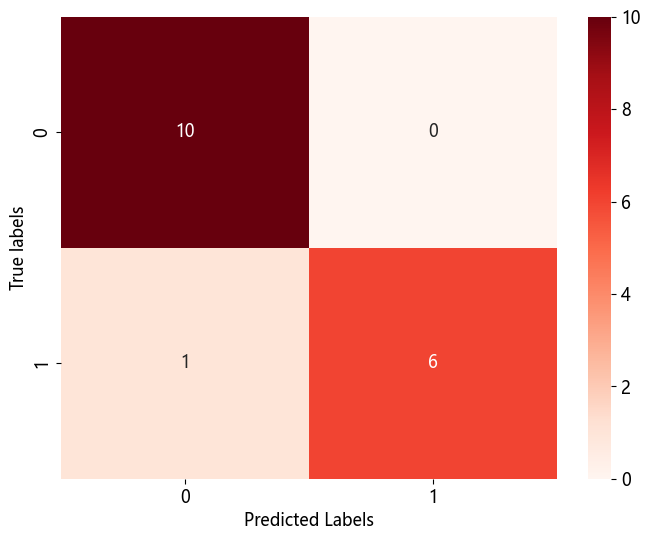

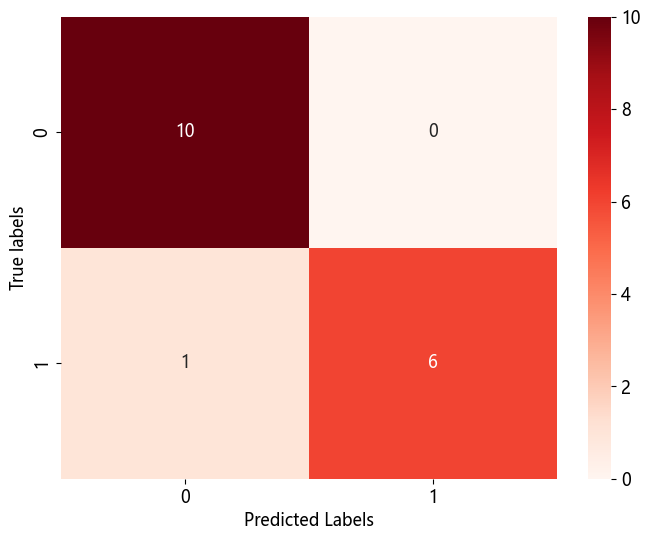

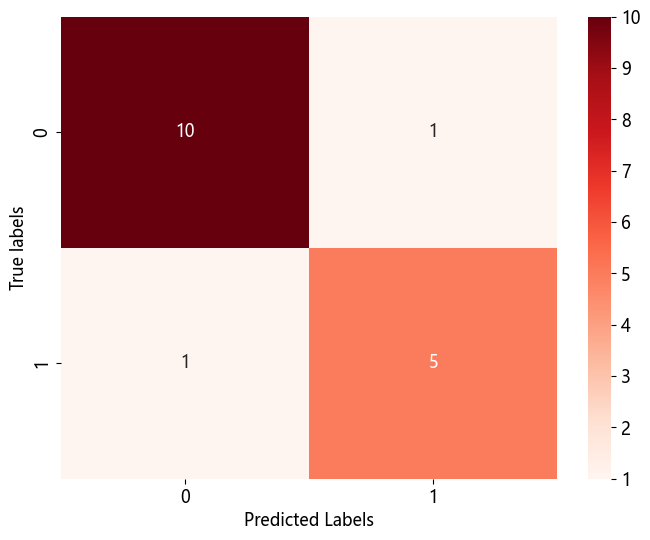

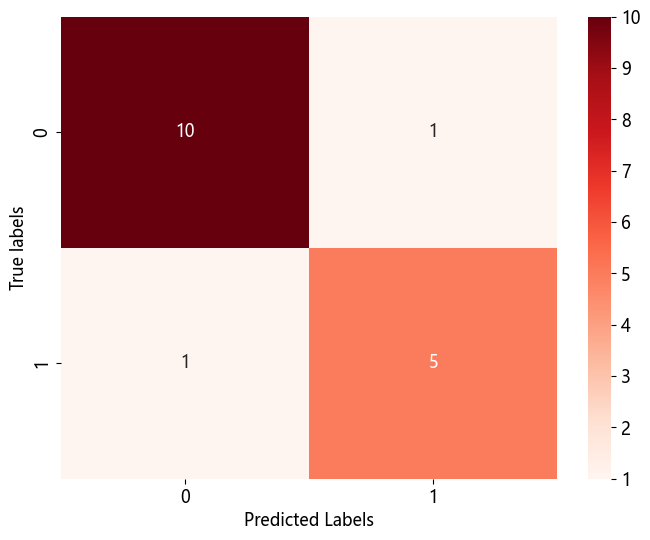

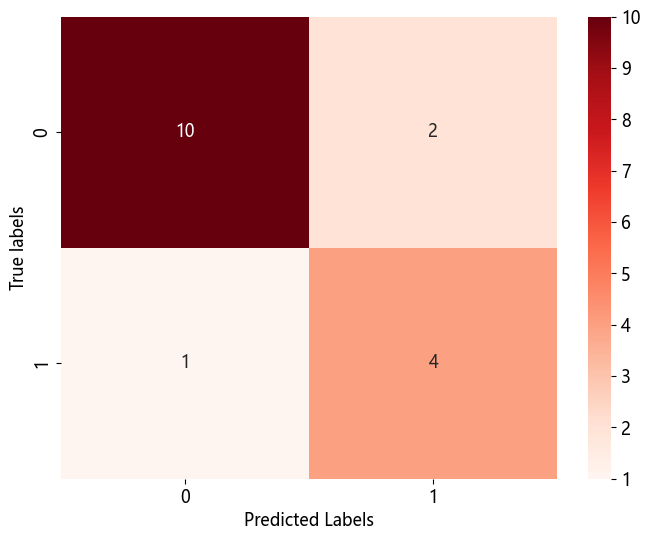

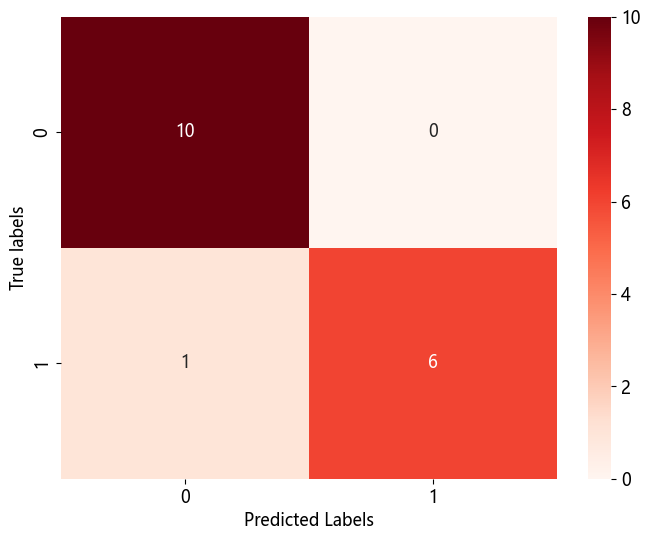

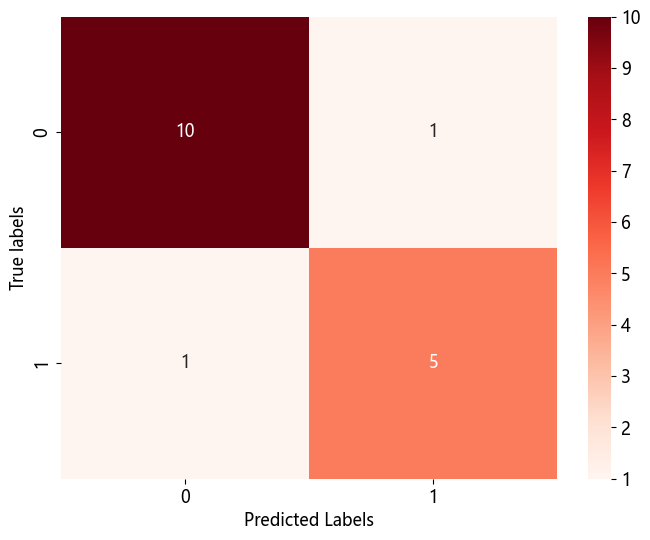

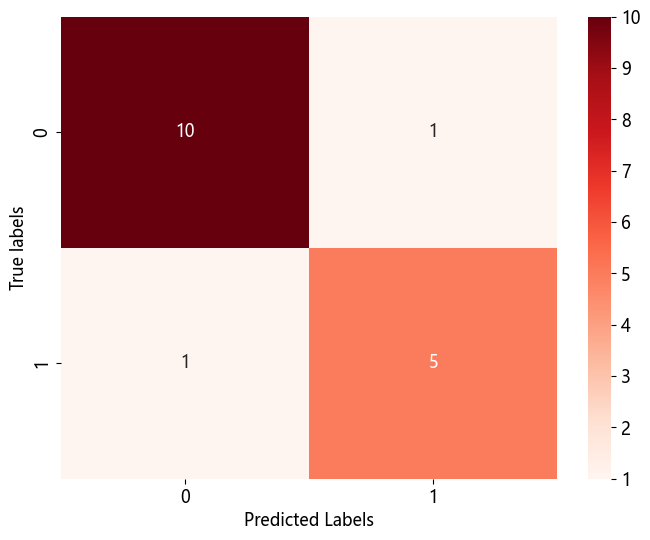

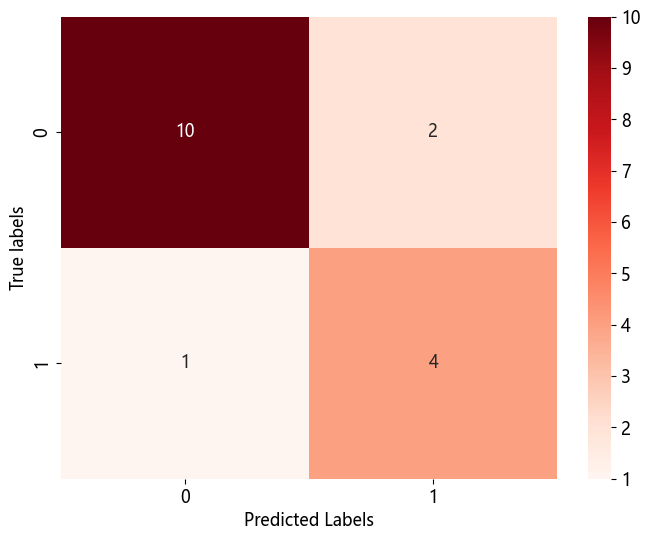

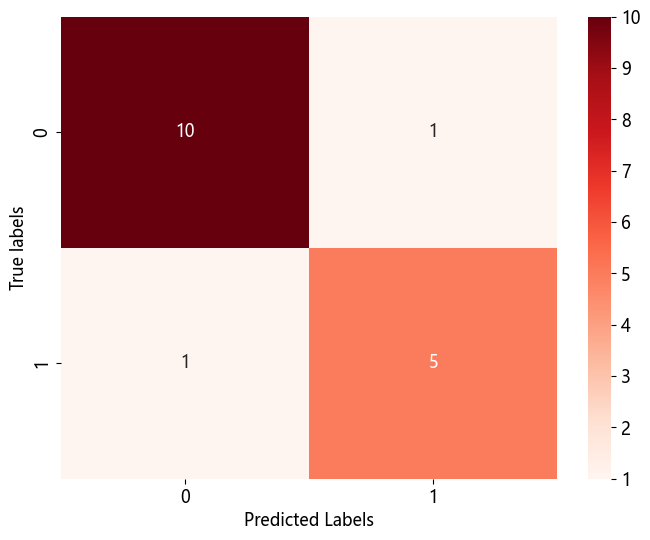

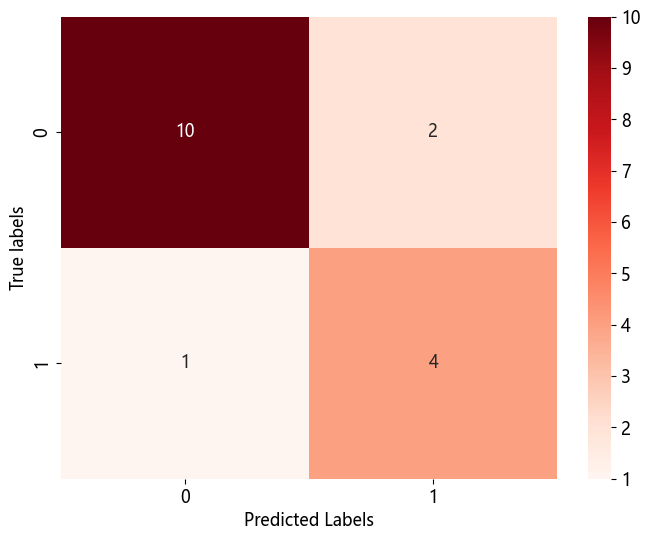

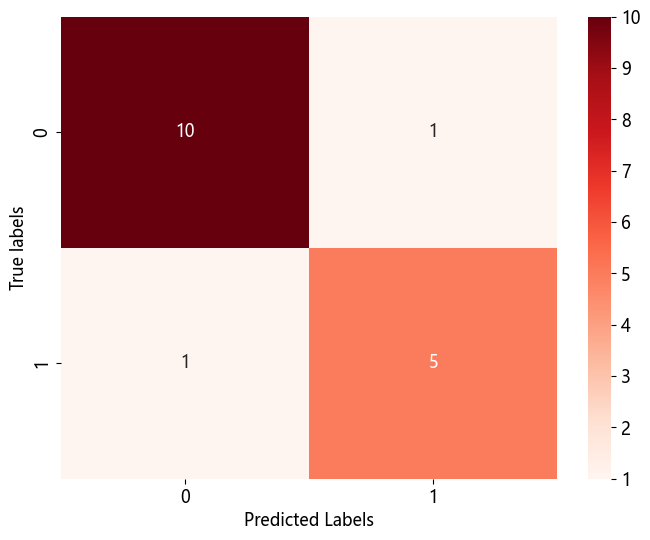

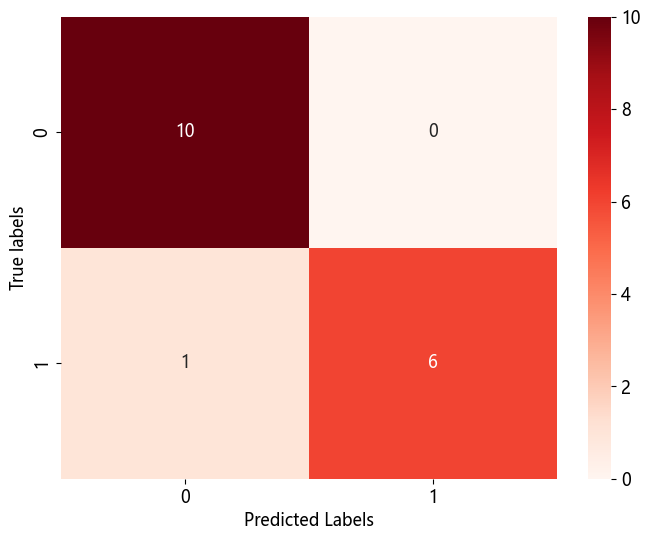

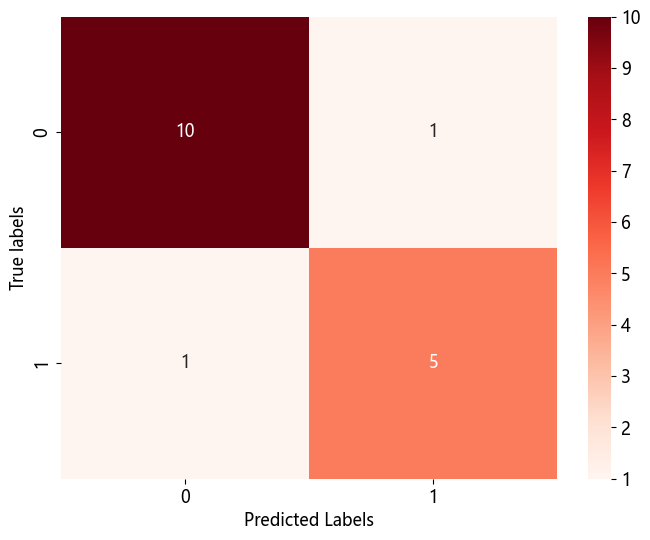

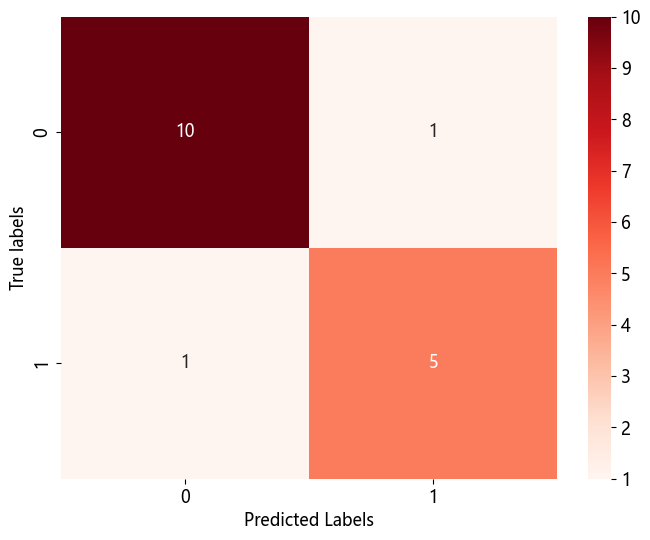

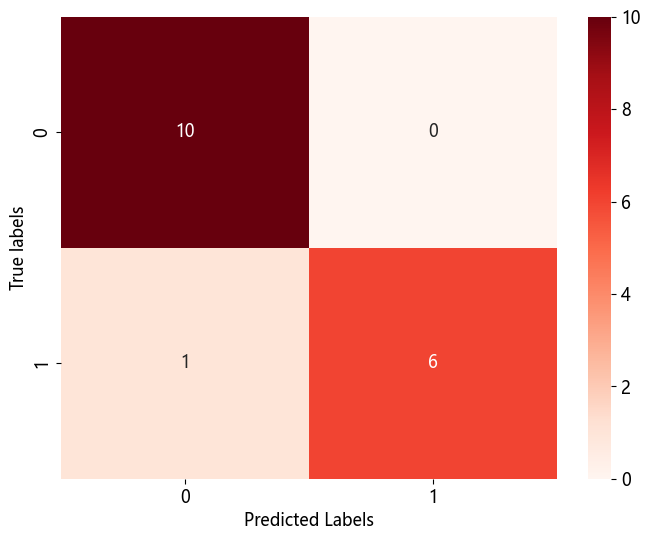

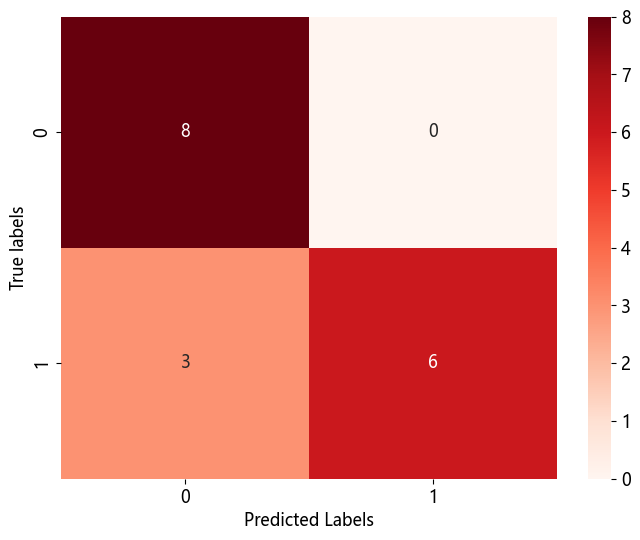

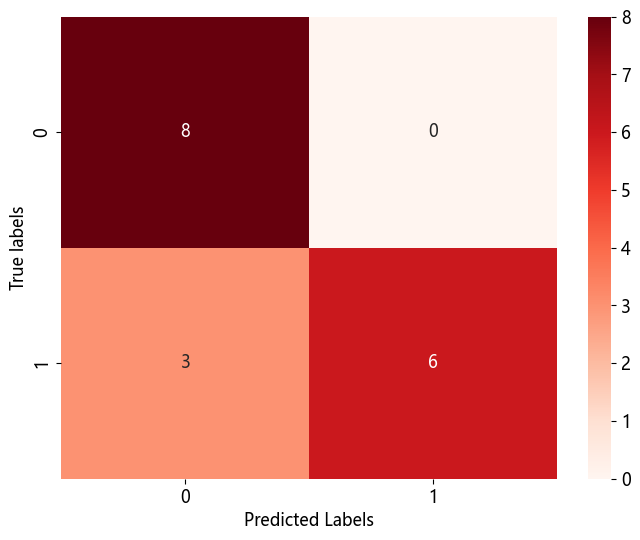

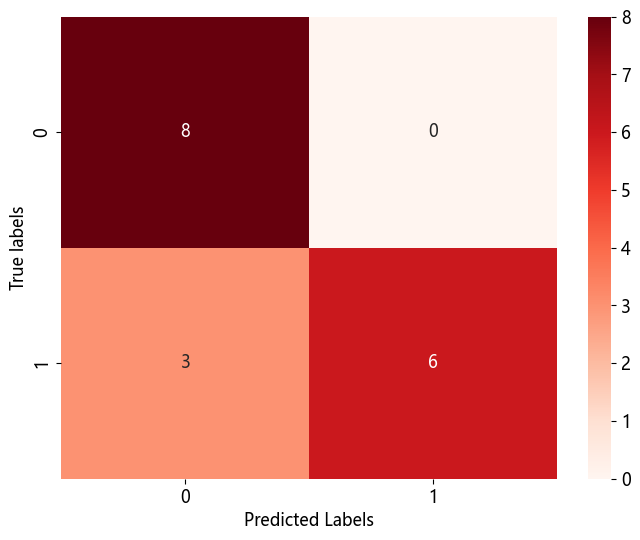

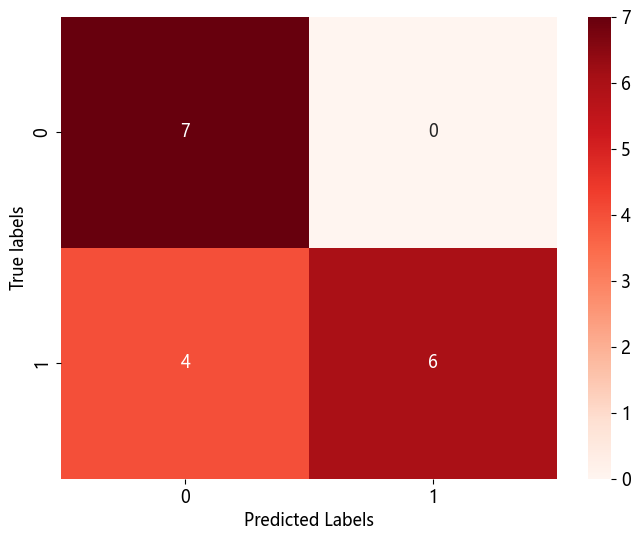

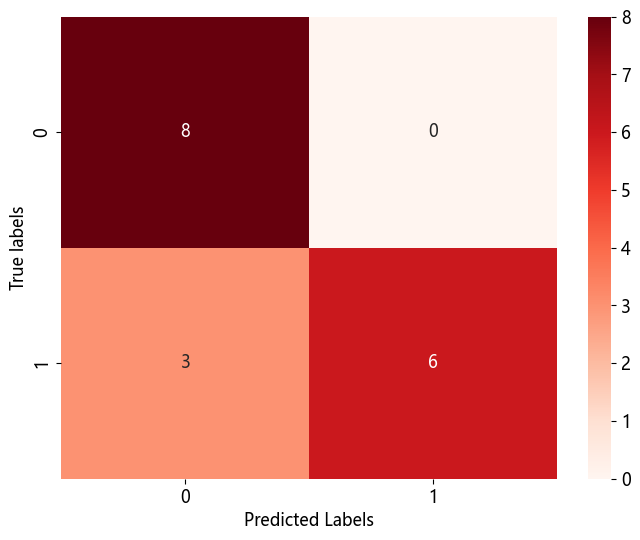

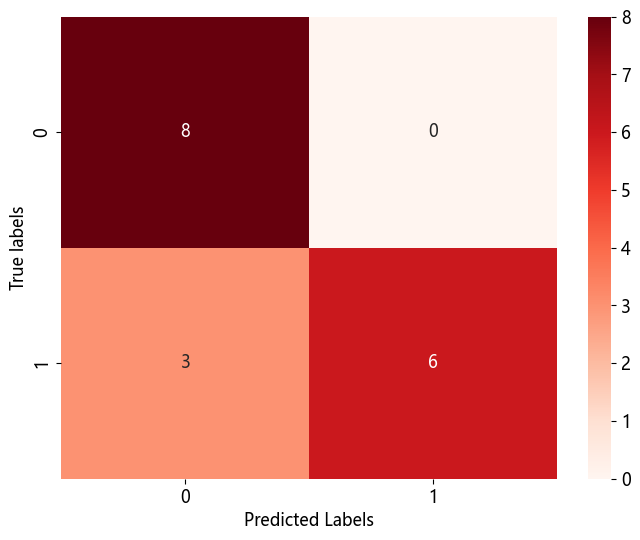

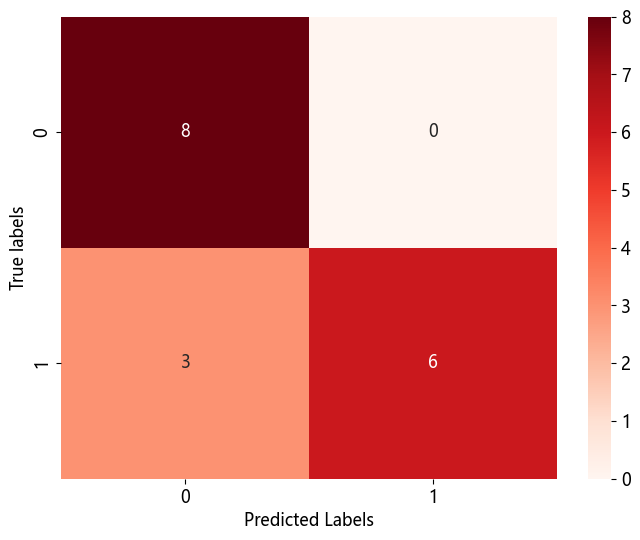

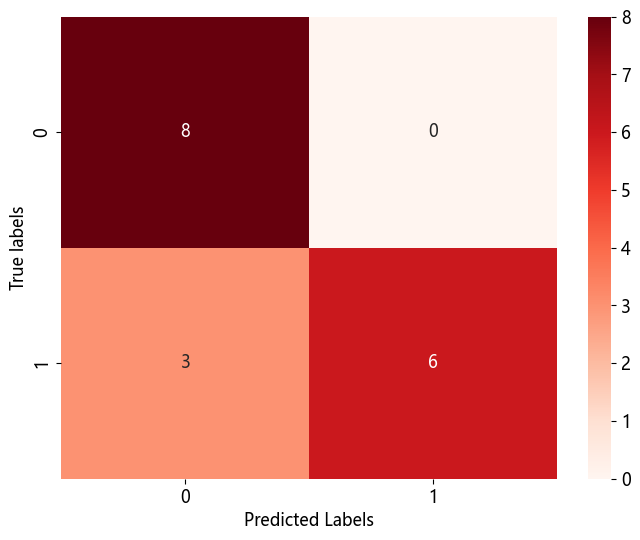

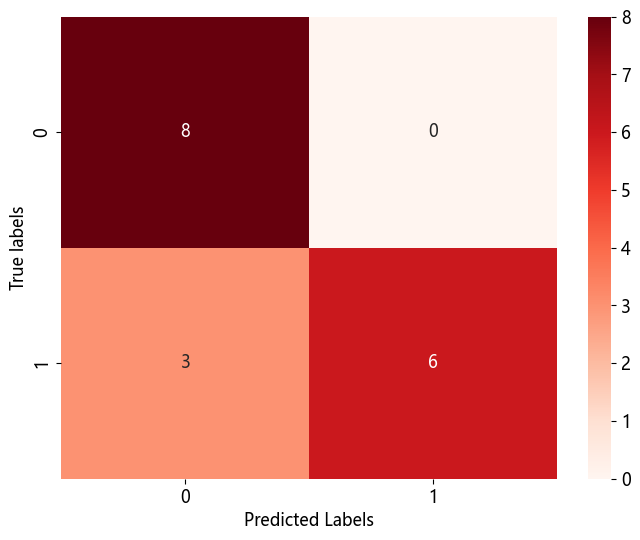

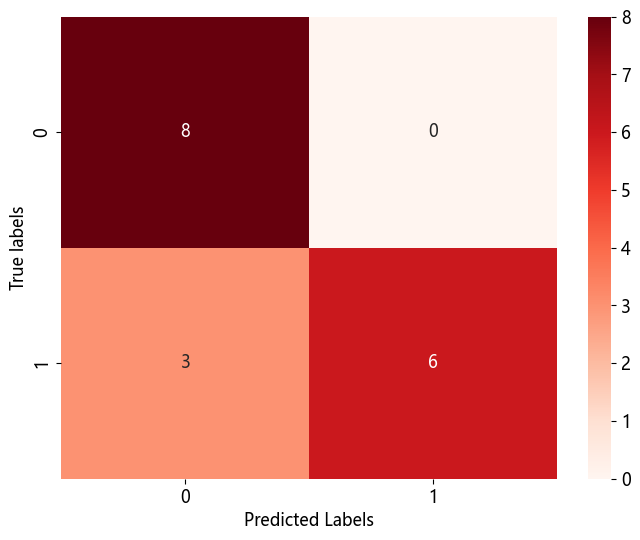

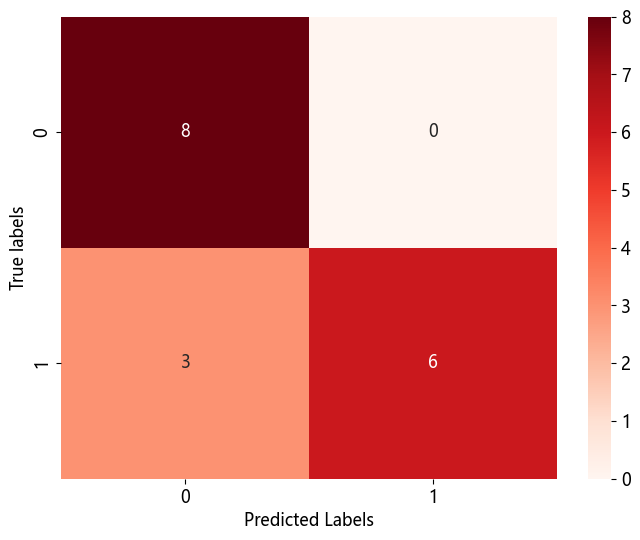

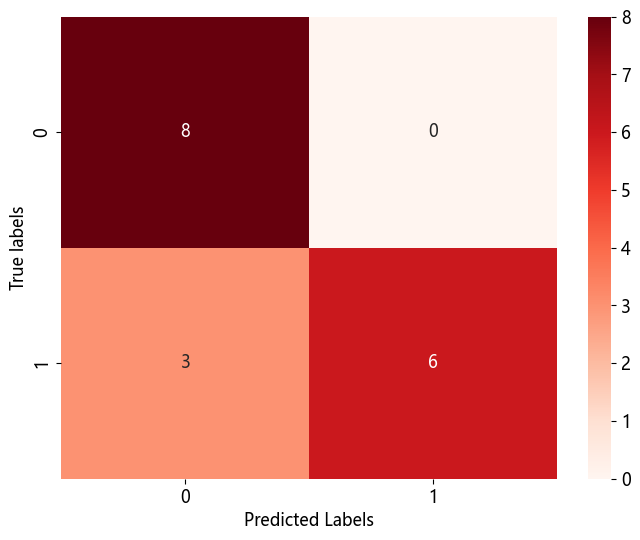

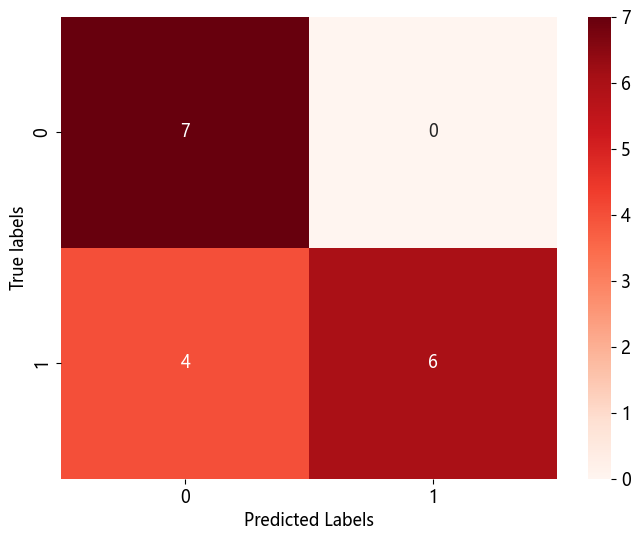

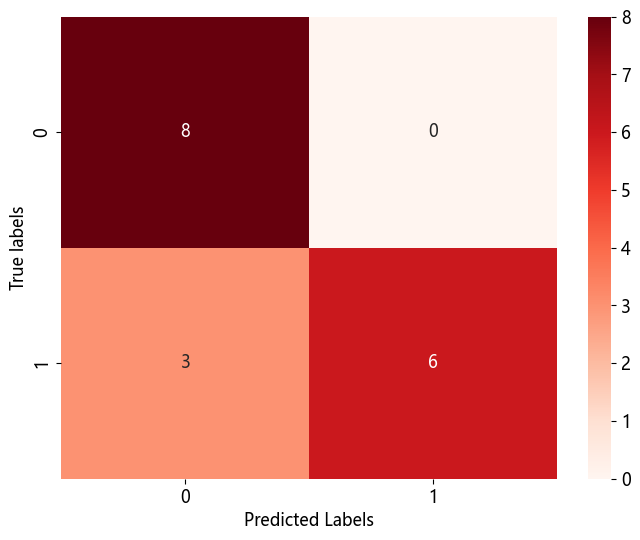

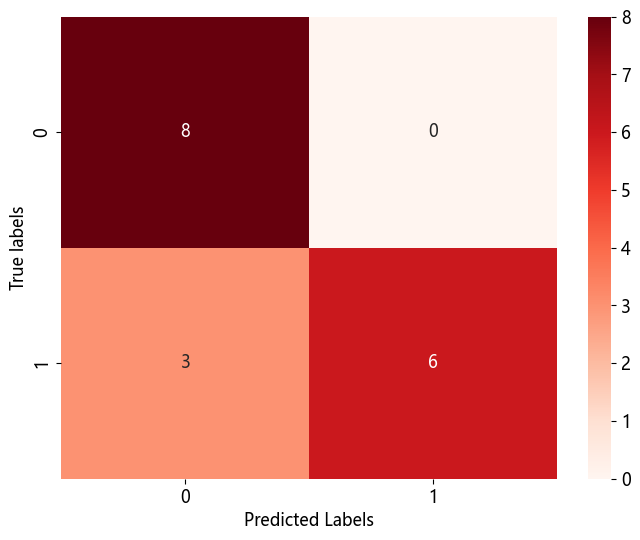

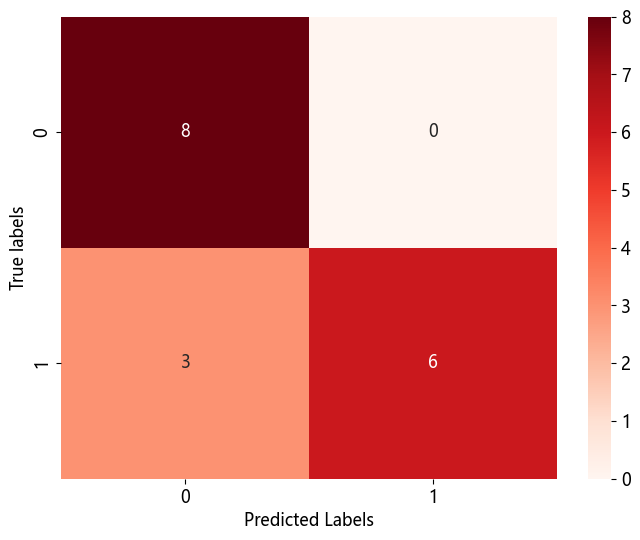

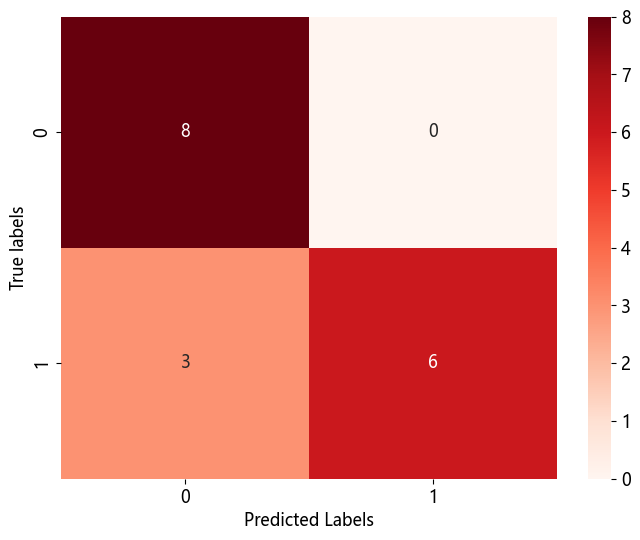

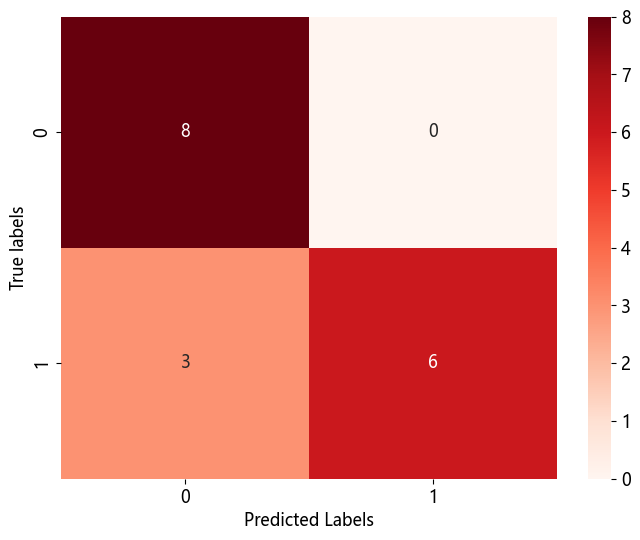

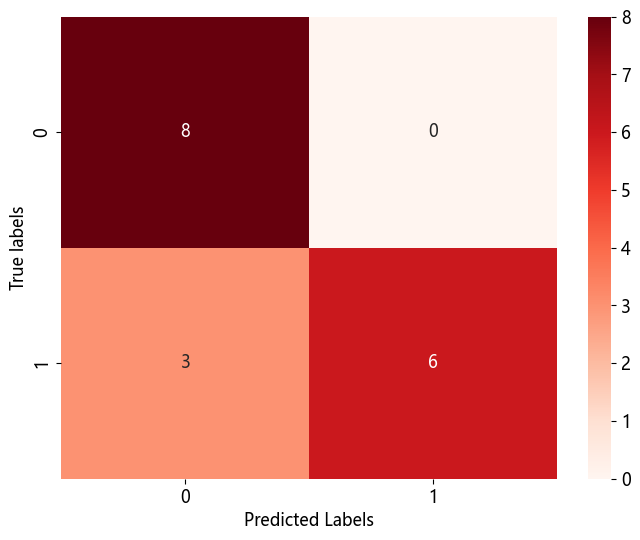

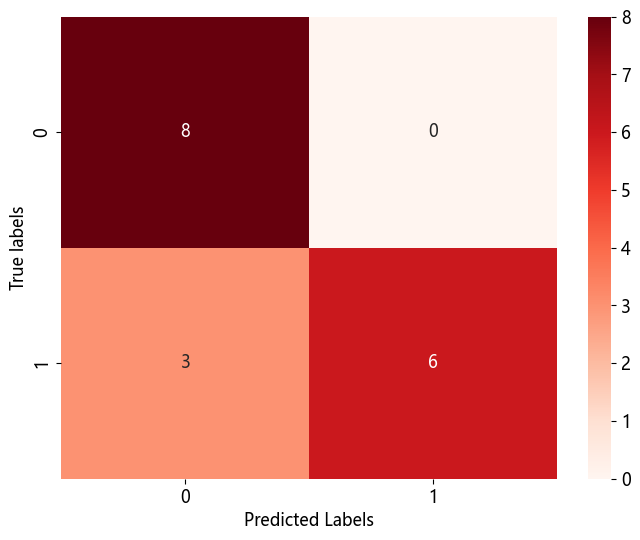

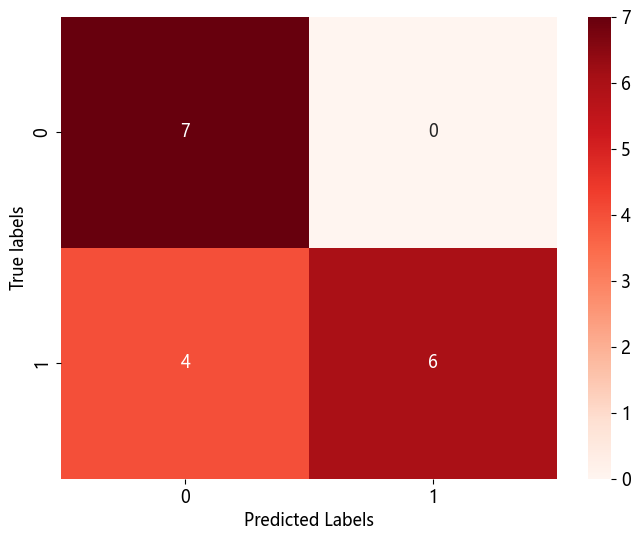

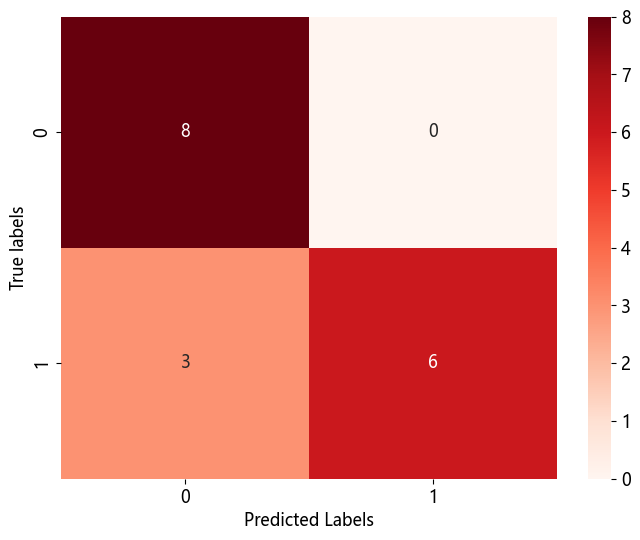

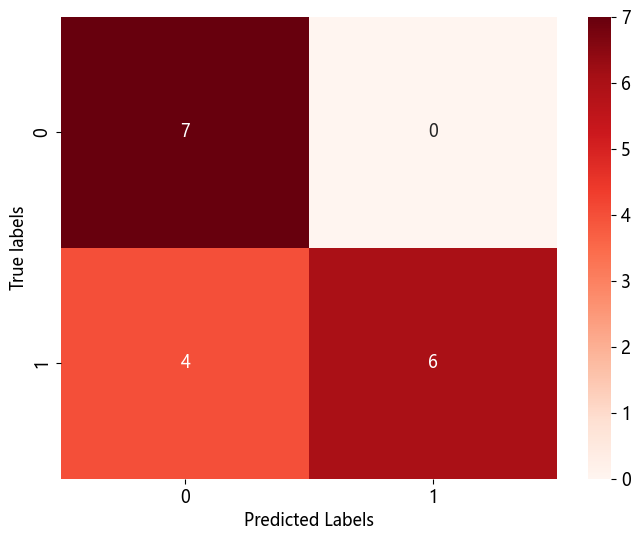

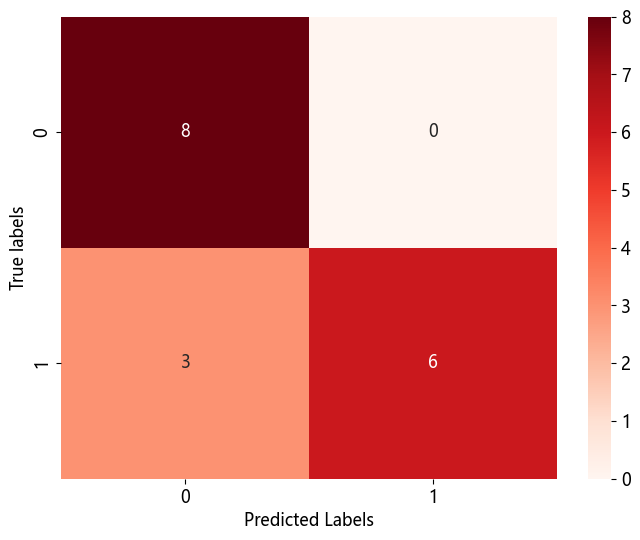

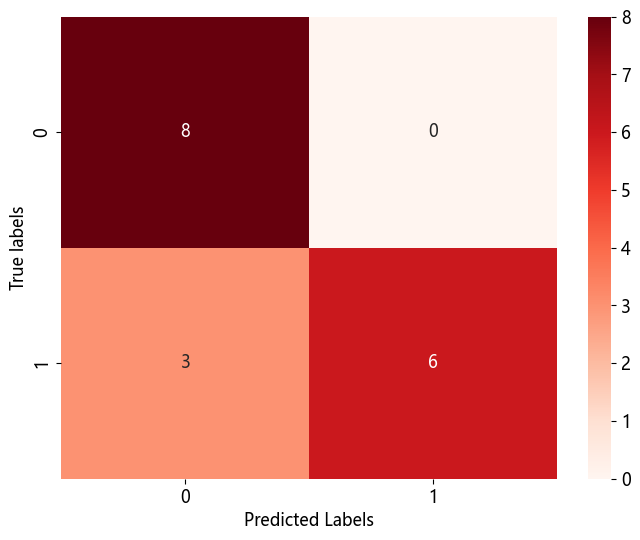

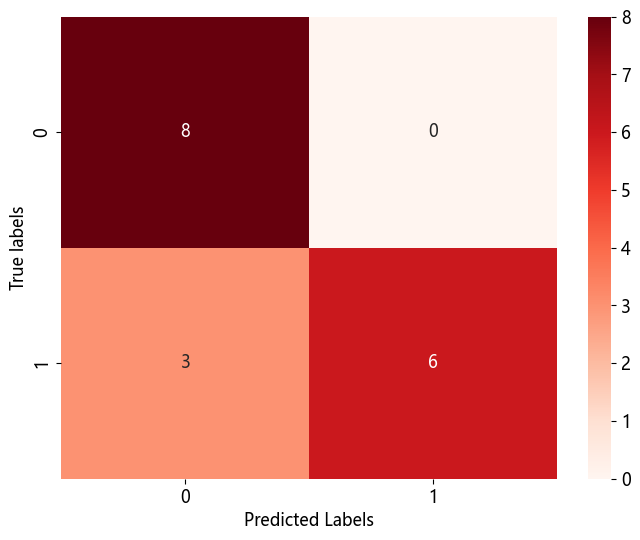

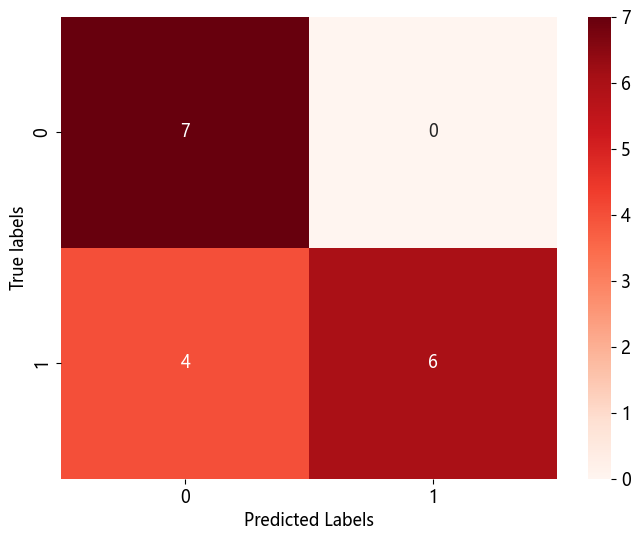

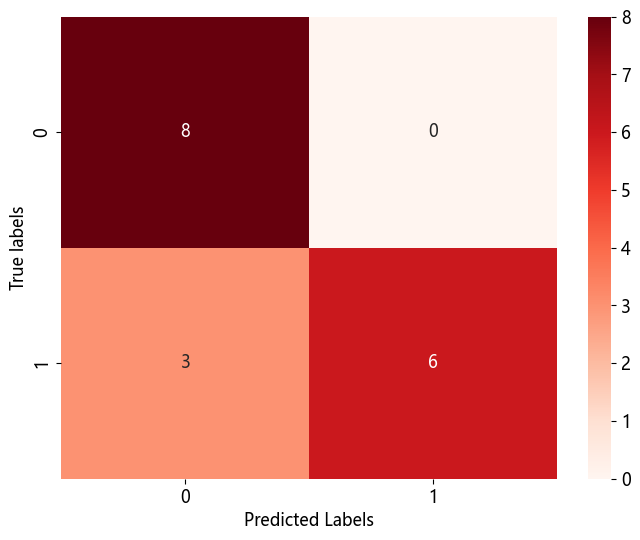

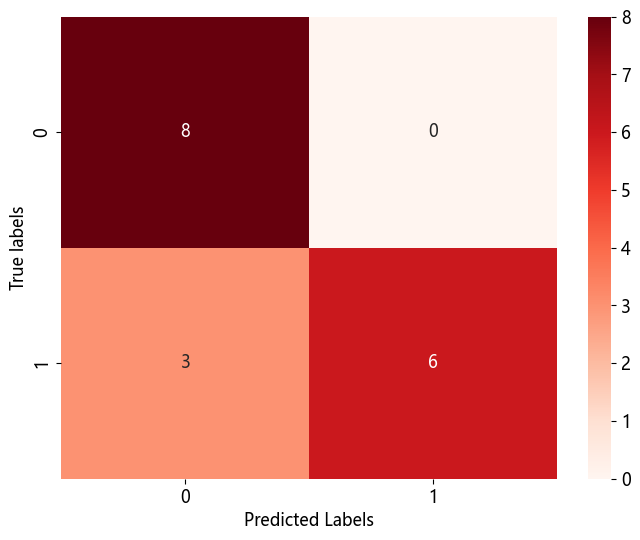

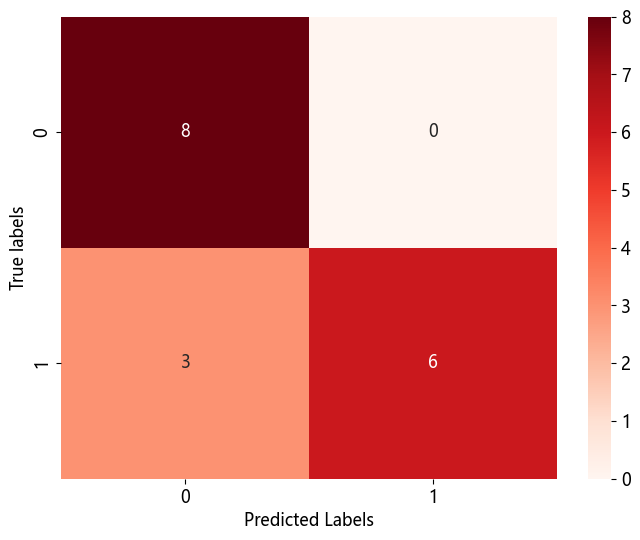

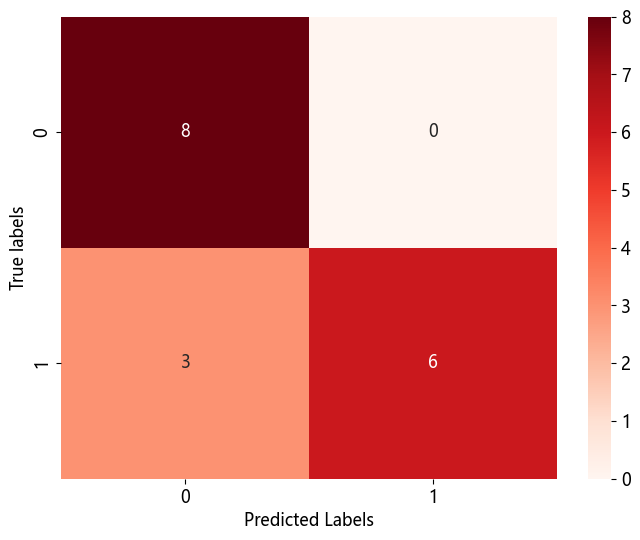

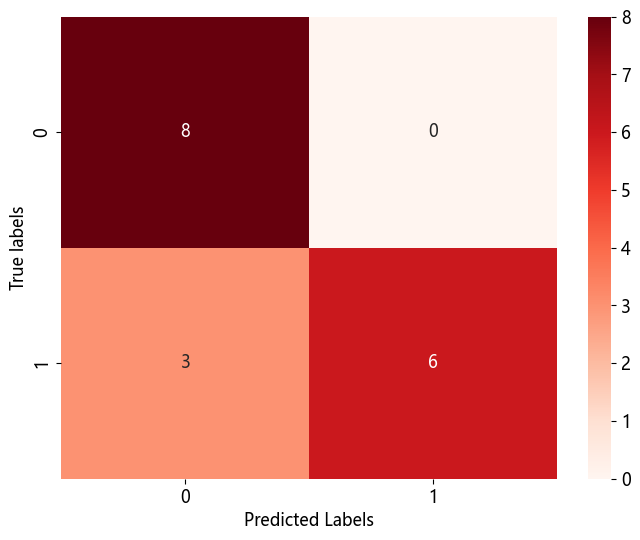

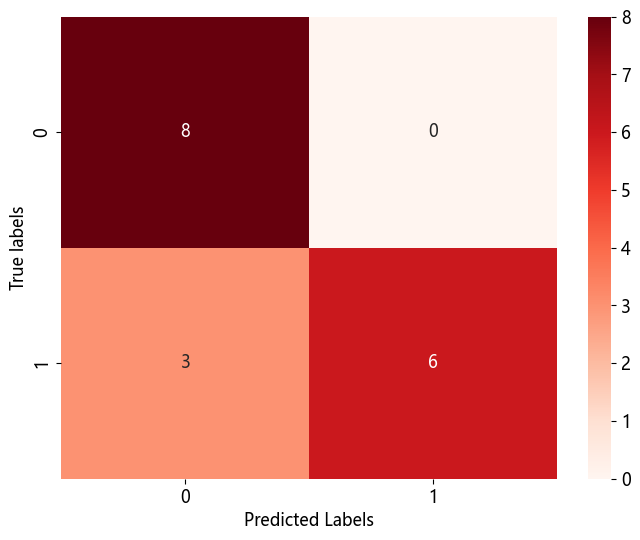

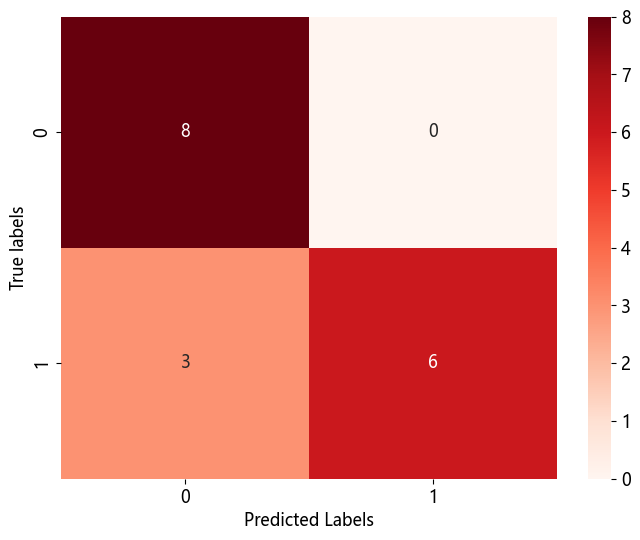

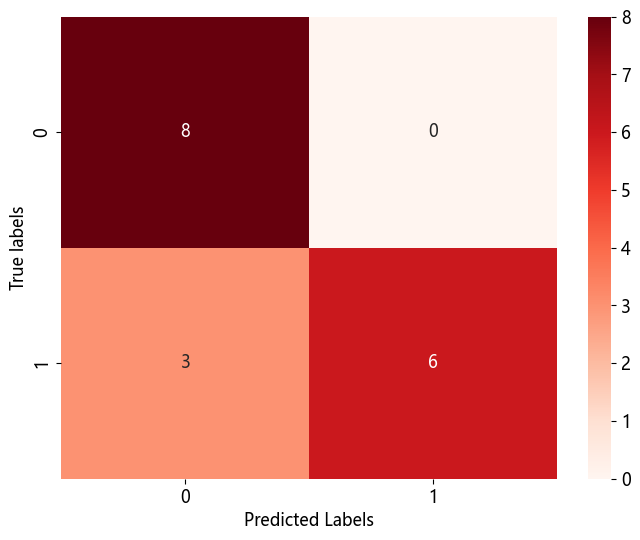

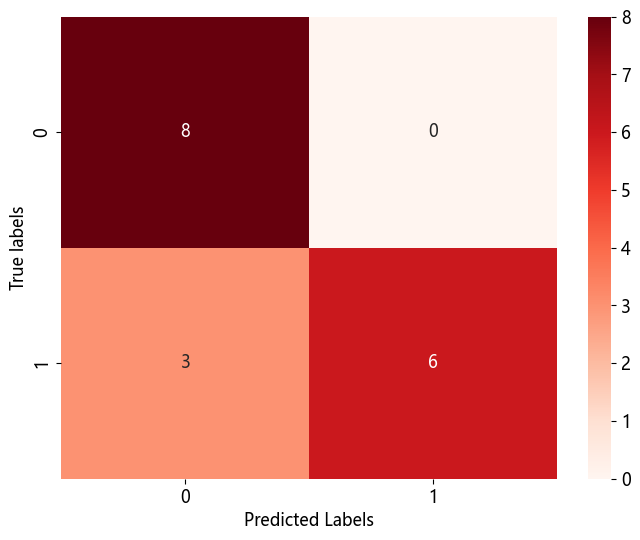

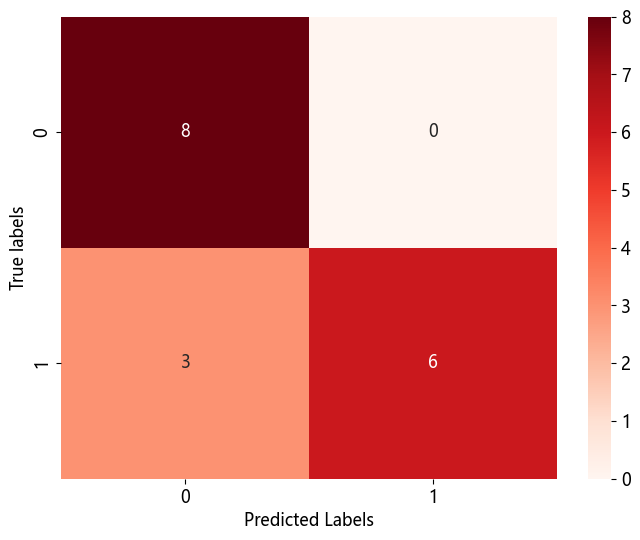

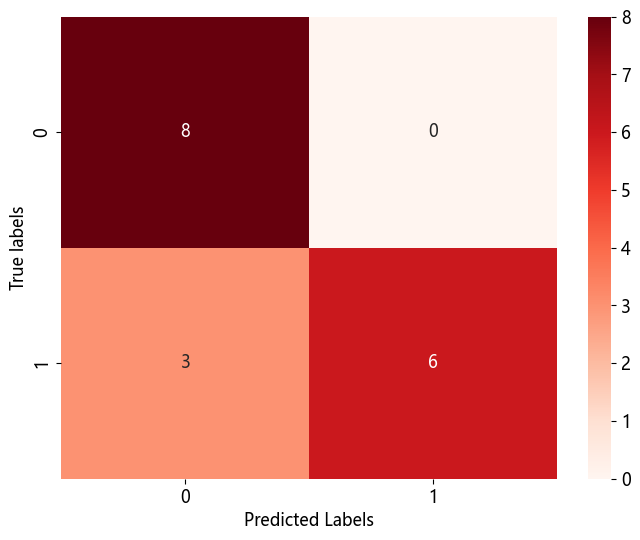

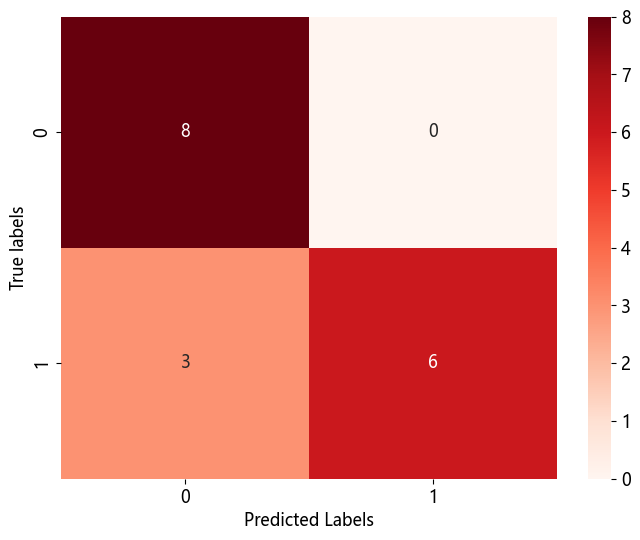

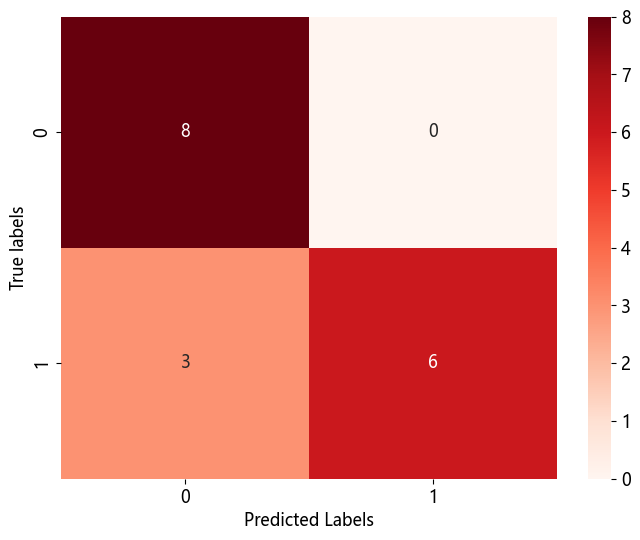

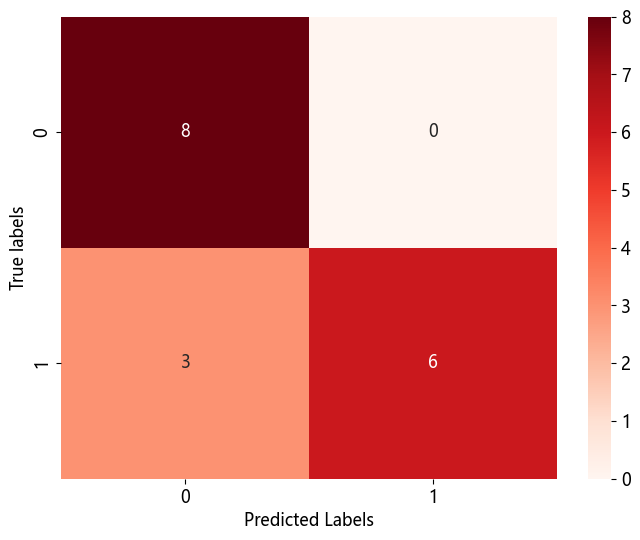

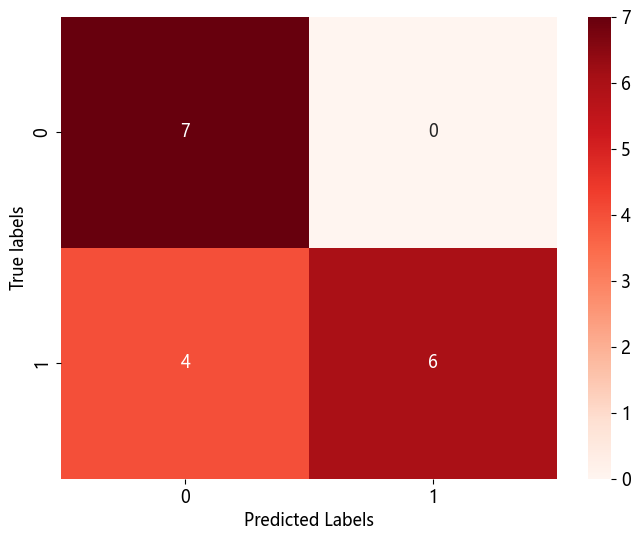

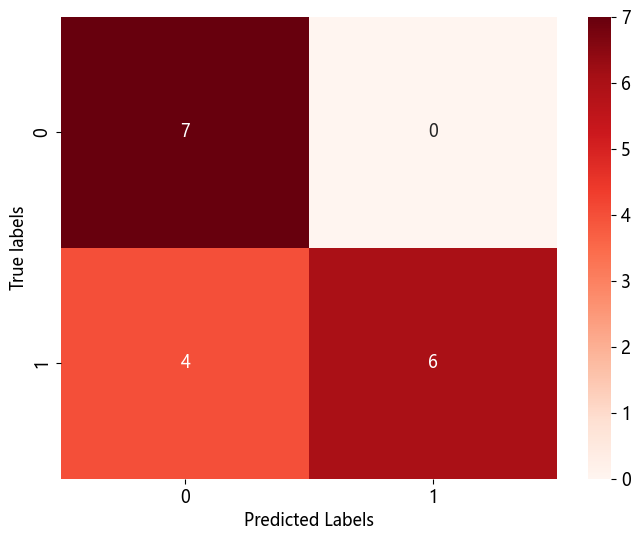

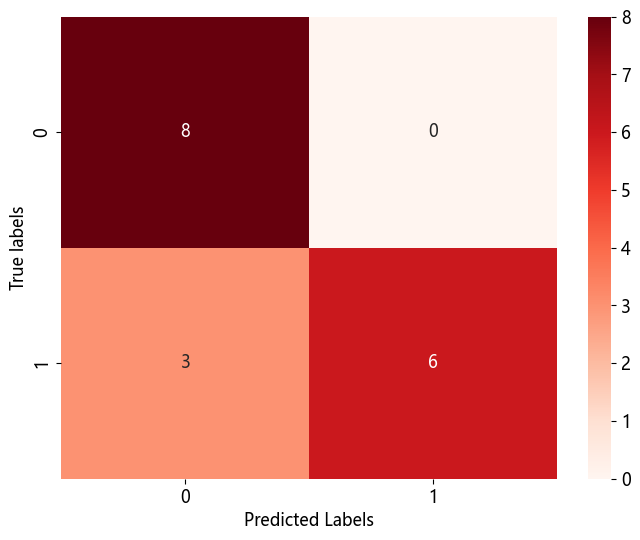

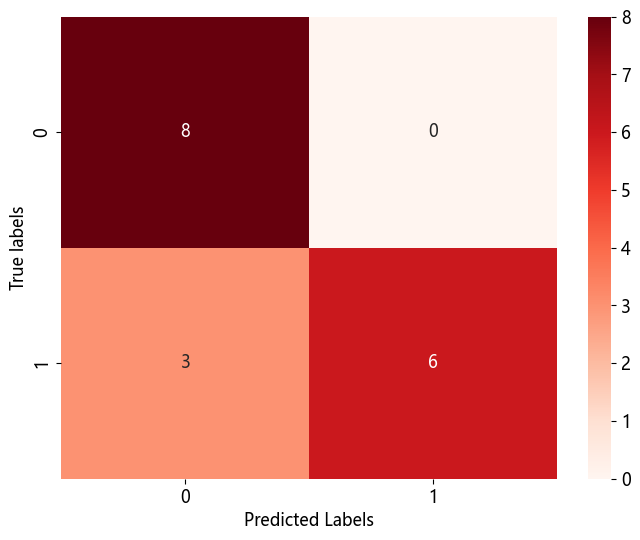

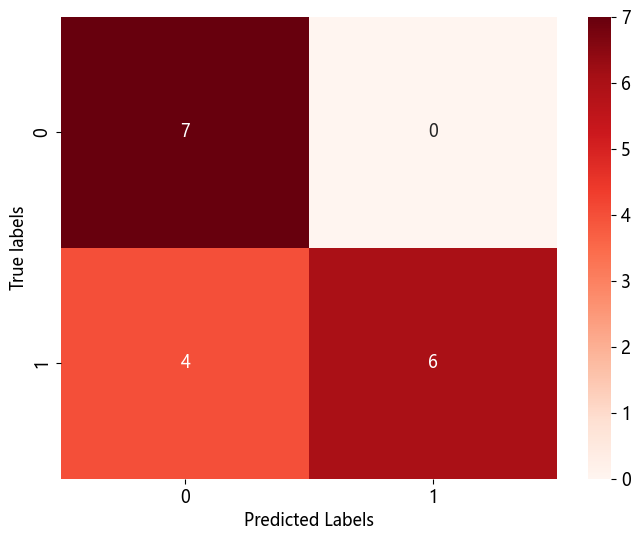

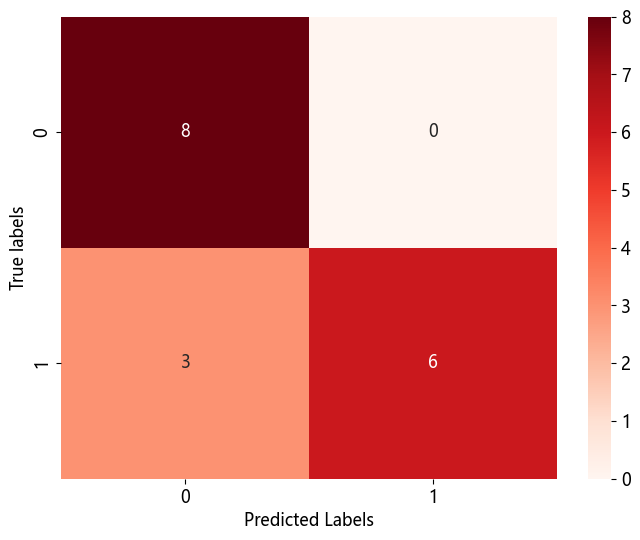

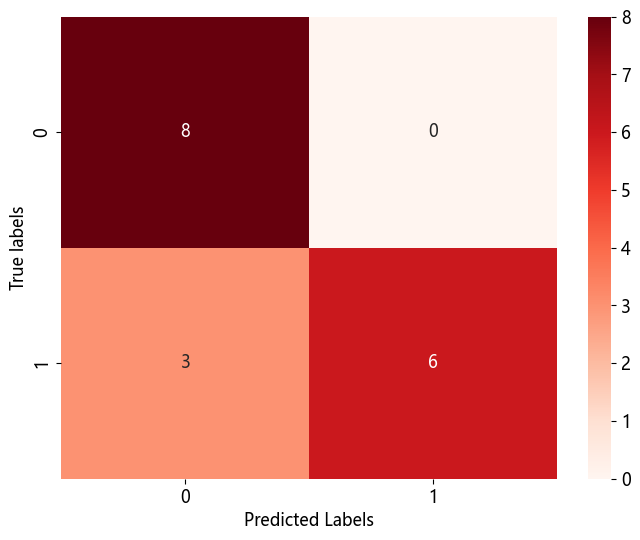

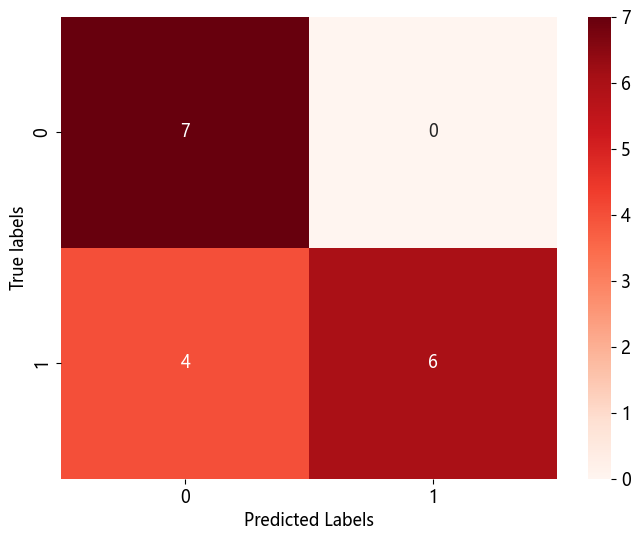

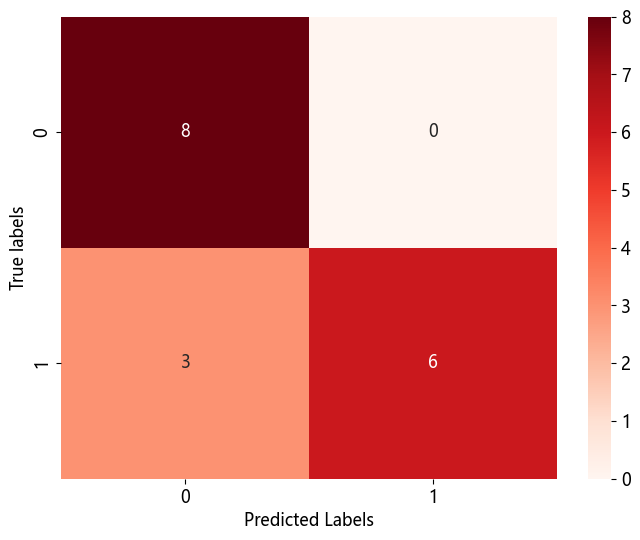

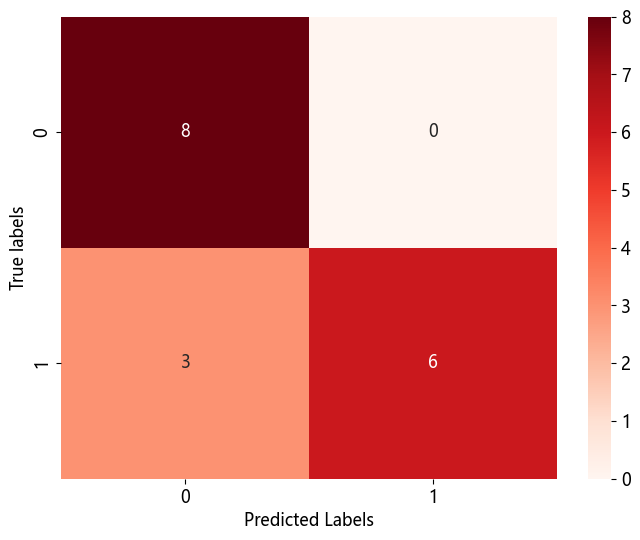

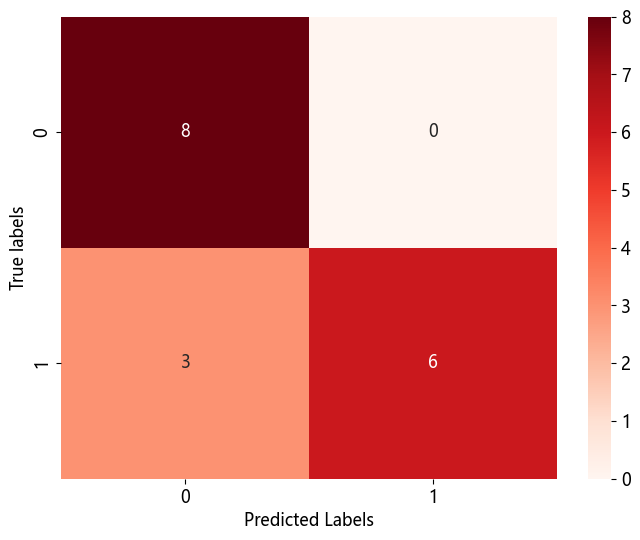

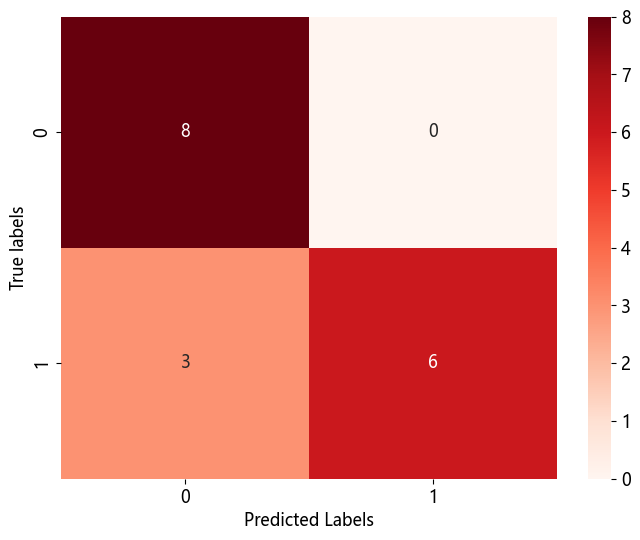

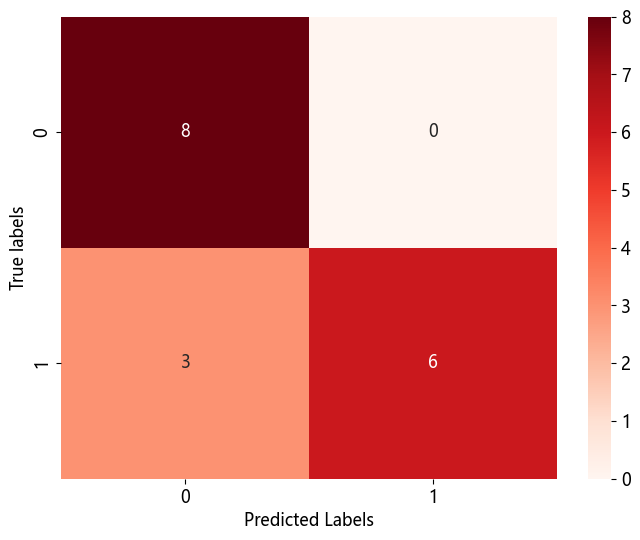

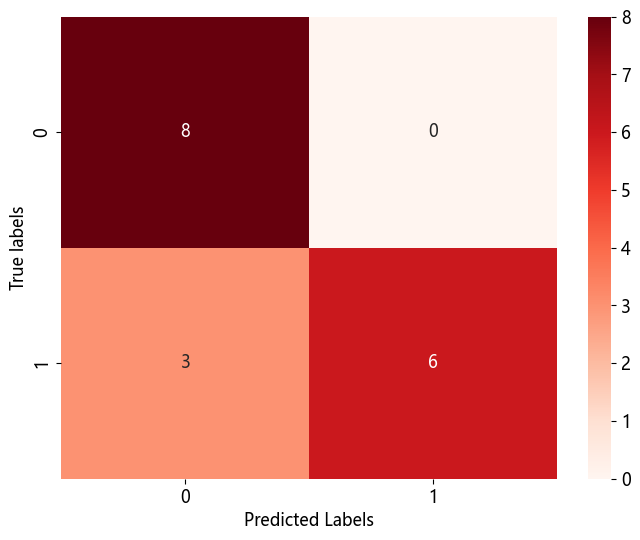

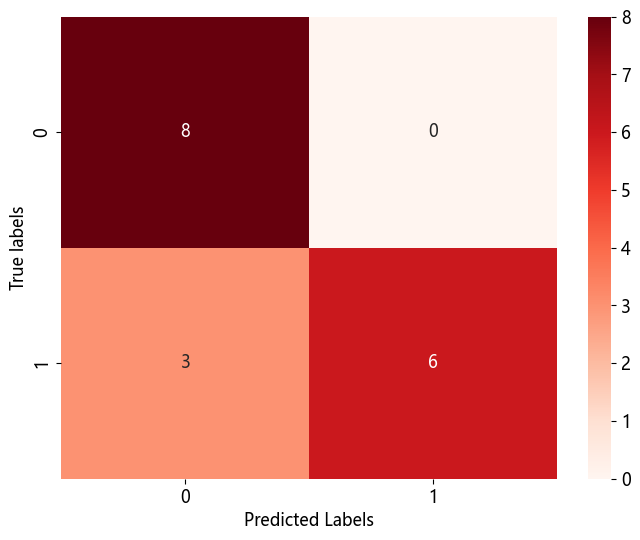

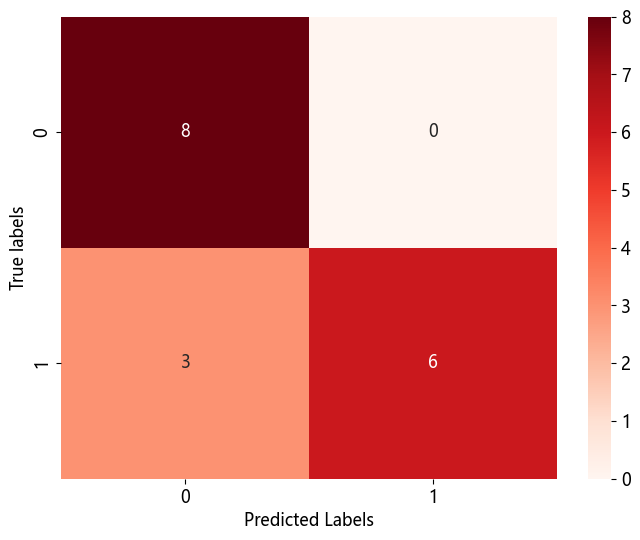

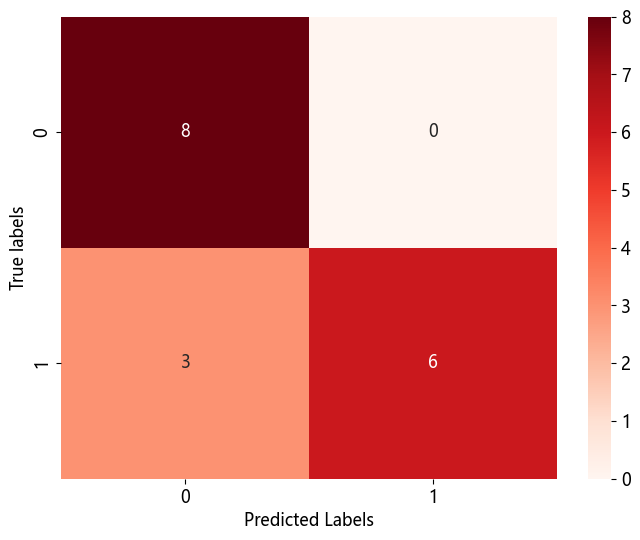

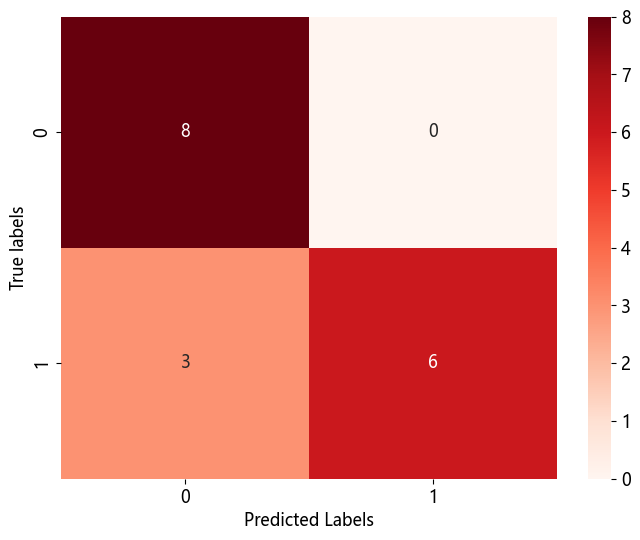

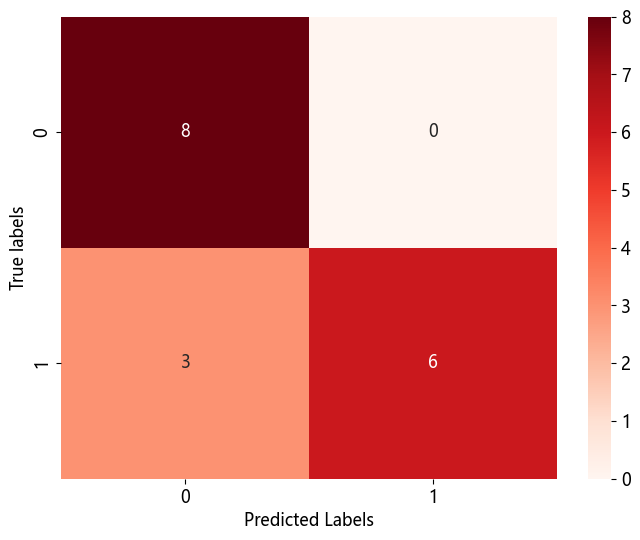

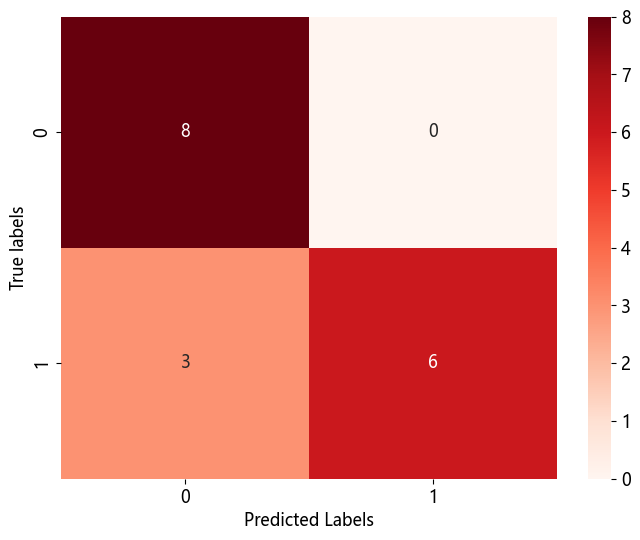

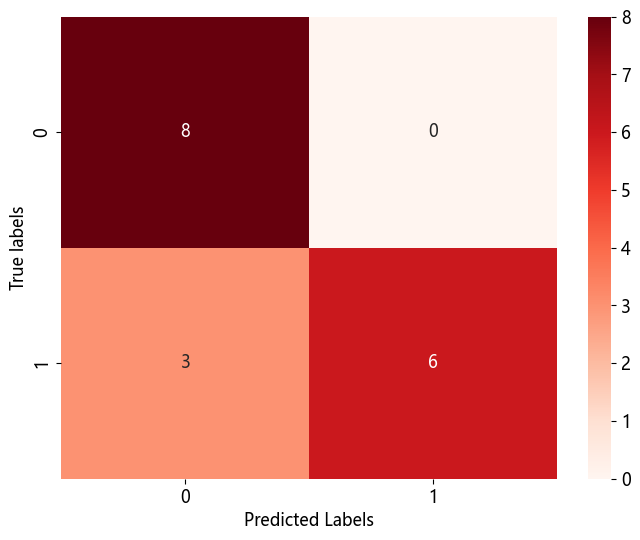

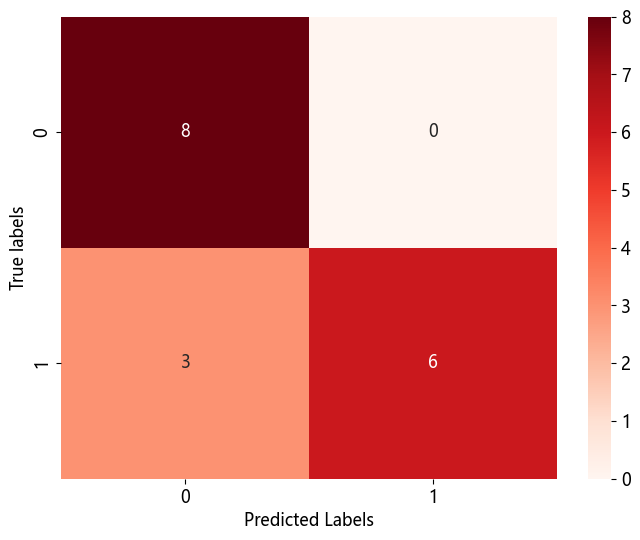

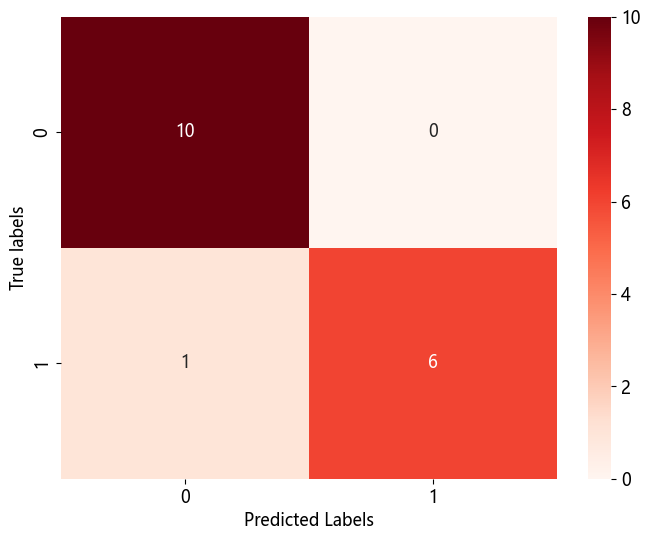

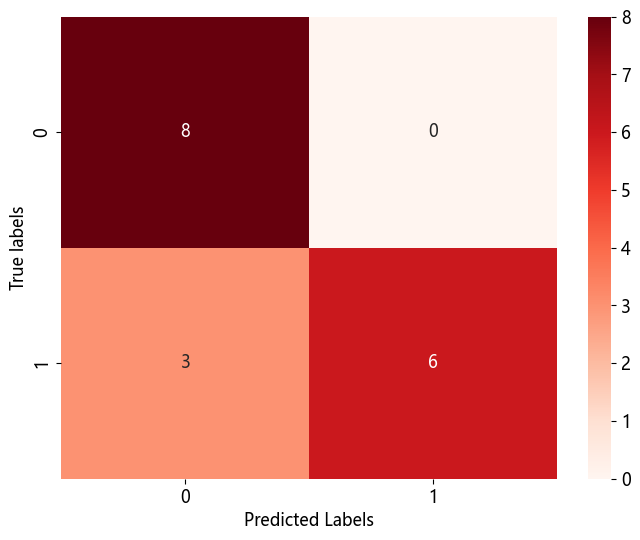

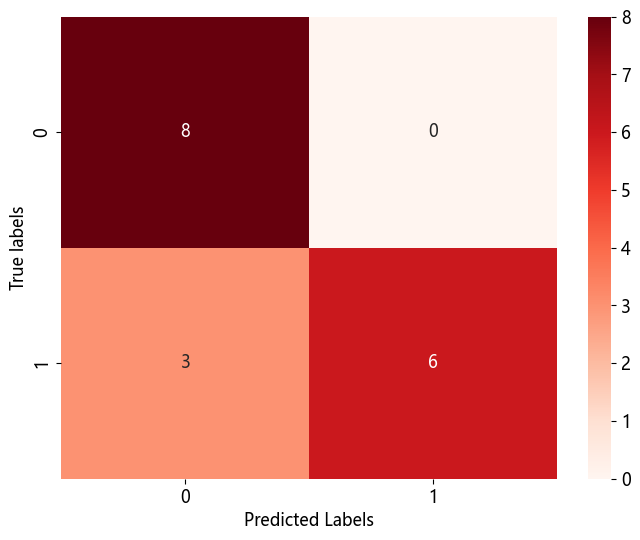

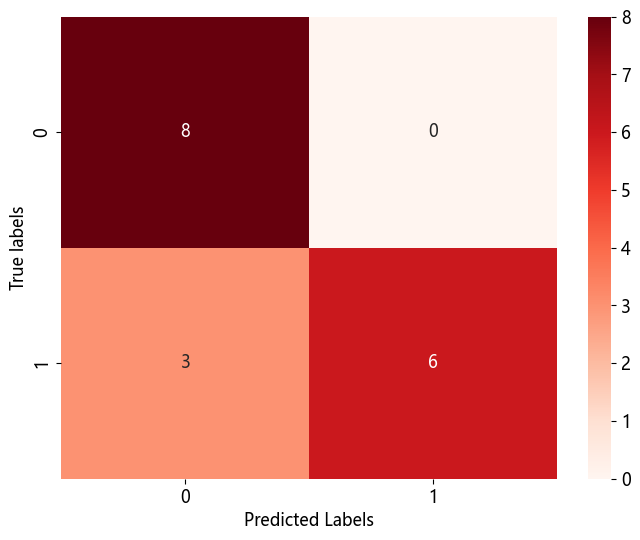

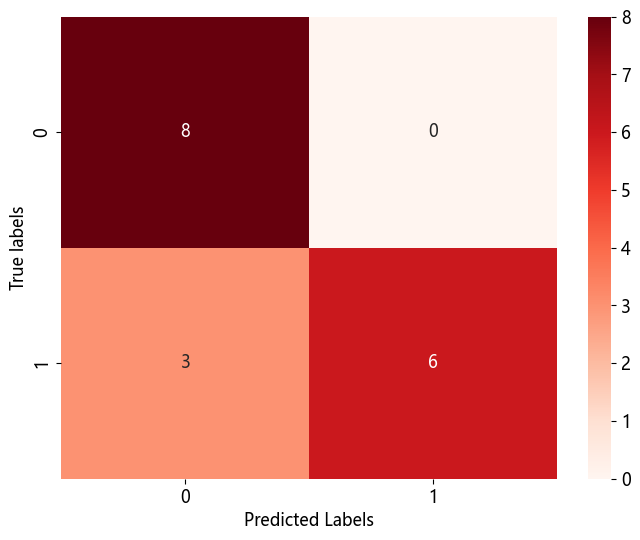

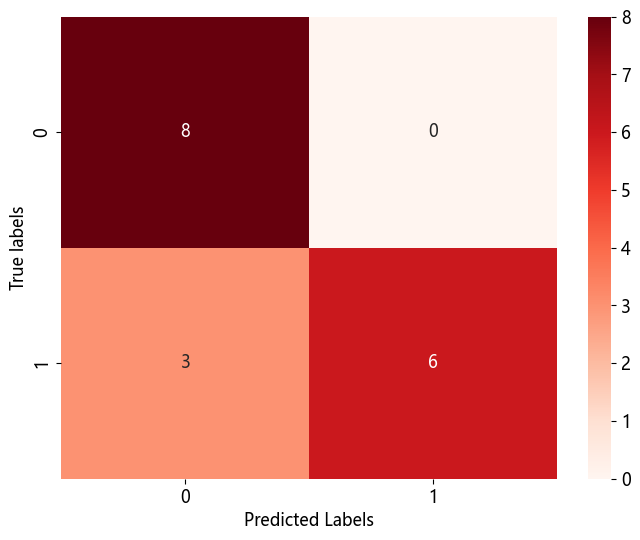

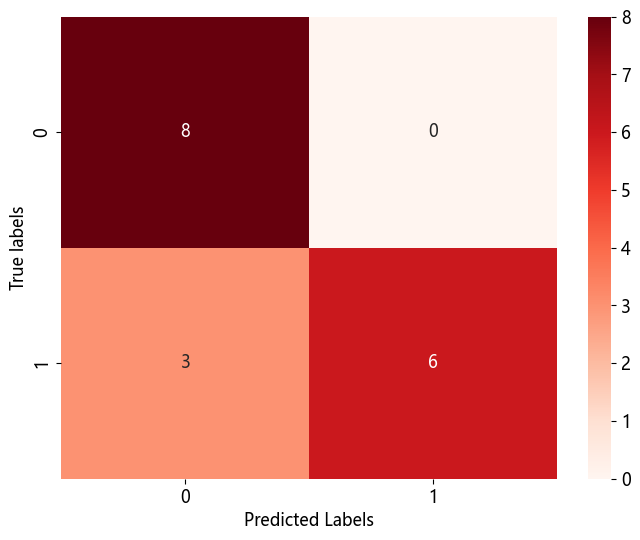

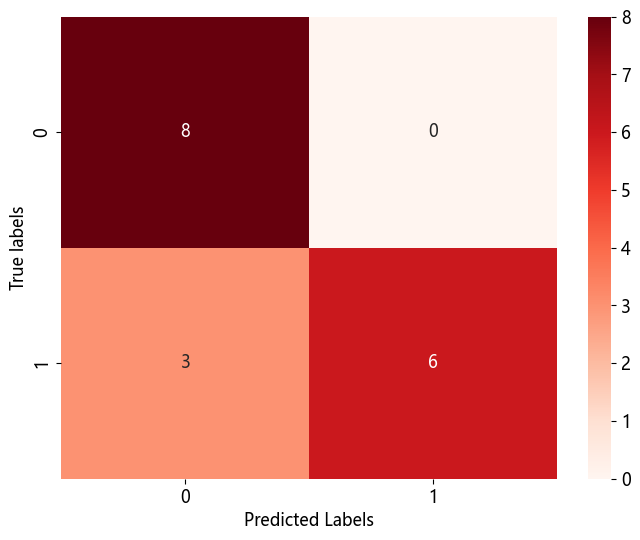

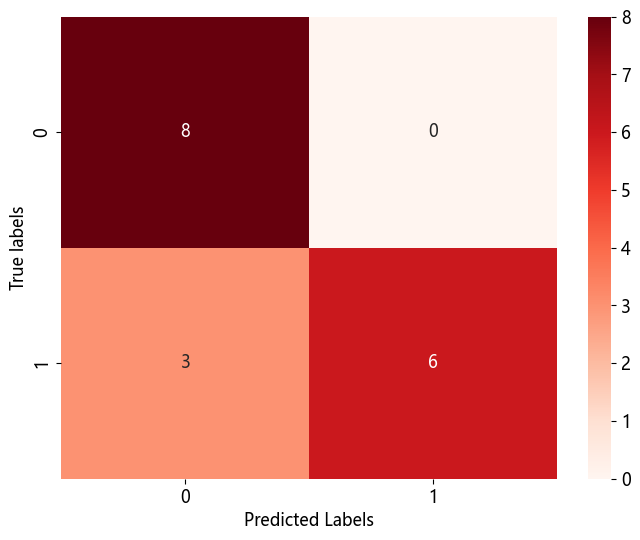

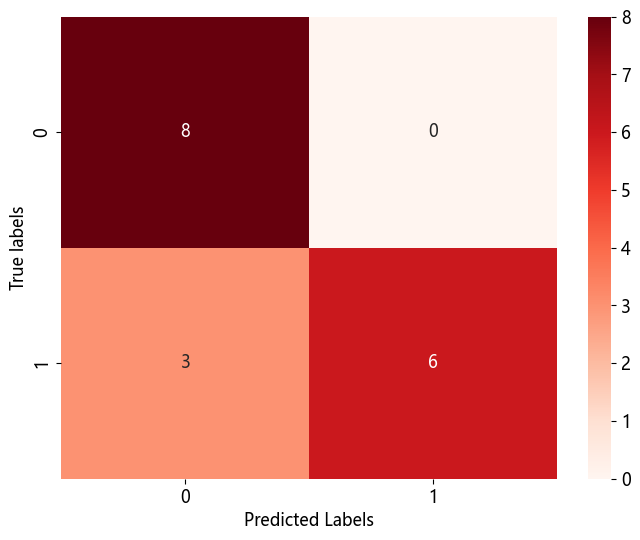

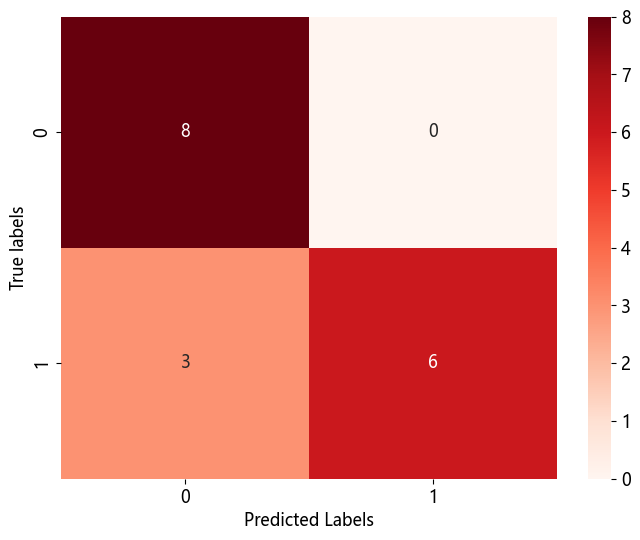

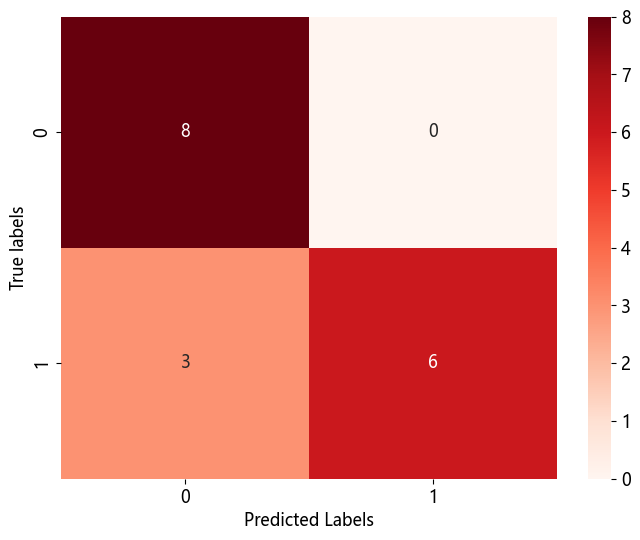

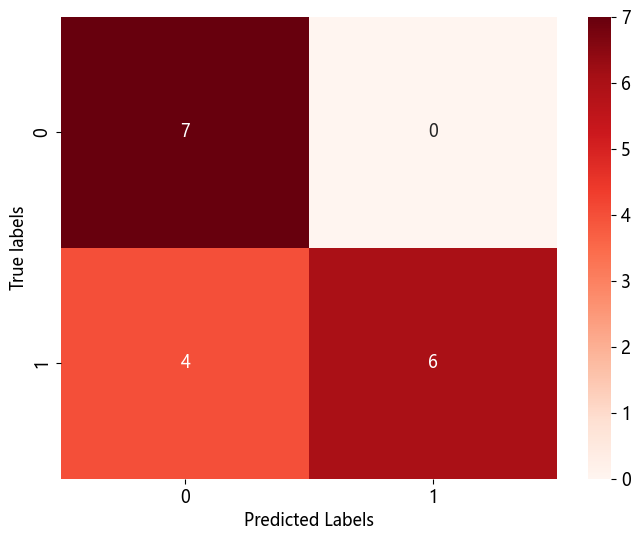

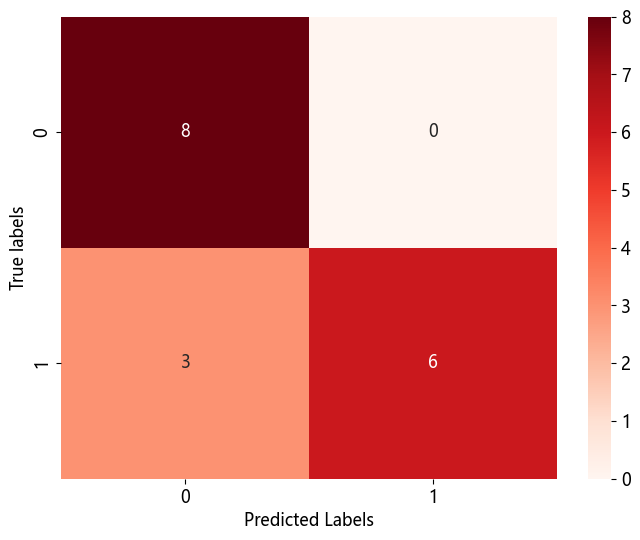

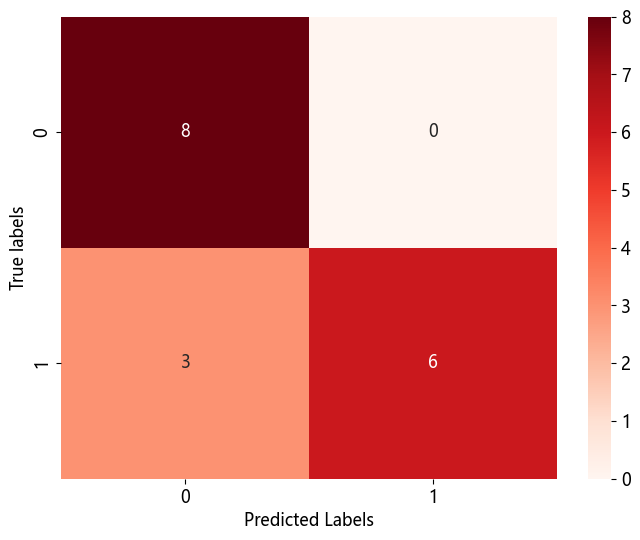

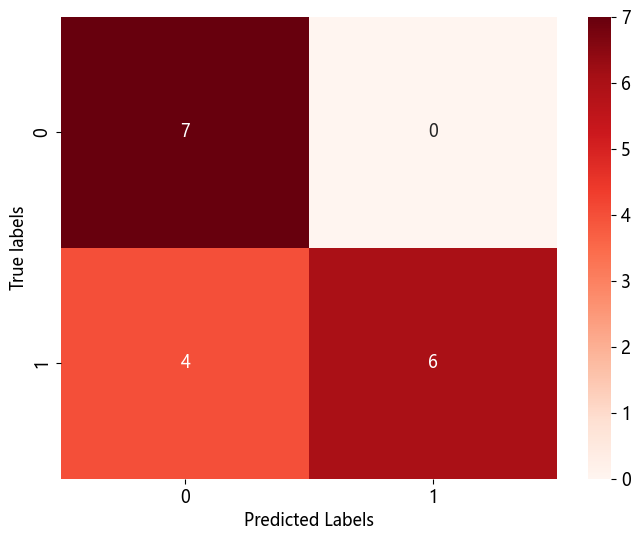

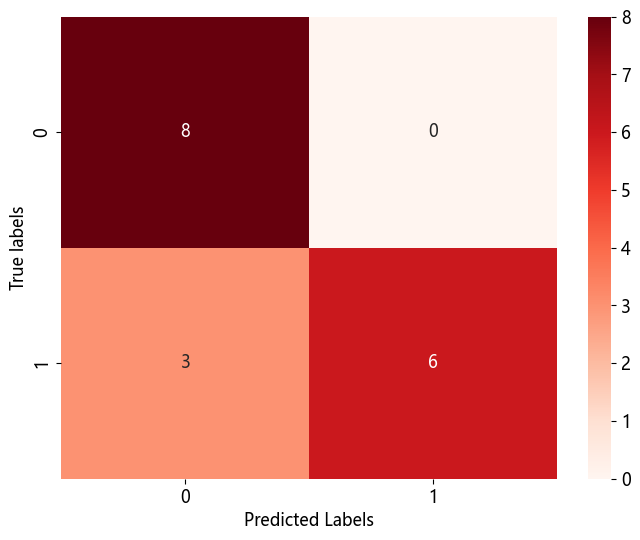

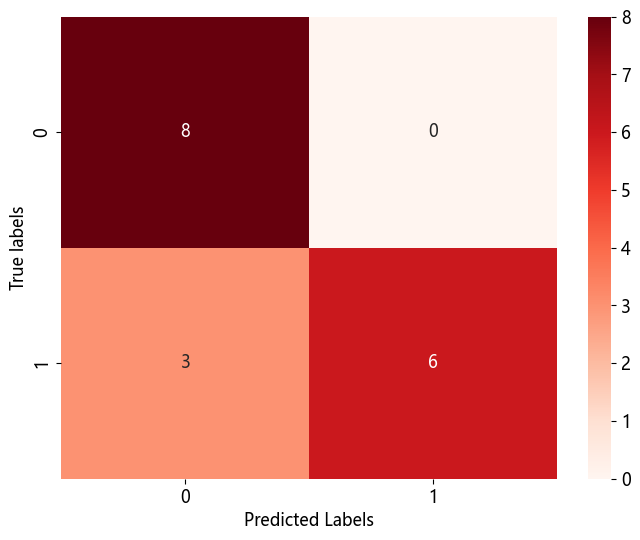

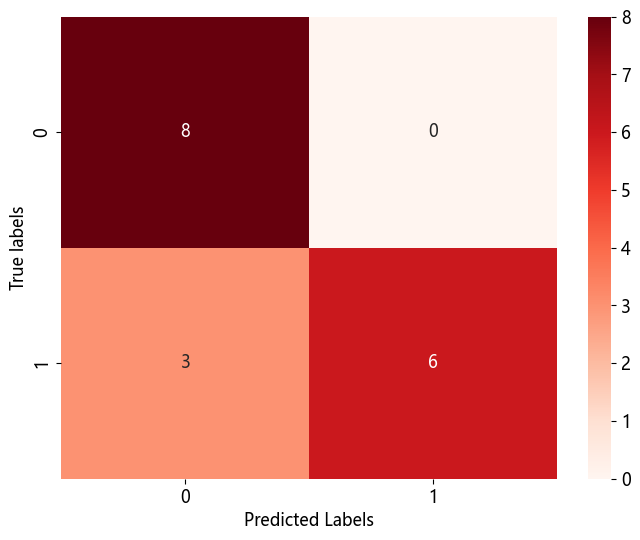

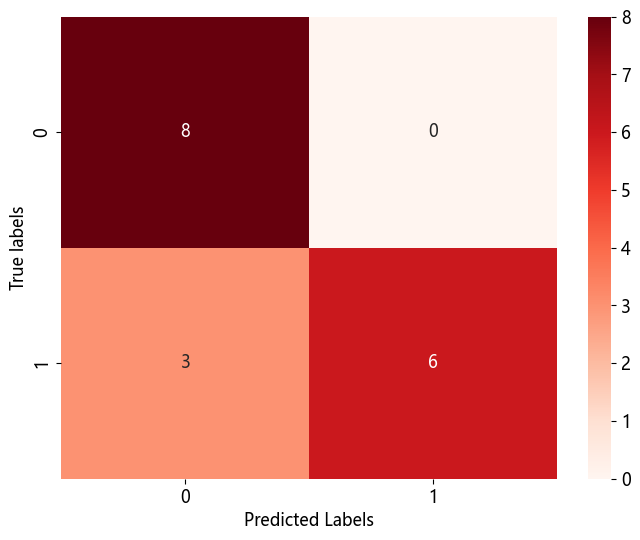

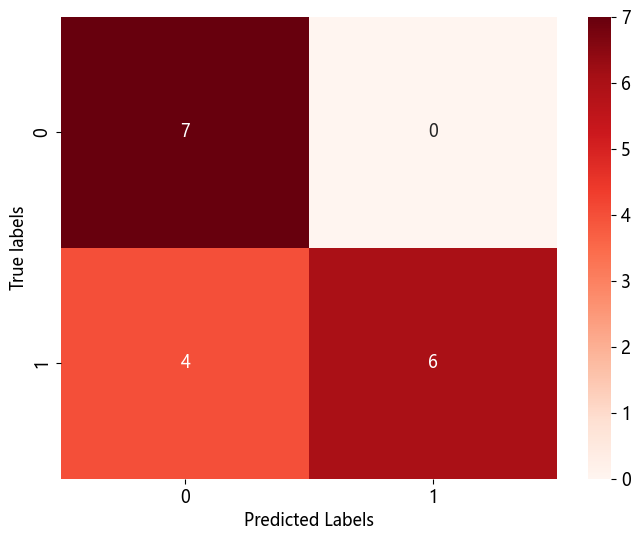

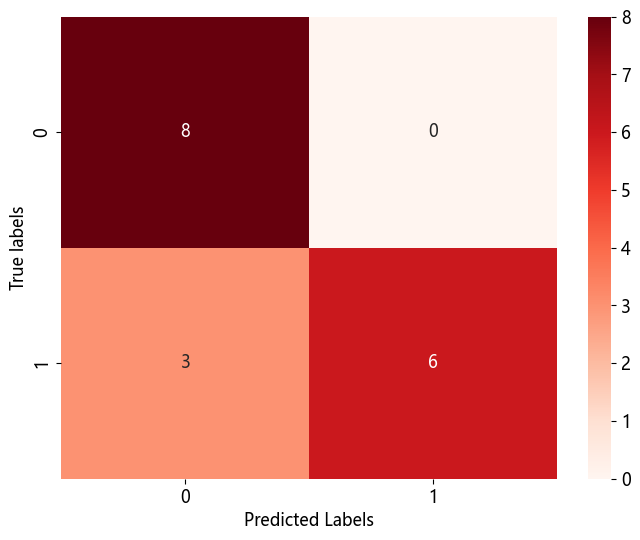

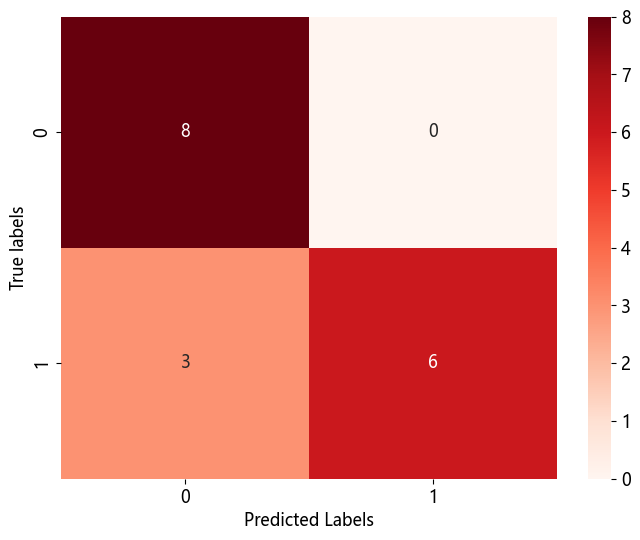

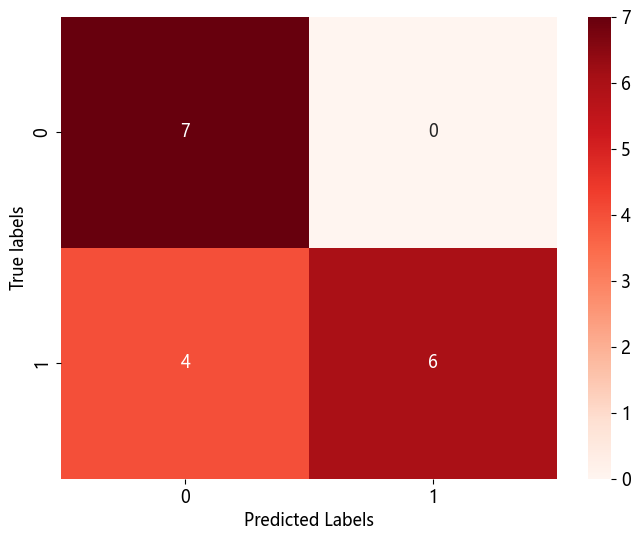

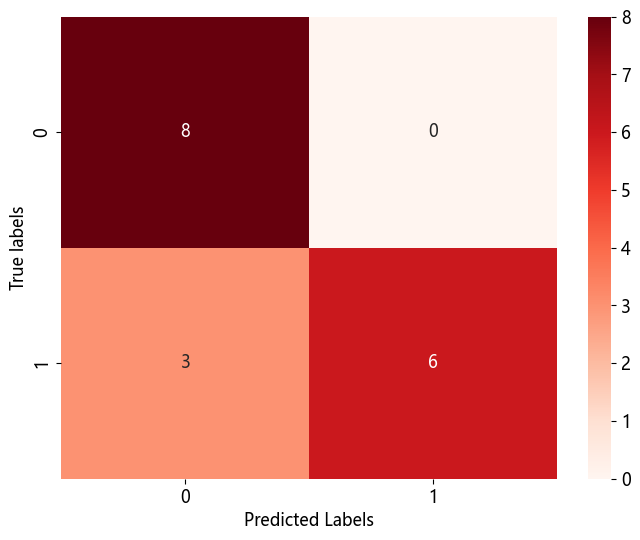

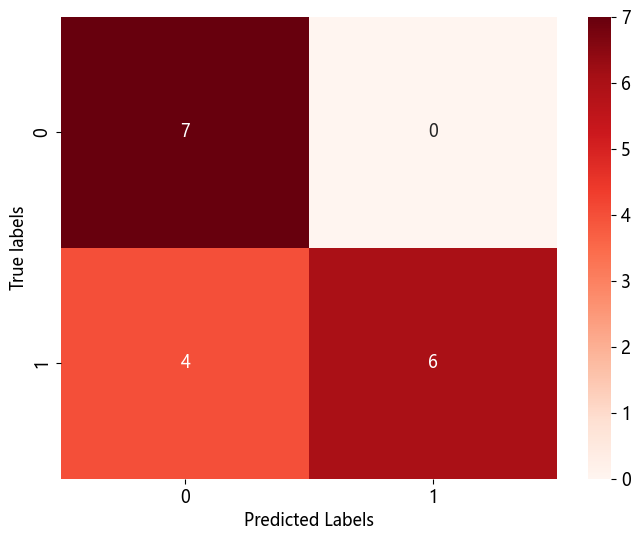

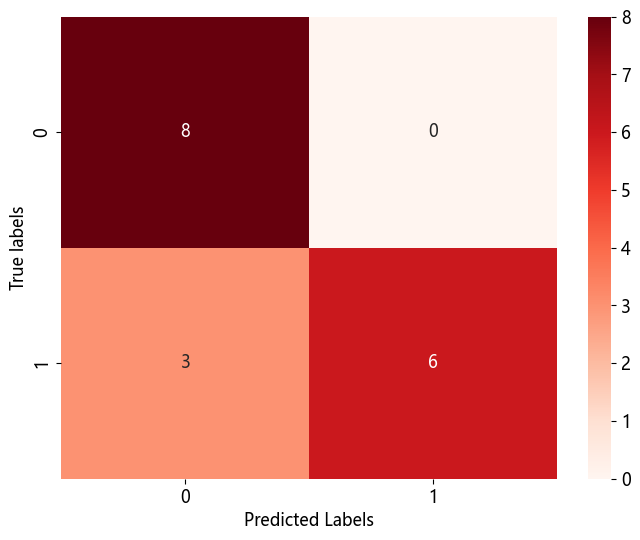

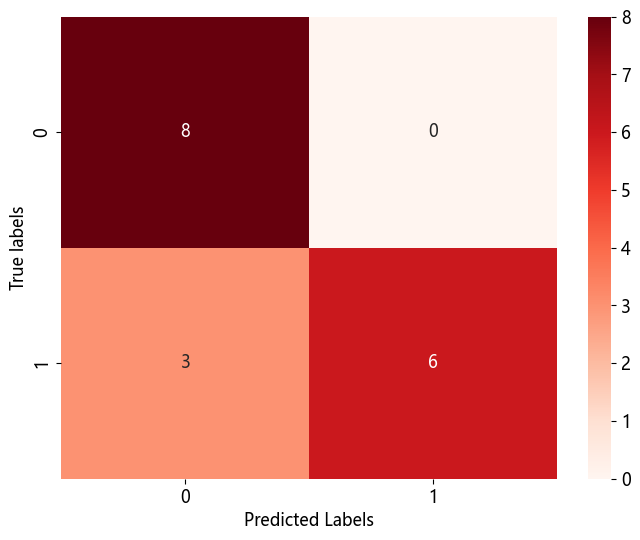

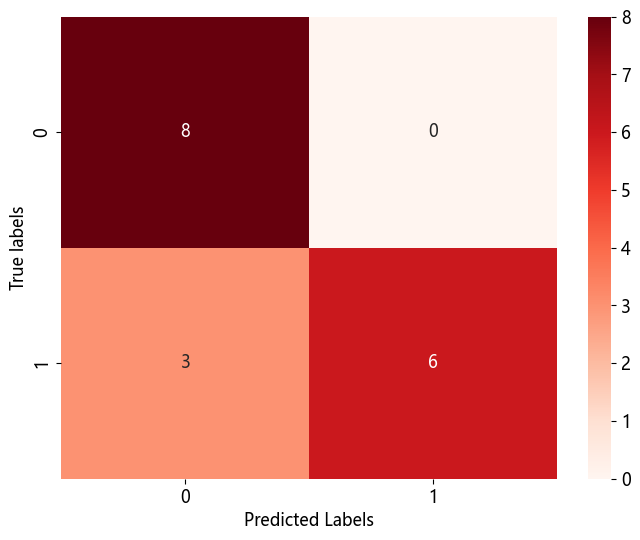

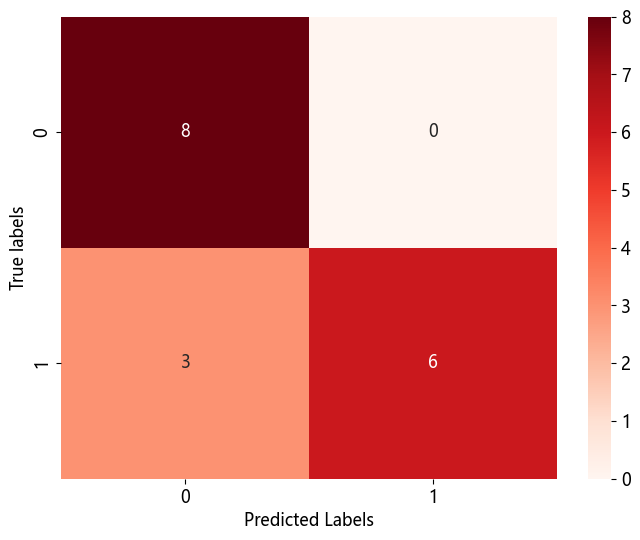

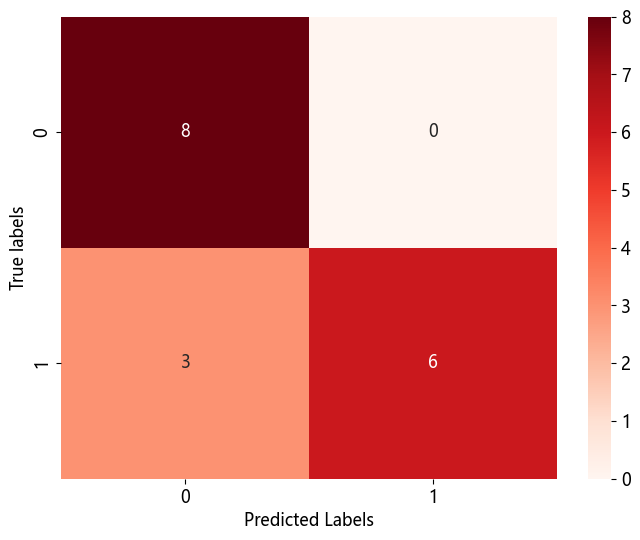

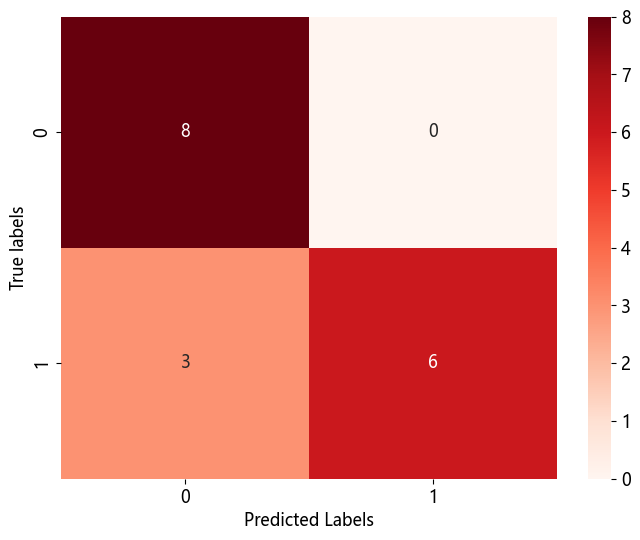

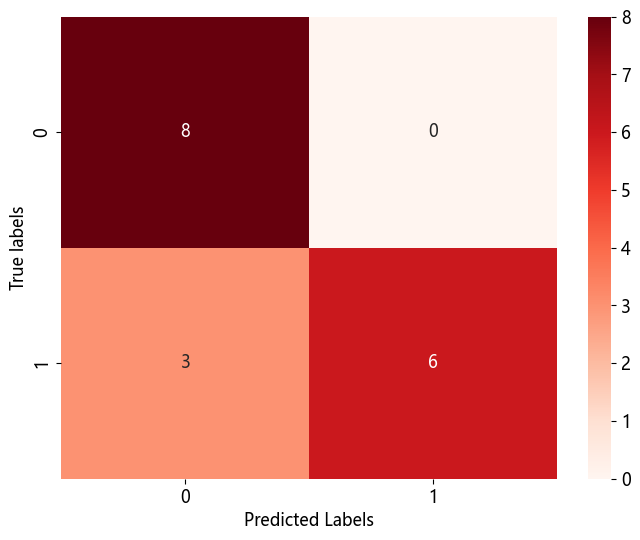

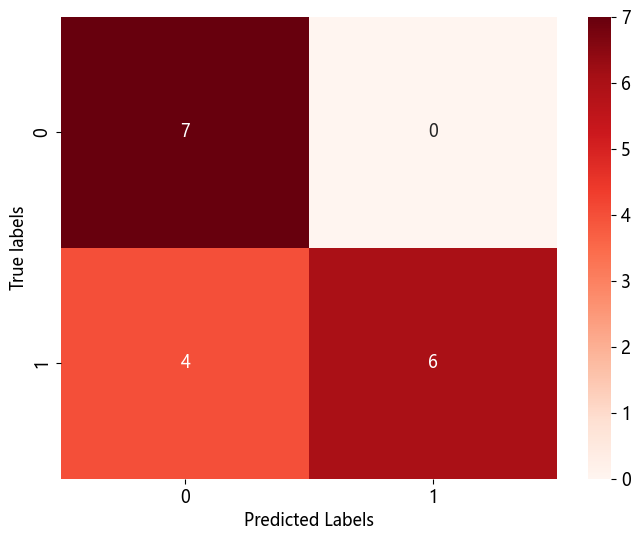

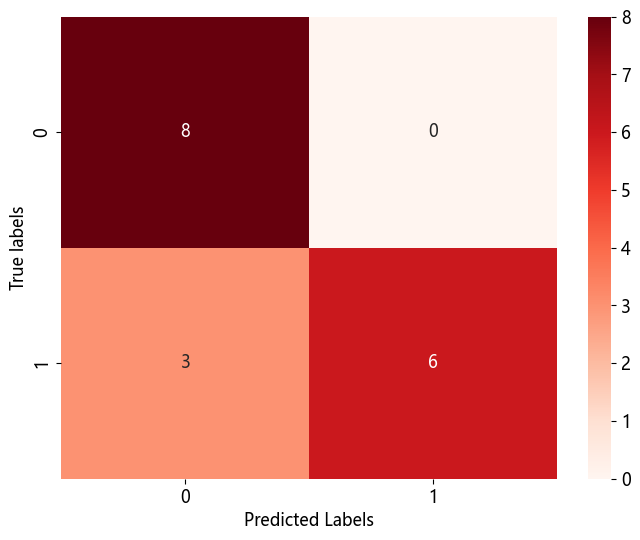

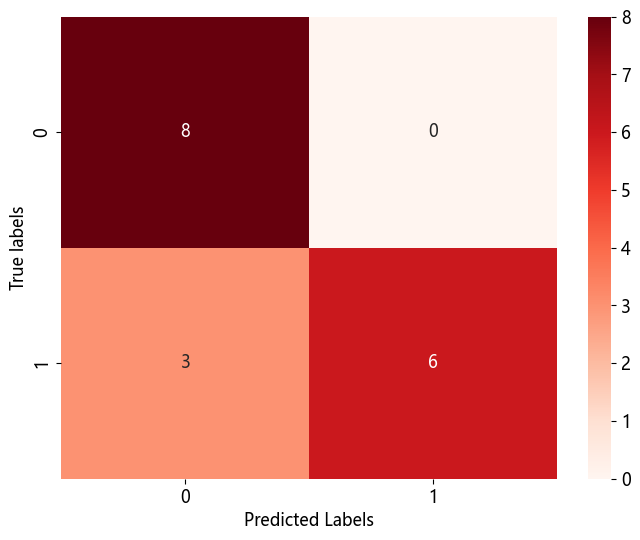

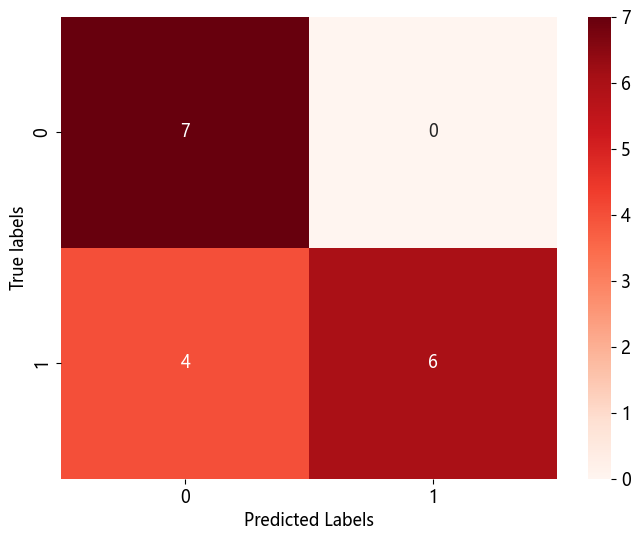

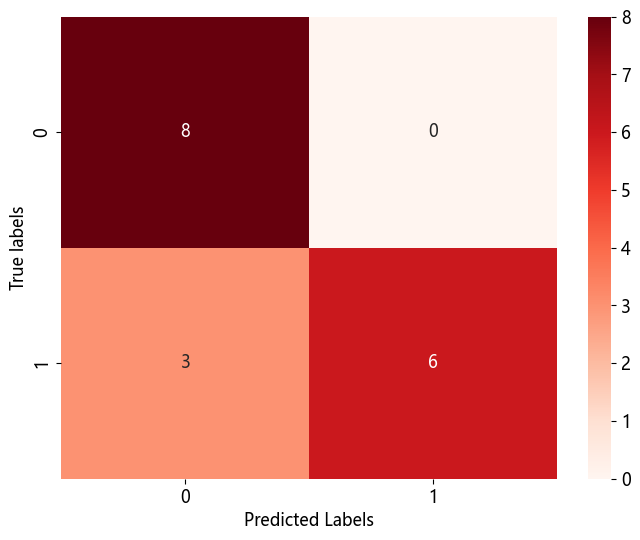

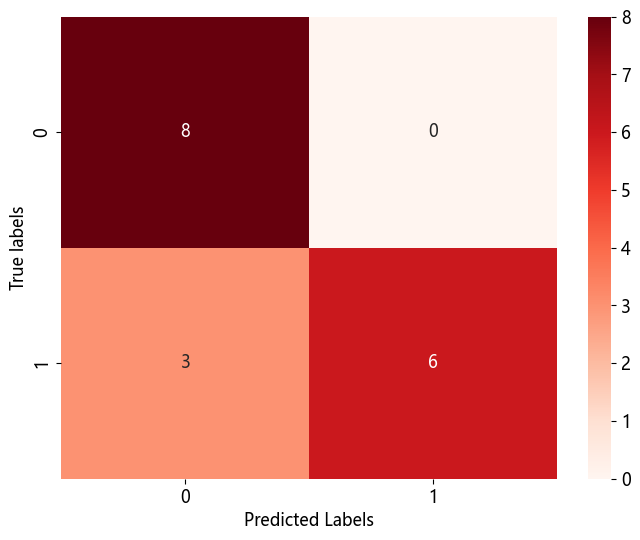

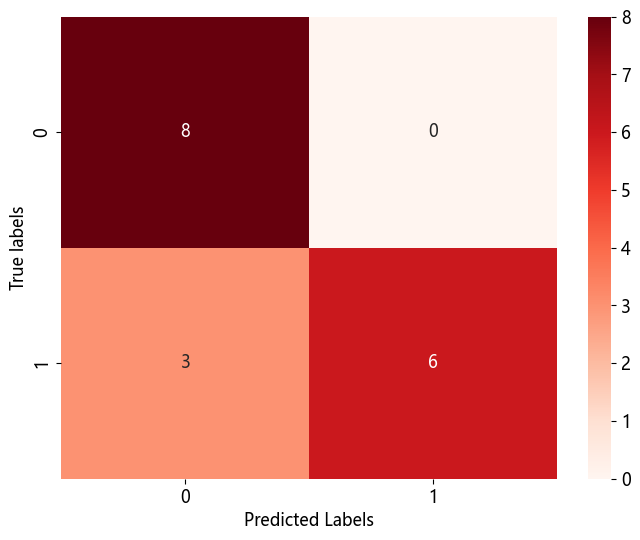

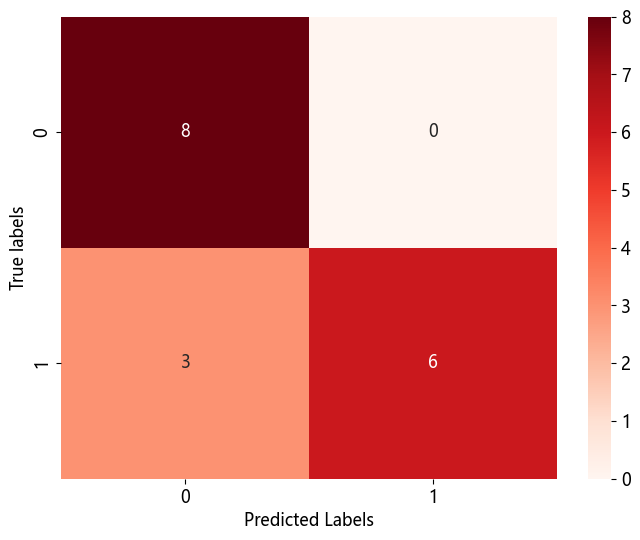

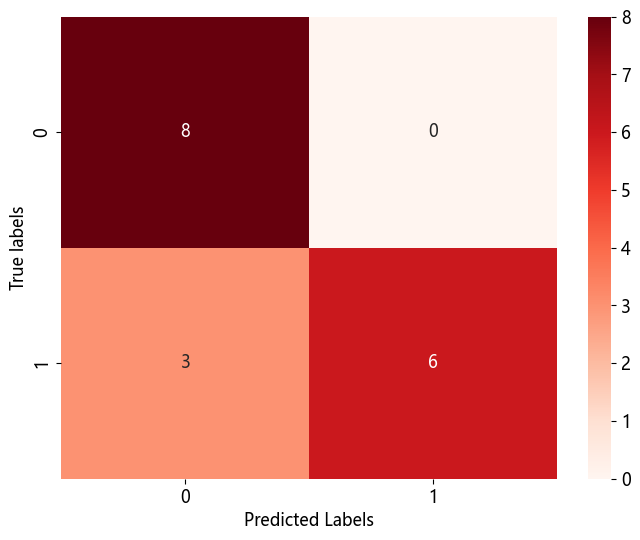

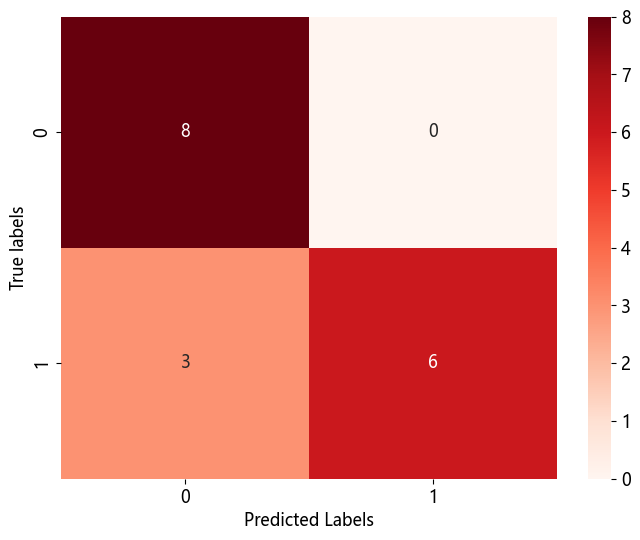

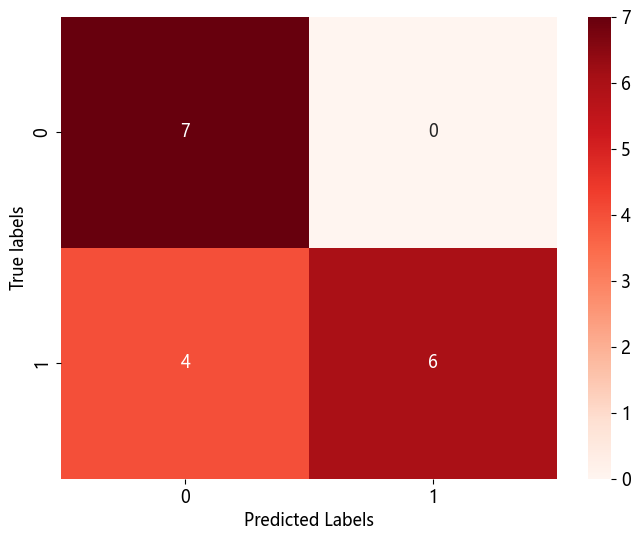

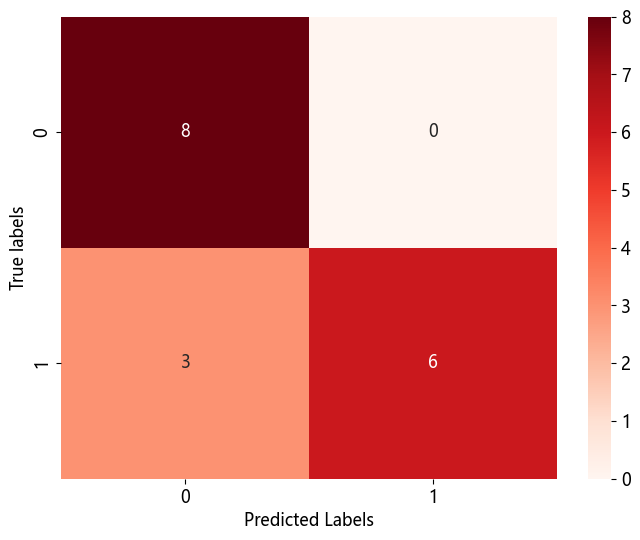

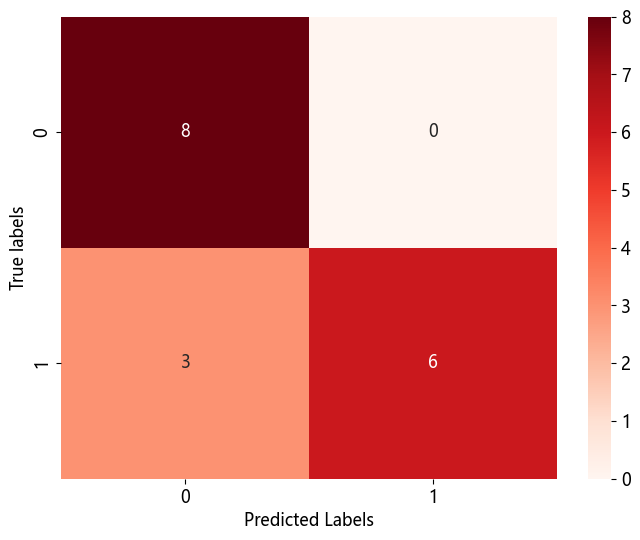

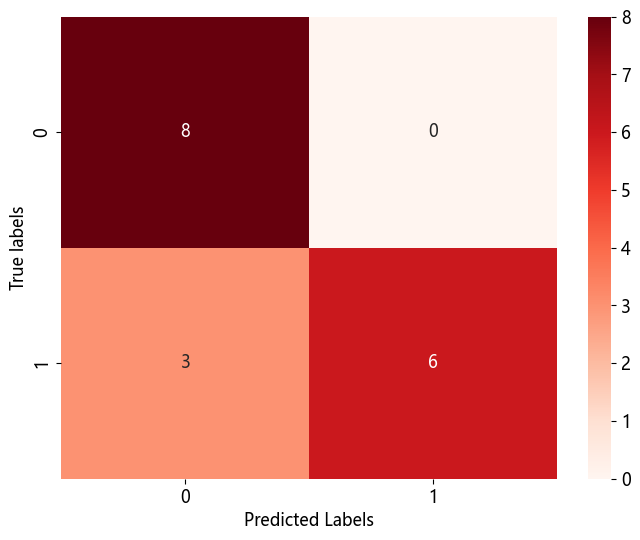

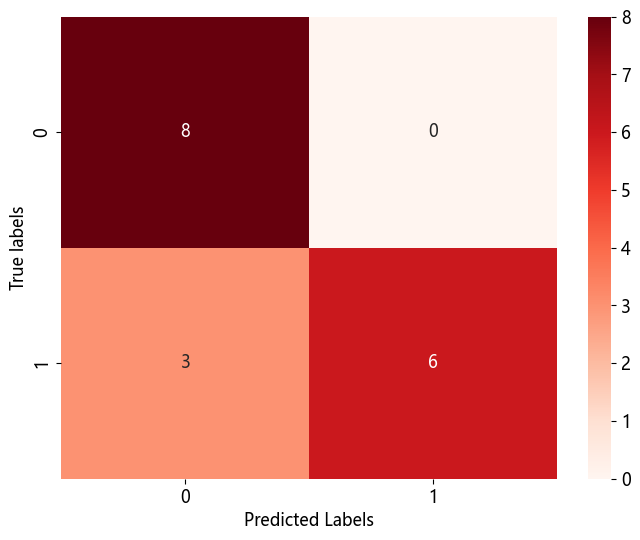

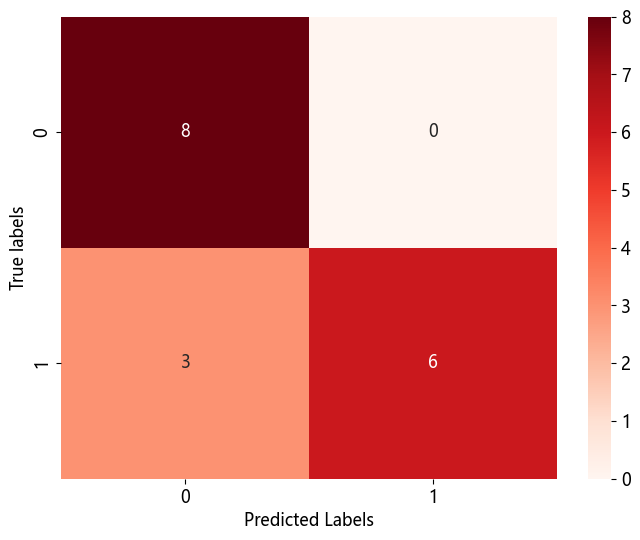

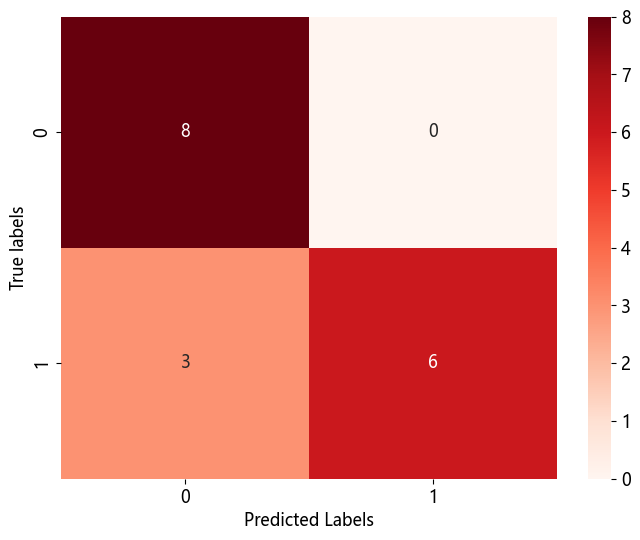

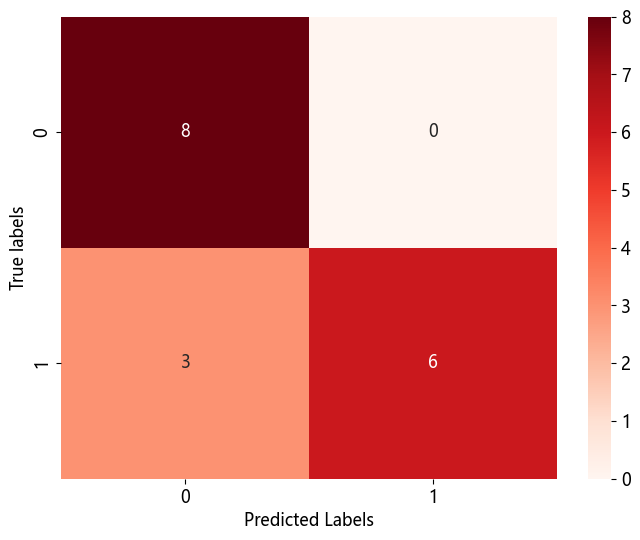

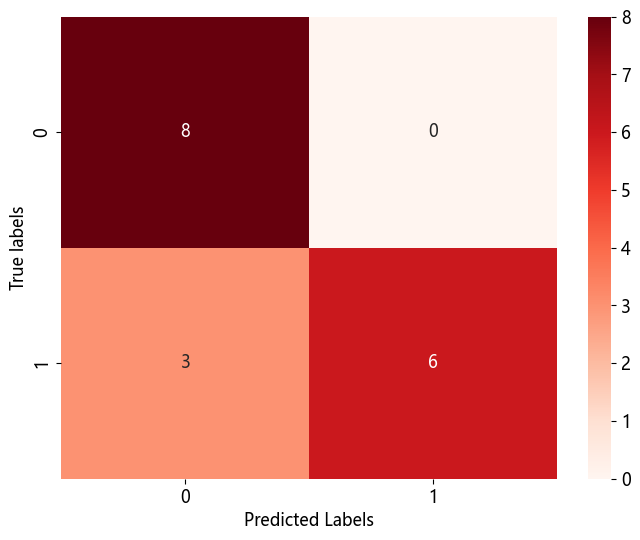

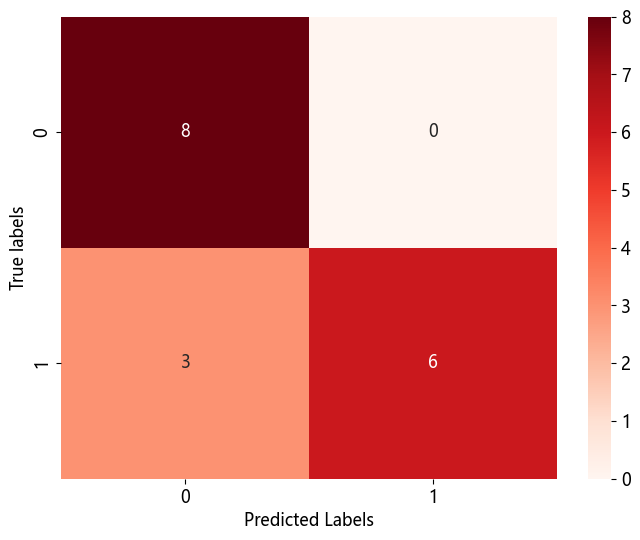

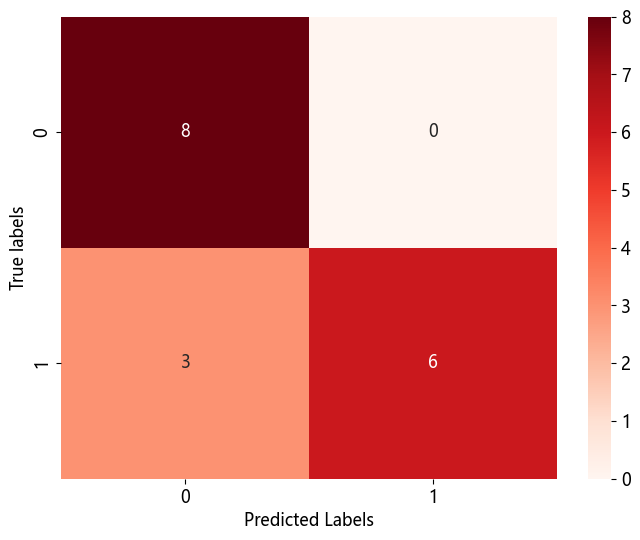

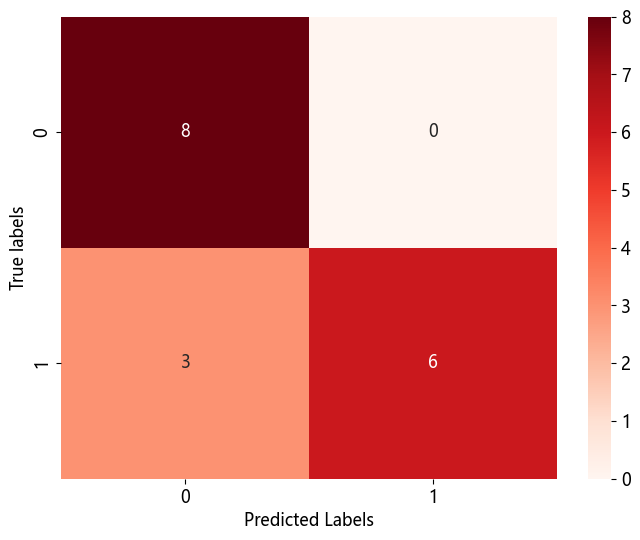

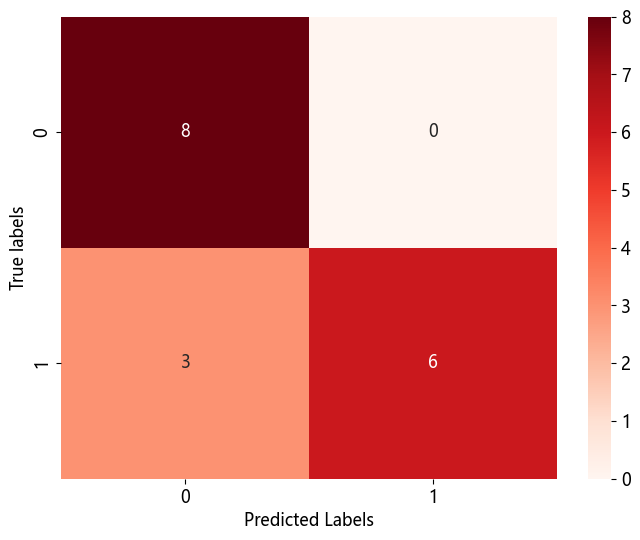

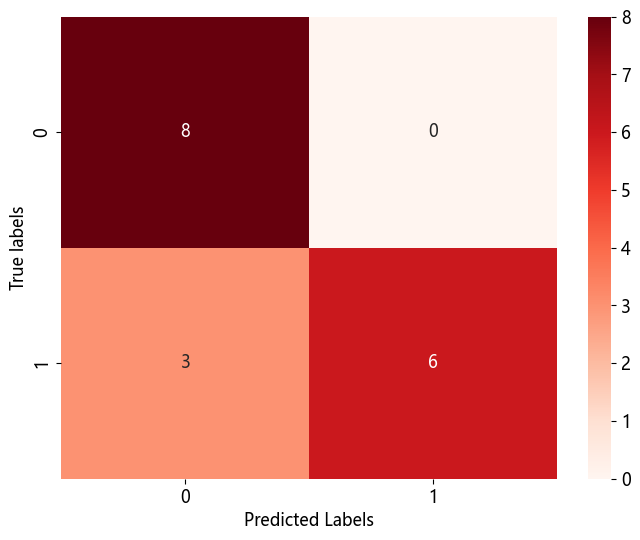

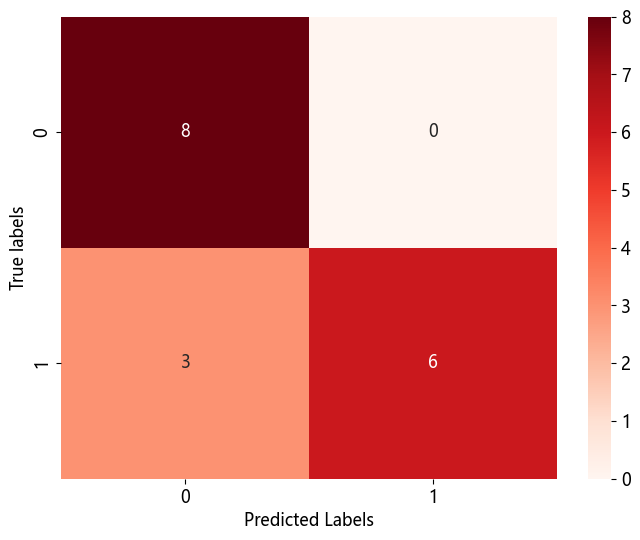

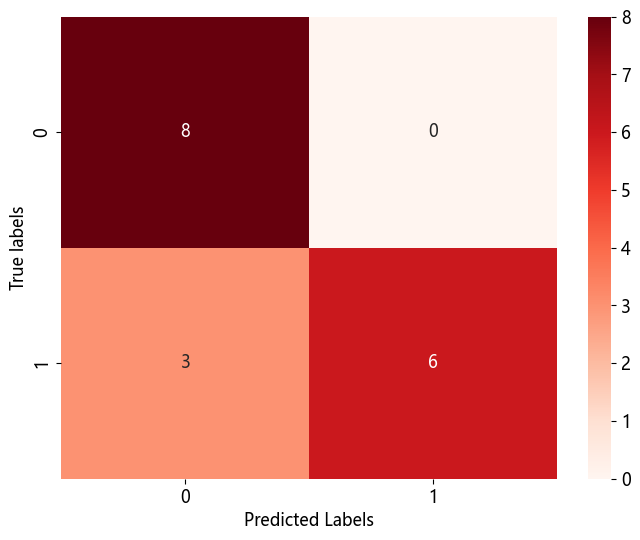

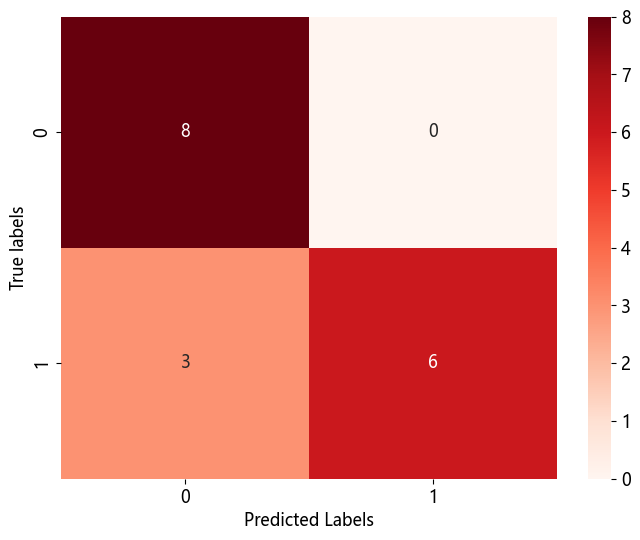

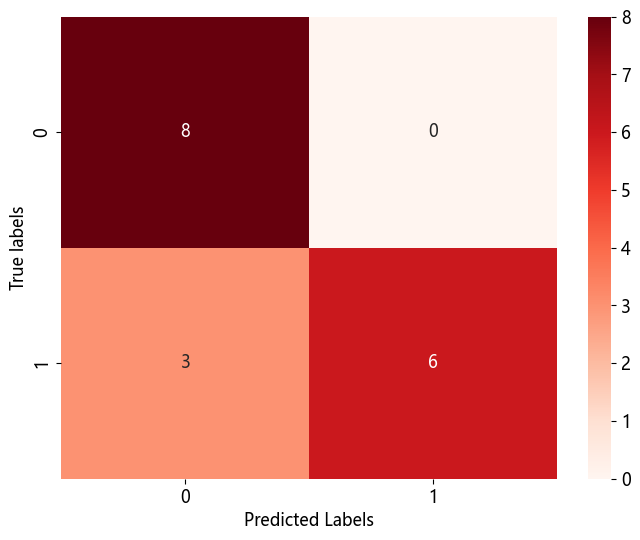

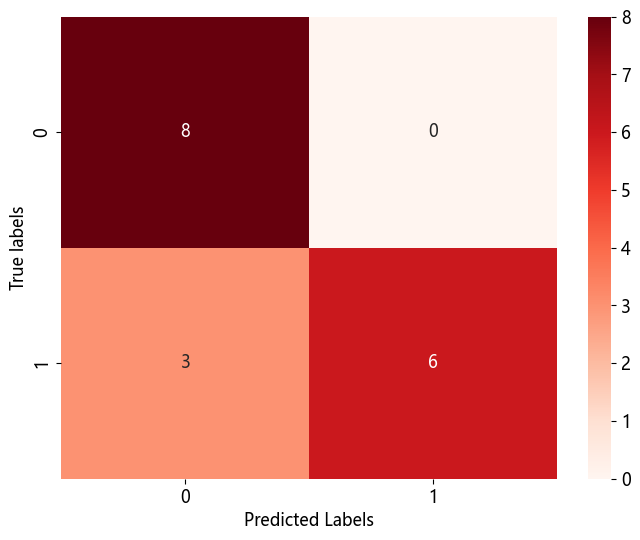

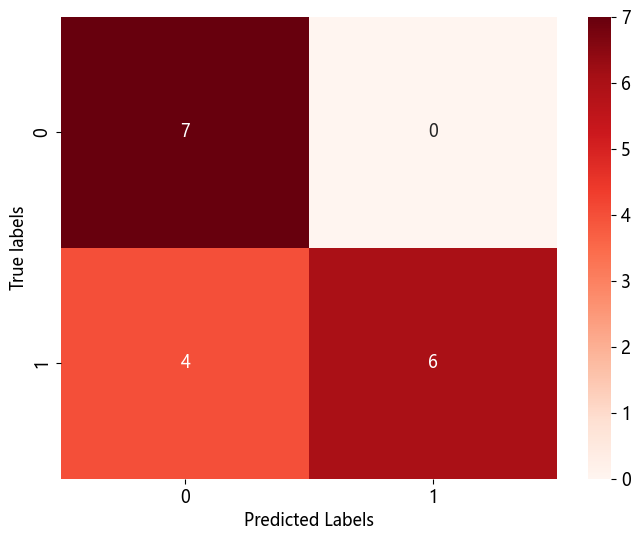

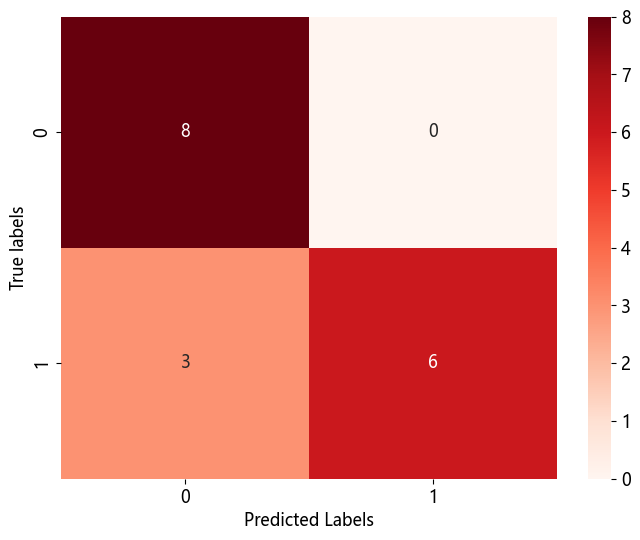

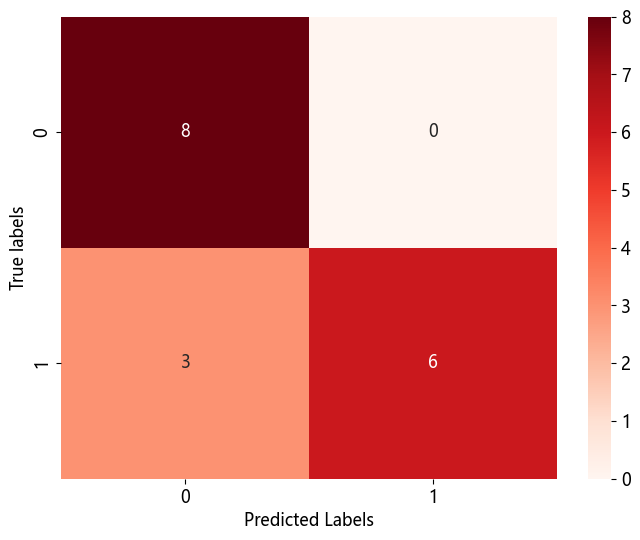

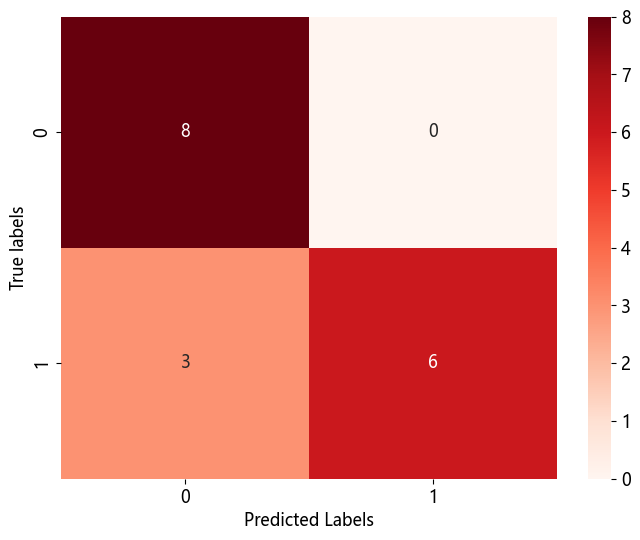

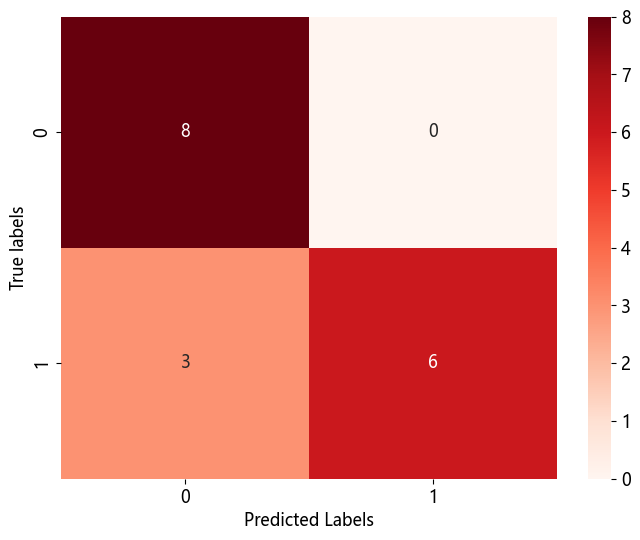

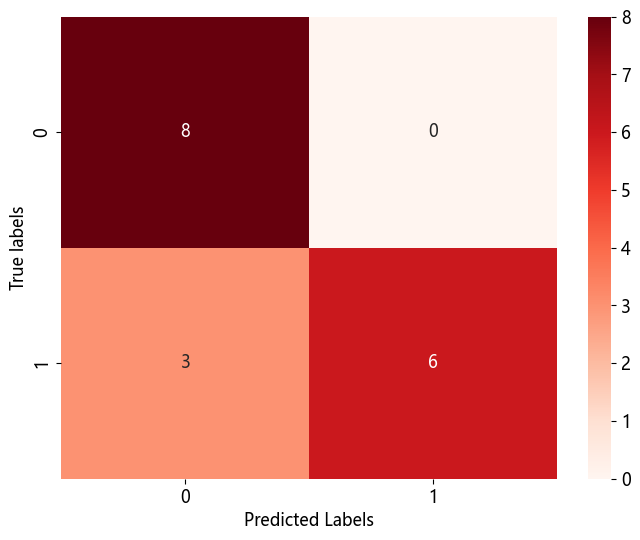

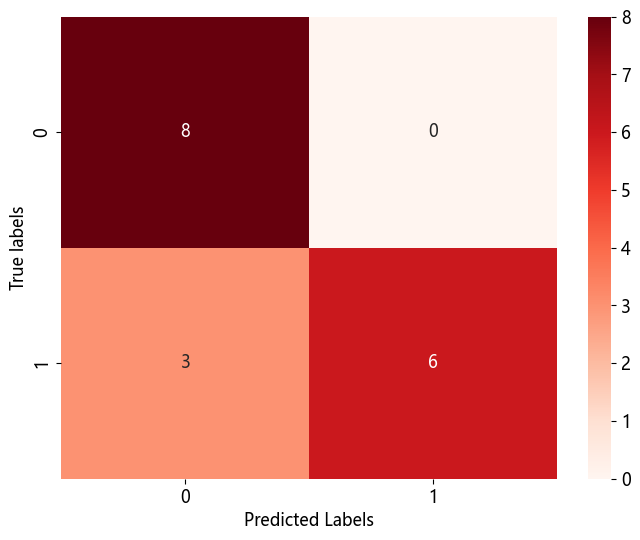

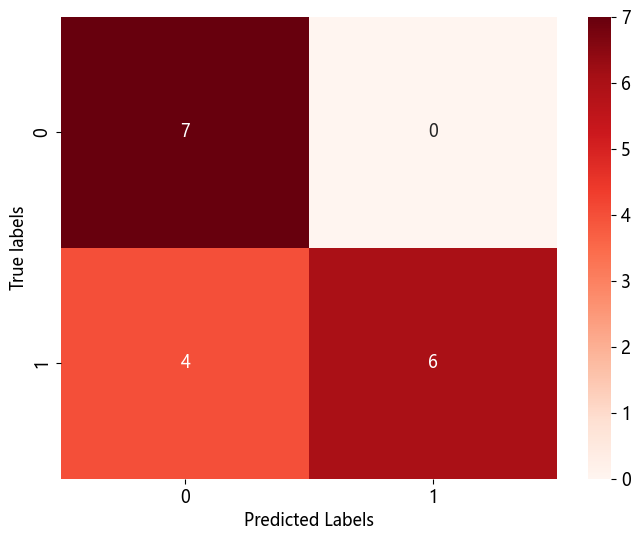

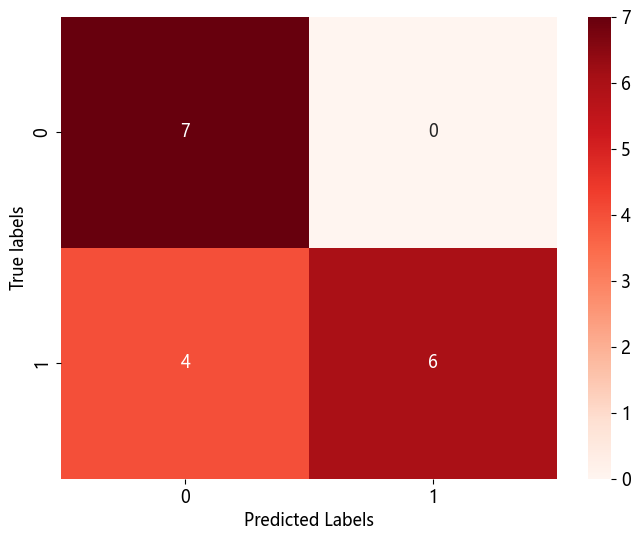

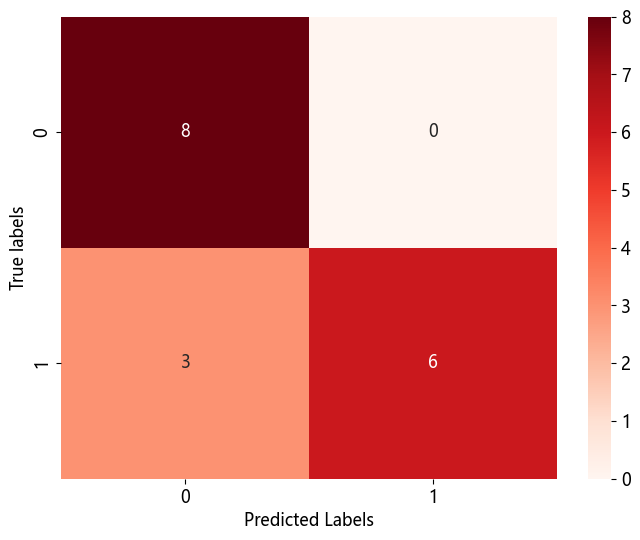

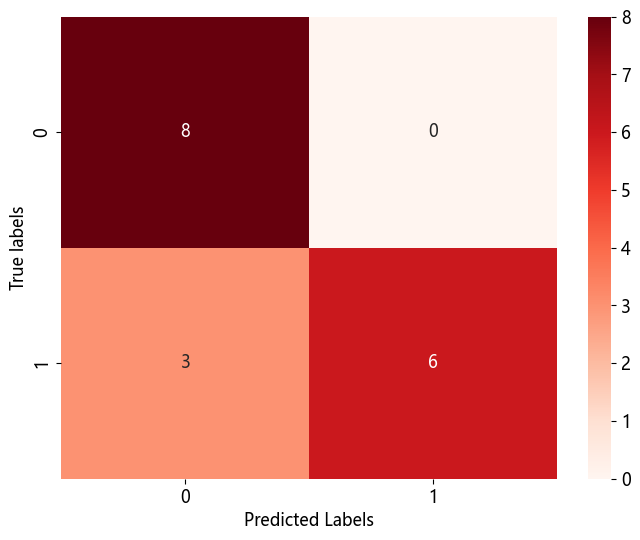

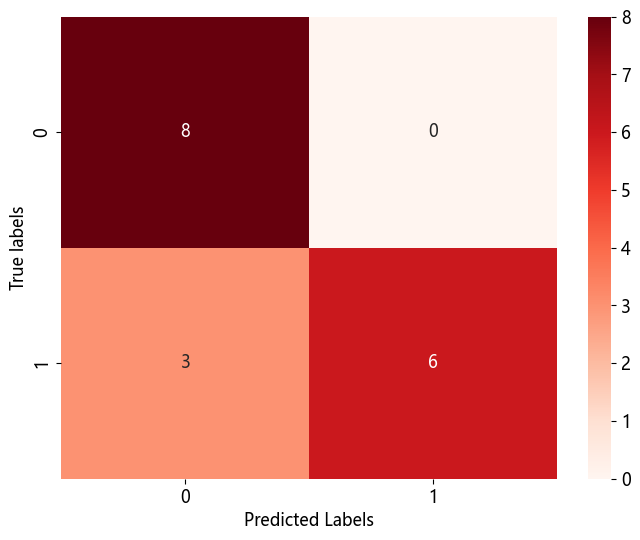

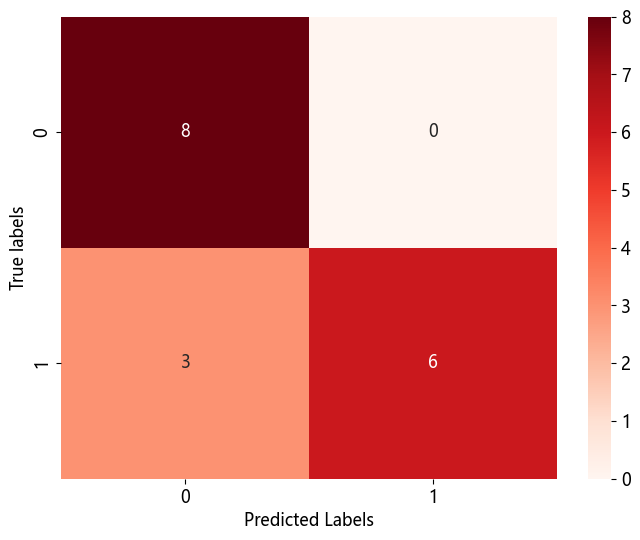

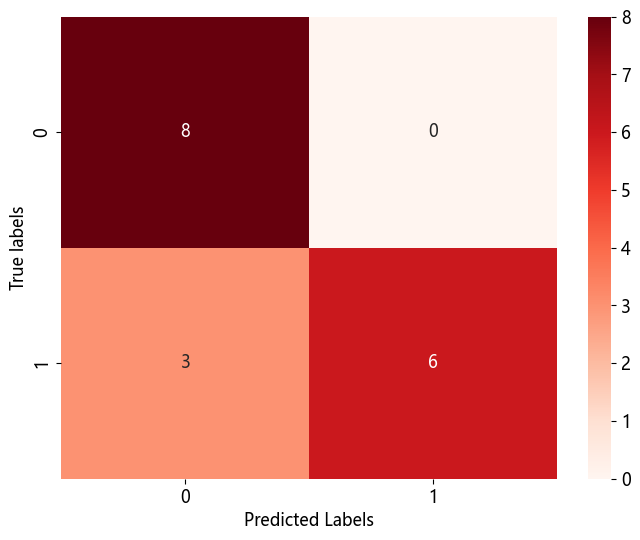

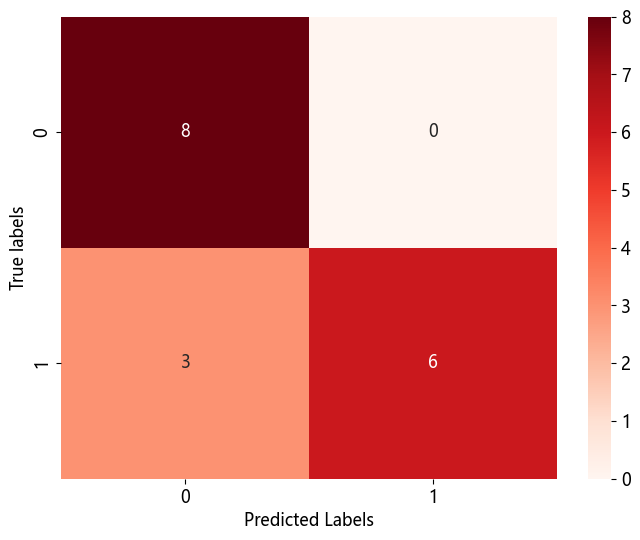

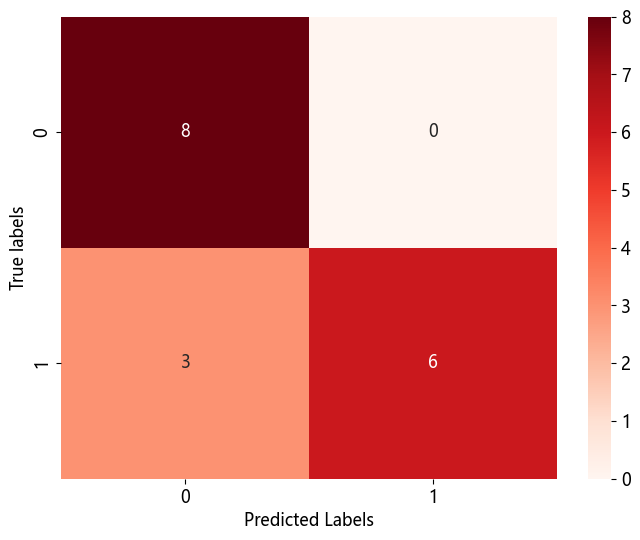

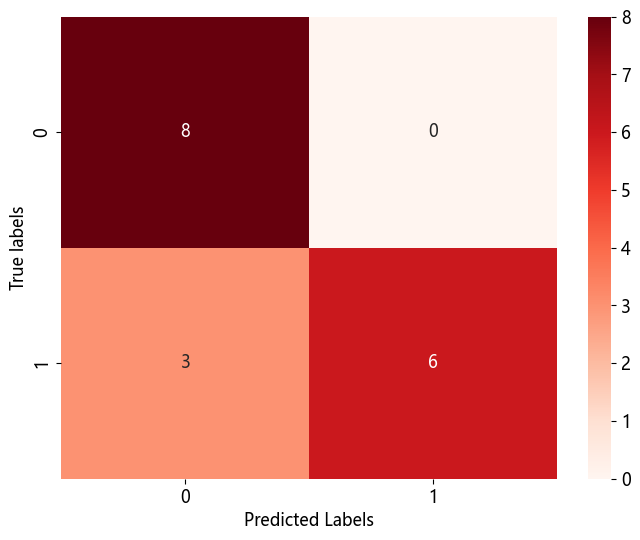

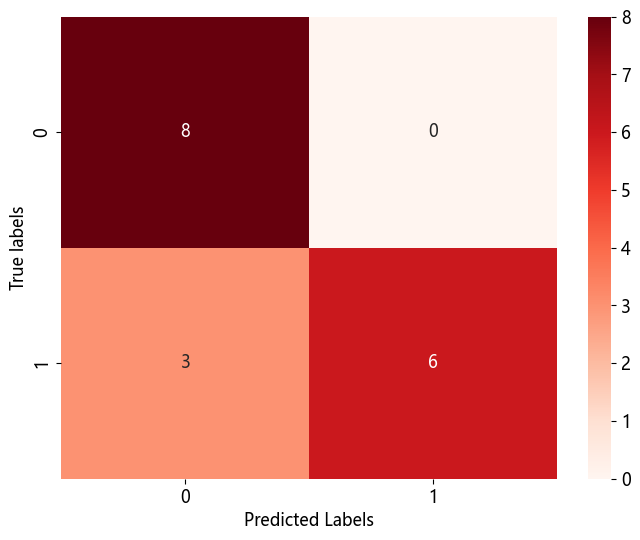

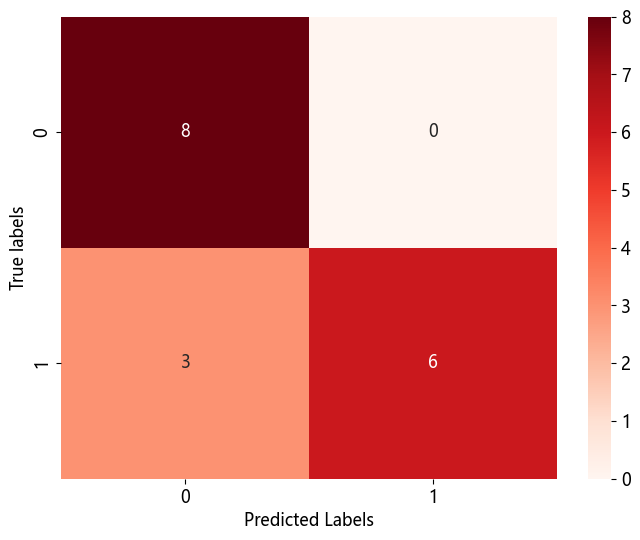

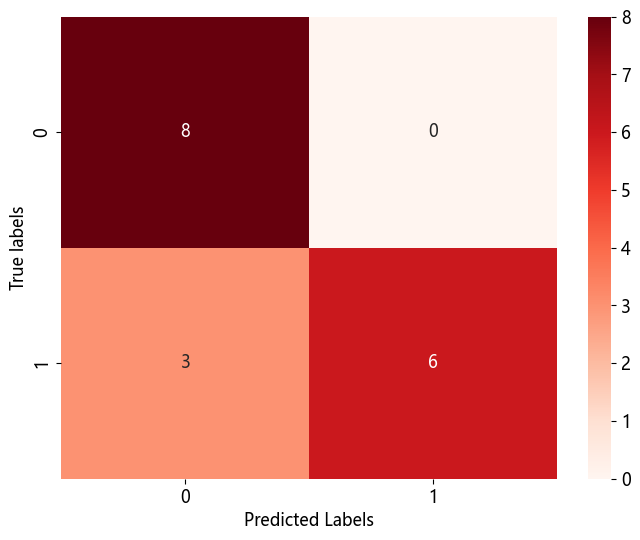

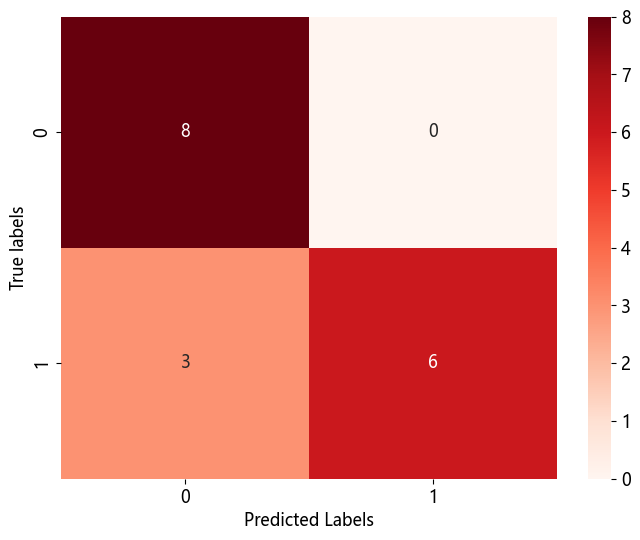

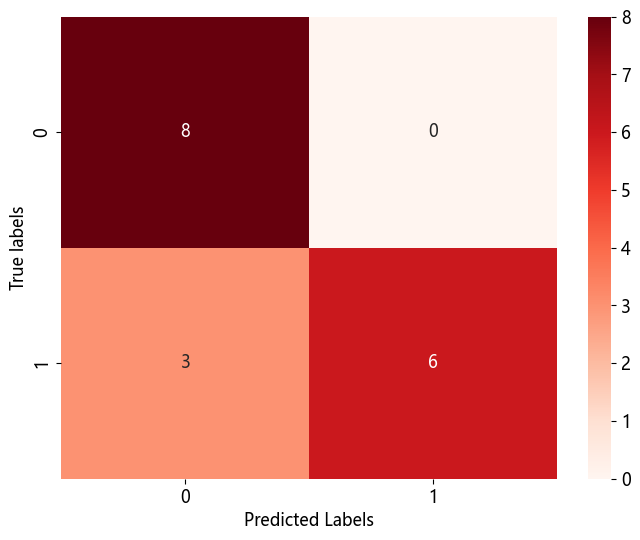

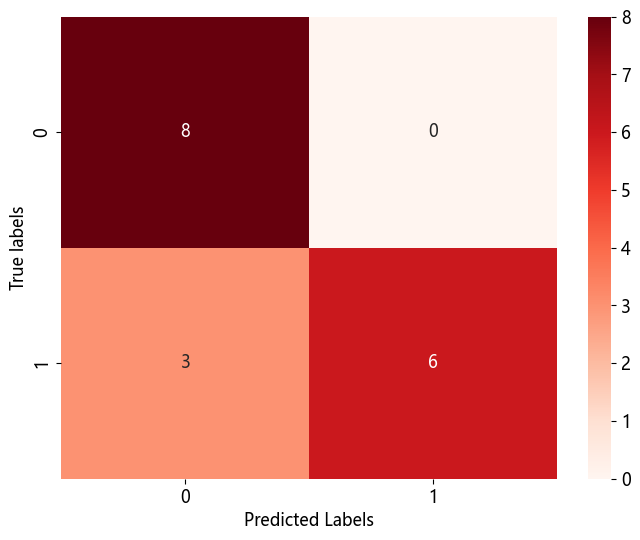

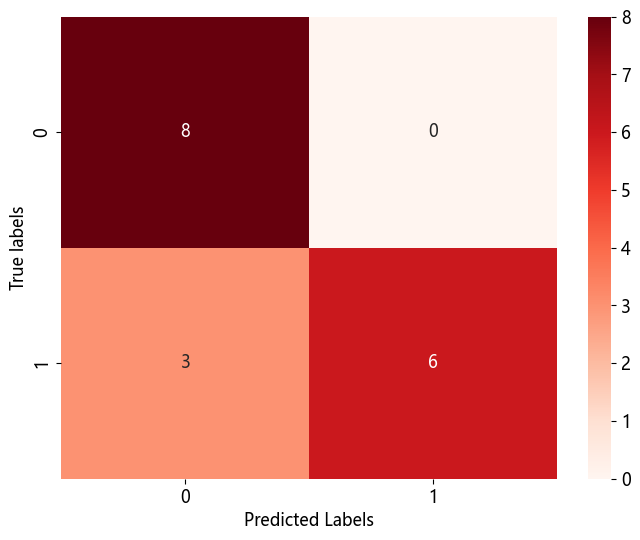

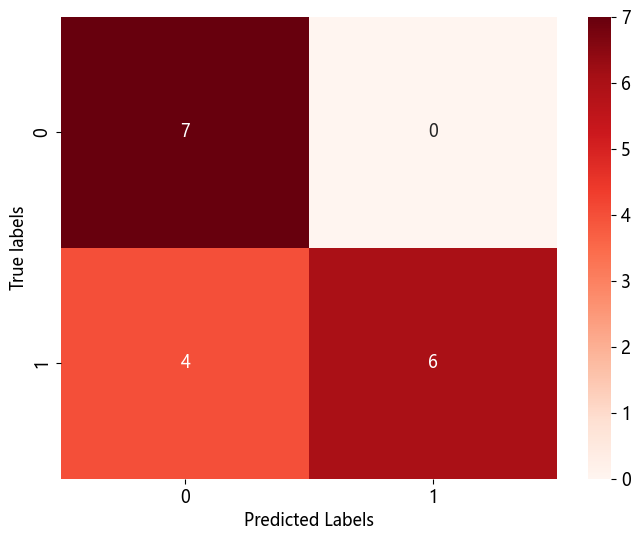

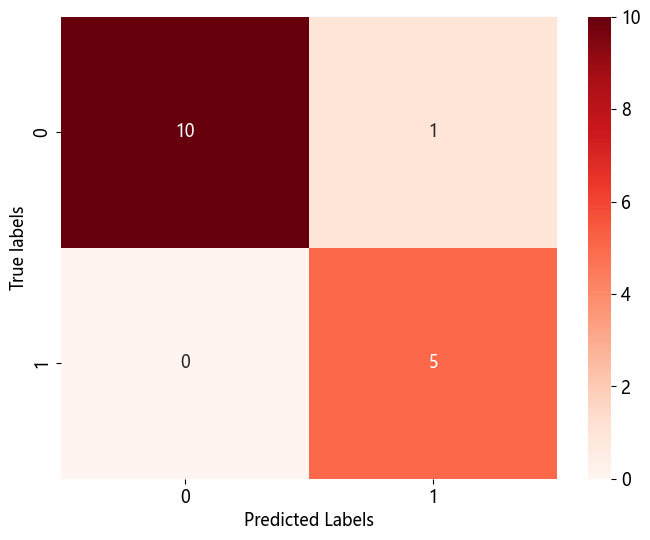

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import  RandomForestClassifier
import pydotplus
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import warnings  
warnings.filterwarnings('ignore')
import joblib
import os 
import shutil
from glob import glob
from utils import *
from openpyxl import load_workbook
plt.rcParams['font.sans-serif']=['Microsoft YaHei']  # Font set for Chinese characters
plt.rcParams['font.size'] = 12  # Font size
plt.rcParams['axes.unicode_minus'] = False

save_model = False
data_excel='predict.xlsx'
data_name='GWD'  # Which sheet of the Excel file to use for the dataset, the sheet should be in the form of data_XX, XX is data_name
label_name='GWD' # Name of the dataset label
sheet_name=f'{data_name}_data'
data=pd.read_excel(data_excel,sheet_name=sheet_name)
data=data.fillna(0)
size_threshold=0.8

data_target=pd.DataFrame([1 if x>size_threshold else 0 for x in data[label_name]])  # Divide the original GWD into two categories based on the threshold, where 0 represents smaller values, and 1 represents larger values
## print(data_target.items)
print('Threshold value is', size_threshold)
# print(type(data_target))
print(data_target.value_counts())
# print(data[label_name])
# print(type(data_target))

feature_names=['cC','cO','cN','cF','cP','cS','OCr','FCr','FOr','PCr','NCr',
               'SCr','NFr','POr','NOr','SOr','PFr','SFr','SPr','NSr','FNS/Or',
               'FP/Or','FNS/FPr']

data_features_part=data[feature_names]
epoch_num=1
n_splits=3
# print(data[feature_names].values[:,0])

StrK=StratifiedKFold(n_splits=n_splits,shuffle=False)
n_split=StrK.get_n_splits(data_features_part,data_target)  # Number of splits is set to 10



main_path=f'{data_name}_classification_predict'
if save_model:
    create_dir(main_path,True)

    for i in range(1000):
        if not os.path.exists(main_path+'/'+main_path+'1'):
            main_path=main_path+'/'+main_path+'1'
            create_dir(main_path,True)
            break
        else:
            if not os.path.exists(main_path+'/'+main_path+str(i)):
                main_path=main_path+'/'+main_path+str(i)
                create_dir(main_path,True)
                break
            else:
                continue
if save_model:
    create_dir(main_path+'/report')
    create_dir(main_path+'/model')
    create_dir(main_path+'/confusion_matrix')
    create_dir(main_path+'/Feature importance of different models')

f1_score_ls=[]
# Record fold situation
ls1=['fold'+str(i) for i in range(n_splits)]

fold_dict=dict(zip(ls1,[0 for i in range(len(ls1))]))

train=True
# Dataset table
excel= main_path + '/predict.xlsx'
if train==True:
    if not os.path.exists(excel) and save_model:
        if save_model:
            mycopyfile(data_excel,main_path) # Create a new copy of the dataset table in the folder
    clf=RandomForestClassifier(criterion='entropy',n_estimators=30,max_features='log2',max_depth=5,max_samples=None)

    for i,(train_index,test_index) in enumerate(StrK.split(data_features_part,data_target)):
        # pass
        print(f'-------------Fold {i} cross-validation-----------')
        fold_dict['fold'+str(i)]=train_index
        f1_score_ls=[]
        x_train=data_features_part.iloc[train_index]
        y_train=data_target.iloc[train_index]

        x_test=data_features_part.iloc[test_index]
        y_test=data_target.iloc[test_index]
        
        for n in range(epoch_num):
            f1_score_sum=0
            print(f'Training for the {n}th time')
            clf.fit(x_train,y_train)

            test_predict=clf.predict(x_test)
            f1_score=metrics.f1_score(y_test,test_predict)
            
            # recall=metrics.recall_score(y_test,test_predict)

            # print(f'Fold {i} f1_score=',f1_score)
            report=metrics.classification_report(y_test,test_predict)

            plt.figure(figsize=(8,6))  # The optimal size for plotting a confusion matrix is (8,6) or a similar ratio
            confusion_matrix_result=metrics.confusion_matrix(test_predict,y_test,labels=[0,1])
            sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True labels')
            if save_model:
                plt.savefig(f'{main_path}/confusion_matrix(temp)/Model prediction confusion matrix {i}.jpg')
            # print('Generated confusion matrix image')
            # plt.show()   
                
            # Save model file
            if save_model:
                joblib.dump(clf,main_path+'/model(temp)/'+f'model{i}.pkl')
            # print('Saved model file')

            # Print report
            if save_model:
                file=open(main_path+f'/report(temp)/report{i}.txt','w')
                file.write(report)

            if len(f1_score_ls)==0 or f1_score>max(f1_score_ls):
                print(f'Fold {i}, Training for the {n}th time, f1_score mean', f1_score)
                f1_score_ls.append(f1_score)
                if save_model:
                    mycopyfile(main_path+f'/model(temp)/model{i}.pkl',main_path+'/model')
                    mycopyfile(main_path+f'/report(temp)/report{i}.txt',main_path+'/report')
                    mycopyfile(main_path+f'/confusion_matrix(temp)/Model prediction confusion matrix {i}.jpg',main_path+'/confusion_matrix')
                    file=open(main_path+f'/report/report{i}.txt','w')
                    print(f'Fold {i}, Training for the {n}th time, report\n',report)
                    file.write(report)
                    file.write('Threshold'+str(size_threshold))

            if i==n_splits-1 and save_model:
                ls=list(fold_dict.values())
                df=pd.DataFrame(ls)
                book=load_workbook(excel)
                with pd.ExcelWriter(excel) as writer:
                    writer.book=book
                    df.to_excel(writer,sheet_name='k-fold')
                    
            if f1_score>=0.95:
                break
                # df=pd.read_excel(excel,sheet_name='k-fold')
                # print('Training set indices:',list(df))